## CIS731:Artificial Neural Networks:Final Course Project:Driver Drowsiness Detection System

## Instructor: Prof. C.K. Mohan

## Submitted by: Sankalp Singh||ssingh56@syr.edu||974006655

## Date of Submission: 12/01/2020

### Problem Statement:
Feeling drowsy while we are behind the wheels is something all of us have faced sometime or the other. Long road trips, driving continuously for several days and nights can lead us to feel fatigued and drowsy while driving. According to the statistics – “1 in 25 adult drivers report that they have fallen asleep at the wheel in the past 30 days”. Moreover, 1 in 4 vehicle accidents happen because the driver is feeling drowsy while driving. Drowsy driving can have severe consequences, and this is a problem that needs to be addressed

To resolve this major societal problem, I have designed a ‘Driver Drowsiness Detection System’. This system will identify the key factors of drowsiness seen while driving and trigger an alert when a driver feels drowsy before it’s too late.

I have designed several machine learning models for 'Driver Drowsiness Detection System' that will be taking in features such as Eye-Aspect-Ratio, Mouth-Aspect-Ratio, Pupil-Circularity and Mouth-Over-Eye as inputs and will be predicting the States of the driver as either Alert or Drowsy as the outputs. This is a binary classification problem.

### Information about the Dataset:

For our training and testing data, I have used the RLDD (Real-Life Drowsiness Dataset) which has been specifically curated for this purpose by a research team at University of Texas, Arlington for detecting multi-stage drowsiness. This dataset consists of 180 RGB videos which is around 30 hours of videos of 60 unique participants. Each video is around 10 min long and was recorded by a personal cell phone or web camera in a way to replicate the videos similar to what would be obtained in a car or from a phone holder on the car dash.For each participant, there is one video for each of the two different classes:

1)	Alert – subject is completely conscious and can easily drive for long hours

2)	Drowsy – subject is falling asleep and needs to actively try to not fall asleep

For my project, I have currently used 18 videos of 9 unique participants and have trained the machine learning models using these videos

Link to the dataset:
https://sites.google.com/view/utarldd/home


### Import libraries

In [146]:
# import all the required libraries
import numpy as np
import pandas as pd
import math
import os.path
import csv
import glob
import tensorflow as tf
import h5py as h5py
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model, load_model
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv1D
from keras.optimizers import Adam, RMSprop
from keras.layers import Dropout
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, ShuffleSplit, LeaveOneOut
from tensorflow.keras.layers import LSTM
from keras.layers import SimpleRNN
from tensorflow.keras.layers import GRU
from timeit import default_timer as timer
from keras.callbacks import History
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
from pandas import DataFrame, Series
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
from scipy.spatial import distance_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, ShuffleSplit, LeaveOneOut
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,precision_score,classification_report,recall_score,roc_curve,roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB,GaussianNB
import pickle
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)
import random as rn
import os
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from keras import models
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
rn.seed(12345)
from keras import backend as K
from collections import OrderedDict
import imageio
import matplotlib.pyplot as plt
from mlxtend.image import extract_face_landmarks
from scipy.spatial import distance
import cv2
import statistics

### Unzipping video files

- This has been used to extract the zip files containing videos for each of the participants
- Once, we have the videos for both the Alert and Drowsy states for each of the participants extracted, then we have used them for further data pre-processing steps

In [2]:
# Unzipping video files
# import zipfile
# with zipfile.ZipFile("24.zip","r") as zip_ref:
#     zip_ref.extractall("/home/ssingh56")

## Data Pre-processing & Exploratory Data Analysis

Here, we have followed the CRISP-DM methodology which consists of following steps in the mentioned order: 
Business & Data Understanding -> 

Data cleaning & Pre-processing -> 

Modeling -> 

Performance Evaluation

We have addressed the following steps here while performing the data pre-processing:

1) Defining functions for four core facial features

2) Extracting image frames from videos

3) Extracting facial landmarks from image frames

4) Data Transformations

5) Feature Engineering

6) EDA

7) Normalizing and Scaling the data

### 1) Defining functions for 4 core facial features - EAR, MAR, Pupil Circularity, MOE

- Eye Aspect Ratio (EAR) – This is the ratio of the length of the eyes to the width of the eyes. The length of the eyes is calculated by averaging over two distinct vertical lines across the eyes. When an individual is drowsy, their eyes are likely to get smaller. This will help our models to predict the target class as ‘Drowsy’ when the EAR starts to decline over successive frames for an individual 
	
- Mouth Aspect Ratio (MAR) – This is the ratio of the length of the mouth to the width of the mouth. MAR will start to get higher when an individual is drowsy as they will start to yawn

- Pupil Circularity (PUC) – This feature focusses more on the pupil instead of the entire eye. A drowsy person will have a lower pupil circularity compared to an alert person

- Mouth Aspect Ratio over Eye Aspect Ratio (MAR/EAR=MOE) – This is the ratio of MAR to EAR. EAR and MAR are expected to move in opposite directions if a person becomes drowsy. As MOE has EAR in the denominator, MOE will increase when a person becomes drowsy



In [147]:
# define EAR
def eye_aspect_ratio(eye):
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

In [148]:
# define MAR
def mouth_aspect_ratio(mouth):
    A = distance.euclidean(mouth[14], mouth[18])
    C = distance.euclidean(mouth[12], mouth[16])
    mar = (A ) / (C)
    return mar

In [149]:
# define Pupil circularity
def circularity(eye):
    A = distance.euclidean(eye[1], eye[4])
    radius  = A/2.0
    Area = math.pi * (radius ** 2)
    p = 0
    p += distance.euclidean(eye[0], eye[1])
    p += distance.euclidean(eye[1], eye[2])
    p += distance.euclidean(eye[2], eye[3])
    p += distance.euclidean(eye[3], eye[4])
    p += distance.euclidean(eye[4], eye[5])
    p += distance.euclidean(eye[5], eye[0])
    return 4 * math.pi * Area /(p**2)

In [150]:
# define MOE
def mouth_over_eye(eye):
    ear = eye_aspect_ratio(eye)
    mar = mouth_aspect_ratio(eye)
    mouth_eye = mar/ear
    return mouth_eye

### 2) Extracting frames from videos

- Here, I have used the OpenCV library provided by Python for extracting image frames from videos of each participant

- Each video is 10 min long, so I have skipped the first minute of each video as there was not much activity in the first 60 seconds of each of the videos

In [151]:
# openCV to capture frames from videos
def getFrame(sec,video):
    start = 60000
    video.set(cv2.CAP_PROP_POS_MSEC, start + sec*1000)
    hasFrames,image = video.read()
    return hasFrames, image

### 3) Extracting facial landmarks from image frames

- Here, I have extracted all the 68 facial landmarks by using the extract face landmarks function provided by MLextend, OpenCV and Dlib libraries

- Since, I have skipped 1 min for each of the video, therefore I have extracted the landmarks for 540 frames i.e. 1 frame per second for next 9 minutes of each video

- I have extracted the facial landmarks for 540 frames for each of the video - Alert state and Drowsy state. So, in total we have 1080 frames for each participant

- Below, I have showcased how we can extract facial landmarks for 1 participants i.e. 2 videos (Alert & Drowsy). The code is scalable and we just need to add the pid(participant id) of the participant for whom we want to extract the landmarks and the below code will fetch it for us for both the output states

- I have also created a time and a participants list to keep a track of the time and participant id for each of the extracted frames for each second

In [9]:
data=[]
label=[]
pid=[1]
time=[]
participants=[]

# for alert state
for participant in pid:
    video = cv2.VideoCapture(str(participant)+'/0.MOV')
    for i in range(1,541):
        success, image = getFrame(i,video)
        if success:
            landmarks = extract_face_landmarks(image)
            if sum(sum(landmarks))!= 0:
                data.append(landmarks)
                label.append(0)
                time.append(i)
                participants.append(participant)
                print('Collected Alert landmarks for participant ', participant, 'for time', i)
            else:
                print('Participant ', participant, ' Alert Landmark not detected for time = ', i)
        else:
            print('Participant ' ,participant, ' Alert frame not detected for time = ' ,i)

            
# for drowsy state            
for participant in pid:
    video = cv2.VideoCapture(str(participant)+'/1.MOV')
    for i in range(1,541):
        success, image = getFrame(i,video)
        if success:
            landmarks = extract_face_landmarks(image)
            if sum(sum(landmarks))!= 0:
                data.append(landmarks)
                label.append(1)
                time.append(i)
                participants.append(participant)
                print('Collected Drowsy landmarks for participant ', participant, 'for time', i)
            else:
                print('Participant ' ,participant, ' Drowsy Landmark not detected for time = ' ,i)
        else:
            print('Participant ',participant, ' Drowsy frame not detected for time = ' ,i)



        
        

Collected Alert landmarks for participant  1 for time 1
Collected Alert landmarks for participant  1 for time 2
Collected Alert landmarks for participant  1 for time 3
Collected Alert landmarks for participant  1 for time 4
Collected Alert landmarks for participant  1 for time 5
Collected Alert landmarks for participant  1 for time 6
Collected Alert landmarks for participant  1 for time 7
Collected Alert landmarks for participant  1 for time 8
Collected Alert landmarks for participant  1 for time 9
Collected Alert landmarks for participant  1 for time 10
Collected Alert landmarks for participant  1 for time 11
Collected Alert landmarks for participant  1 for time 12
Collected Alert landmarks for participant  1 for time 13
Collected Alert landmarks for participant  1 for time 14
Collected Alert landmarks for participant  1 for time 15
Collected Alert landmarks for participant  1 for time 16
Collected Alert landmarks for participant  1 for time 17
Collected Alert landmarks for participan

### 4) Data Transformations

- Once, we have all the 68 facial landmarks extracted for each participant for each of the states - Alert and Drowsy - I have converted all the lists into numpy array for futher processing

- Here, we have kept only those features out of 68 landmarks that are crucial for our model building. We have kept the landmarks in the range 36:68 as they represent the eyes, nose, mouth and lips and I think these features will be helpful for training our ML models

-  After this, I have converted all the numpy arrays - Features, Labels, Time Stamps, Participants - into respective csv files

- The cvs files have then been used to create 4 dataframes and finally I have merged all the four dataframes to create the final dataframe that will be used to modeling purposes

In [10]:
# converting all lists to arrays
data = np.array(data)
label = np.array(label)
time = np.array(time)
participants = np.array(participants)

In [11]:
# appending all four features to a list
features = []
for d in data:
    eye = d[36:68]
    ear = eye_aspect_ratio(eye)
    mar = mouth_aspect_ratio(eye)
    cir = circularity(eye)
    mouth_eye = mouth_over_eye(eye)
    features.append([ear, mar, cir, mouth_eye])

In [12]:
# converting feature list to array and printing shapes of all arrays
features = np.array(features)
print(features.shape)
print(data.shape)
print(label.shape)
print(time.shape)
print(participants.shape)

(1080, 4)
(1080, 68, 2)
(1080,)
(1080,)
(1080,)


#### Converting all 4 arrays to csv files

In [13]:
# converting arrays into csv's
np.savetxt("final_features1.csv", features, delimiter = ",")
np.savetxt("final_labels1.csv", label, delimiter = ",")
np.savetxt("final_times1.csv", time, delimiter = ",")
np.savetxt("final_participants1.csv", participants, delimiter = ",")

#### Collecting all features, labels, participant id and time stamps for all 9 participants using their respective csv's and storing them in respective dataframes and then merging them into one df

In [152]:
# storing features for all 9 participants in dfs, renaming the columns and merging them into a final features df
f1 = pd.read_csv("final_features1.csv")
f2 = pd.read_csv("final_features2.csv")
f3 = pd.read_csv("final_features3.csv")
f4 = pd.read_csv("final_features4.csv")
f5 = pd.read_csv("final_features5.csv")
f6 = pd.read_csv("final_features6.csv")
f7 = pd.read_csv("final_features8.csv")
f8 = pd.read_csv("final_features13.csv")
f9 = pd.read_csv("final_features18.csv")
f1.columns = ['EyeAspectRatio', 'MouthAspectRatio', 'PupilCircularity', 'MouthOverEye']
f2.columns = ['EyeAspectRatio', 'MouthAspectRatio', 'PupilCircularity', 'MouthOverEye']
f3.columns = ['EyeAspectRatio', 'MouthAspectRatio', 'PupilCircularity', 'MouthOverEye']
f4.columns = ['EyeAspectRatio', 'MouthAspectRatio', 'PupilCircularity', 'MouthOverEye']
f5.columns = ['EyeAspectRatio', 'MouthAspectRatio', 'PupilCircularity', 'MouthOverEye']
f6.columns = ['EyeAspectRatio', 'MouthAspectRatio', 'PupilCircularity', 'MouthOverEye']
f7.columns = ['EyeAspectRatio', 'MouthAspectRatio', 'PupilCircularity', 'MouthOverEye']
f8.columns = ['EyeAspectRatio', 'MouthAspectRatio', 'PupilCircularity', 'MouthOverEye']
f9.columns = ['EyeAspectRatio', 'MouthAspectRatio', 'PupilCircularity', 'MouthOverEye']
final_features = pd.concat([f1,f2,f3,f4,f5,f6,f7,f8,f9])

In [153]:
# storing labels for all 9 participants in dfs, renaming the columns and merging them into a final df
l1 = pd.read_csv("final_labels1.csv")
l2 = pd.read_csv("final_labels2.csv")
l3 = pd.read_csv("final_labels3.csv")
l4 = pd.read_csv("final_labels4.csv")
l5 = pd.read_csv("final_labels5.csv")
l6 = pd.read_csv("final_labels6.csv")
l7 = pd.read_csv("final_labels8.csv")
l8 = pd.read_csv("final_labels13.csv")
l9 = pd.read_csv("final_labels18.csv")
l1.columns = ['State']
l2.columns = ['State']
l3.columns = ['State']
l4.columns = ['State']
l5.columns = ['State']
l6.columns = ['State']
l7.columns = ['State']
l8.columns = ['State']
l9.columns = ['State']
final_labels = pd.concat([l1,l2,l3,l4,l5,l6,l7,l8,l9])

In [154]:
# storing time frames for all 9 participants in dfs, renaming the columns and merging them into a final df
t1 = pd.read_csv("final_times1.csv")
t2 = pd.read_csv("final_times2.csv")
t3 = pd.read_csv("final_times3.csv")
t4 = pd.read_csv("final_times4.csv")
t5 = pd.read_csv("final_times5.csv")
t6 = pd.read_csv("final_times6.csv")
t7 = pd.read_csv("final_times8.csv")
t8 = pd.read_csv("final_times13.csv")
t9 = pd.read_csv("final_times18.csv")
t1.columns = ['TimeSec']
t2.columns = ['TimeSec']
t3.columns = ['TimeSec']
t4.columns = ['TimeSec']
t5.columns = ['TimeSec']
t6.columns = ['TimeSec']
t7.columns = ['TimeSec']
t8.columns = ['TimeSec']
t9.columns = ['TimeSec']
final_times = pd.concat([t1,t2,t3,t4,t5,t6,t7,t8,t9])

In [155]:
# storing participant id for all 9 participants in dfs, renaming the columns and merging them into a final df
p1 = pd.read_csv("final_participants1.csv")
p2 = pd.read_csv("final_participants2.csv")
p3 = pd.read_csv("final_participants3.csv")
p4 = pd.read_csv("final_participants4.csv")
p5 = pd.read_csv("final_participants5.csv")
p6 = pd.read_csv("final_participants6.csv")
p7 = pd.read_csv("final_participants8.csv")
p8 = pd.read_csv("final_participants13.csv")
p9 = pd.read_csv("final_participants18.csv")
p1.columns = ['Participant']
p2.columns = ['Participant']
p3.columns = ['Participant']
p4.columns = ['Participant']
p5.columns = ['Participant']
p6.columns = ['Participant']
p7.columns = ['Participant']
p8.columns = ['Participant']
p9.columns = ['Participant']
final_participants = pd.concat([p1,p2,p3,p4,p5,p6,p7,p8,p9])

#### Creating 4 dataframes from the above 4 cvs

In [11]:
# converting csv's into dataframes
# final_features = pd.read_csv("final_features.csv")
# final_labels = pd.read_csv("final_labels.csv")
# final_times=pd.read_csv("final_times.csv")
# final_participants=pd.read_csv("final_participants.csv")

#### Renaming columns of dataframes according to the feature names, output state, Time and Participant

In [12]:
# renaming columns for the dataframes
# final_features.columns = ['EyeAspectRatio', 'MouthAspectRatio', 'PupilCircularity', 'MouthOverEye']
# final_labels.columns = ['State']
# final_times.columns = ["TimeSec"]
# final_participants.columns = ["Participant"]

#### Creating final dataframe that contains all the 4 input features, time stamps, participant id and the output states: 0 for Alert and 1 for Drowsy

In [156]:
# creating the final dataframe
df = pd.concat([final_participants, final_times, final_features, final_labels], axis=1)

In [157]:
# displaying shape of the df
df.shape

(9711, 7)

In [158]:
# printing the head of the df
df.head()

,Participant,TimeSec,EyeAspectRatio,MouthAspectRatio,PupilCircularity,MouthOverEye,State
0,1.0,2.0,0.274998,0.967638,0.426053,3.518702,0.0
1,1.0,3.0,0.295254,0.981583,0.445424,3.324538,0.0
2,1.0,4.0,0.287868,0.971274,0.423746,3.374022,0.0
3,1.0,5.0,0.275281,0.962297,0.411000,3.495693,0.0
4,1.0,6.0,0.289722,0.972110,0.429473,3.355323,0.0


### 5) Feature Engineering - Introducing Lags to tackle sequence of images problem

- Here, I have initially sorted the final dataframe with respect to the participant id, then their state and then the time stamp

- Models like LSTM and GRU can handle sequential data. But other basic classification models can't handle sequential data

- For this purpose, I have introduced the concept of lags in our features

- Basically, I have decided to feed all the input features from the last 4 frames to the classification models. This will help our basic classification models in handling sequence of images and the sequential data

- Though, this will cause a delay of 4 seconds for our classification models to predict the output state as they will always require the inputs from first 4 frames to make the predictions

- Because of this feature, I have removed the features for first 4 time frames for each of the participants before training our models

- So, now our dataframe contains 20 facial landmark input features (4 lags introduced for all 4 features)

- I have also converted the target feature - State - into int type

In [159]:
# sorting values based on columns
df = df.sort_values(['Participant', 'State', 'TimeSec'], ascending=[True, True, True])

In [160]:
# adding 4 lags for EAR
df['EyeAspectRatio_lag1'] = df['EyeAspectRatio'].shift(1)
df['EyeAspectRatio_lag2'] = df['EyeAspectRatio'].shift(2)
df['EyeAspectRatio_lag3'] = df['EyeAspectRatio'].shift(3)
df['EyeAspectRatio_lag4'] = df['EyeAspectRatio'].shift(4)

In [161]:
# adding 4 lags for MAR
df['MouthAspectRatio_lag1'] = df['MouthAspectRatio'].shift(1)
df['MouthAspectRatio_lag2'] = df['MouthAspectRatio'].shift(2)
df['MouthAspectRatio_lag3'] = df['MouthAspectRatio'].shift(3)
df['MouthAspectRatio_lag4'] = df['MouthAspectRatio'].shift(4)

In [162]:
# adding 4 lags for Pupil Circularity
df['PupilCircularity_lag1'] = df['PupilCircularity'].shift(1)
df['PupilCircularity_lag2'] = df['PupilCircularity'].shift(2)
df['PupilCircularity_lag3'] = df['PupilCircularity'].shift(3)
df['PupilCircularity_lag4'] = df['PupilCircularity'].shift(4)

In [163]:
# adding lags for MOE
df['MouthOverEye_lag1'] = df['MouthOverEye'].shift(1)
df['MouthOverEye_lag2'] = df['MouthOverEye'].shift(2)
df['MouthOverEye_lag3'] = df['MouthOverEye'].shift(3)
df['MouthOverEye_lag4'] = df['MouthOverEye'].shift(4)

In [164]:
# printing head of df
df.head()

,Participant,TimeSec,EyeAspectRatio,MouthAspectRatio,PupilCircularity,MouthOverEye,State,EyeAspectRatio_lag1,EyeAspectRatio_lag2,EyeAspectRatio_lag3,...,MouthAspectRatio_lag3,MouthAspectRatio_lag4,PupilCircularity_lag1,PupilCircularity_lag2,PupilCircularity_lag3,PupilCircularity_lag4,MouthOverEye_lag1,MouthOverEye_lag2,MouthOverEye_lag3,MouthOverEye_lag4
0,1.0,2.0,0.274998,0.967638,0.426053,3.518702,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,3.0,0.295254,0.981583,0.445424,3.324538,0.0,0.274998,NaN,NaN,...,NaN,NaN,0.426053,NaN,NaN,NaN,3.518702,NaN,NaN,NaN
2,1.0,4.0,0.287868,0.971274,0.423746,3.374022,0.0,0.295254,0.274998,NaN,...,NaN,NaN,0.445424,0.426053,NaN,NaN,3.324538,3.518702,NaN,NaN
3,1.0,5.0,0.275281,0.962297,0.411000,3.495693,0.0,0.287868,0.295254,0.274998,...,0.967638,NaN,0.423746,0.445424,0.426053,NaN,3.374022,3.324538,3.518702,NaN
4,1.0,6.0,0.289722,0.972110,0.429473,3.355323,0.0,0.275281,0.287868,0.295254,...,0.981583,0.967638,0.411000,0.423746,0.445424,0.426053,3.495693,3.374022,3.324538,3.518702


In [165]:
# removing first 4 frames for each of the participants
df = df.loc[df['TimeSec'] != 1]
df = df.loc[df['TimeSec'] != 2]
df = df.loc[df['TimeSec'] != 3]
df = df.loc[df['TimeSec'] != 4]

In [166]:
# dropping any NaN values
df = df.dropna()

In [167]:
# checking the null values
df.isnull().sum()

Participant              0
TimeSec                  0
EyeAspectRatio           0
MouthAspectRatio         0
PupilCircularity         0
MouthOverEye             0
State                    0
EyeAspectRatio_lag1      0
EyeAspectRatio_lag2      0
EyeAspectRatio_lag3      0
EyeAspectRatio_lag4      0
MouthAspectRatio_lag1    0
MouthAspectRatio_lag2    0
MouthAspectRatio_lag3    0
MouthAspectRatio_lag4    0
PupilCircularity_lag1    0
PupilCircularity_lag2    0
PupilCircularity_lag3    0
PupilCircularity_lag4    0
MouthOverEye_lag1        0
MouthOverEye_lag2        0
MouthOverEye_lag3        0
MouthOverEye_lag4        0
dtype: int64

In [168]:
# converting 'State' datatype to int
df['State'] = df['State'].apply(np.int64)

### 6) Exploratory Data Analysis

- Here, I have performed some visualizations that will help us understand the input features in a more efficient way

- I have plotted a count of 'State' to check is our dataset if balanced with respect to the target feature

- I have plotted box plot for all 4 facial features to get more insights on the features and landmarks

Text(0.5, 1.0, 'Distribution of States for our dataset')

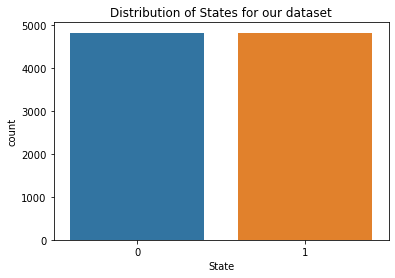

In [169]:
# Countplot to check the distribution of output label - 'State'
sns.countplot(x="State", data=df).set_title('Distribution of States for our dataset')

Text(0.5, 1.0, 'Box plot of EyeAspectRatio vs State')

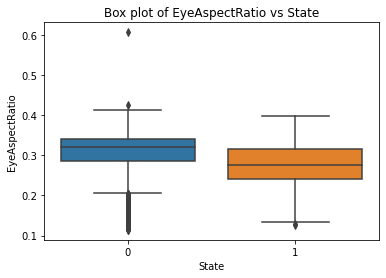

In [170]:
# Boxplot of EyeAspectRatio attribute vs target attribute State
sns.boxplot(y="EyeAspectRatio", x="State", data=df)
plt.title("Box plot of EyeAspectRatio vs State")

Text(0.5, 1.0, 'Box plot of MouthAspectRatio vs State')

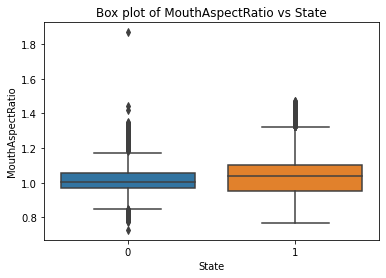

In [171]:
# Boxplot of MouthAspectRatio attribute vs target attribute State
sns.boxplot(y="MouthAspectRatio", x="State", data=df)
plt.title("Box plot of MouthAspectRatio vs State")

Text(0.5, 1.0, 'Box plot of PupilCircularity vs State')

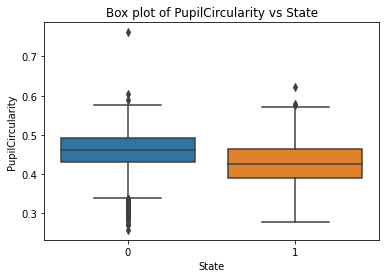

In [172]:
# Boxplot of PupilCircularity attribute vs target attribute State
sns.boxplot(y="PupilCircularity", x="State", data=df)
plt.title("Box plot of PupilCircularity vs State")

Text(0.5, 1.0, 'Box plot of MouthOverEye vs State')

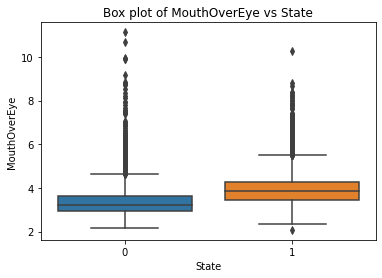

In [173]:
# Boxplot of MouthOverEye attribute vs target attribute State
sns.boxplot(y="MouthOverEye", x="State", data=df)
plt.title("Box plot of MouthOverEye vs State")

### 7) Normalizing and Scaling the input facial features

-  Normalizing and scaling the data is one of the most important aspects for our system

-  This is due to the fact that all human beings have different facial features and landmarks like - eyes, nose, lips and mouth.

- So, it becomes necessary to scale and normalize these features before training the models as this will help reduce bias in our models

In [174]:
# initializing the standard scalar
scaler=StandardScaler()

In [175]:
# normalizing and scaling the final df
df[['EyeAspectRatio', 'MouthAspectRatio',
       'PupilCircularity', 'MouthOverEye', 'EyeAspectRatio_lag1',
       'EyeAspectRatio_lag2', 'EyeAspectRatio_lag3', 'EyeAspectRatio_lag4',
       'MouthAspectRatio_lag1', 'MouthAspectRatio_lag2',
       'MouthAspectRatio_lag3', 'MouthAspectRatio_lag4',
       'PupilCircularity_lag1', 'PupilCircularity_lag2',
       'PupilCircularity_lag3', 'PupilCircularity_lag4', 'MouthOverEye_lag1',
       'MouthOverEye_lag2', 'MouthOverEye_lag3', 'MouthOverEye_lag4']] = scaler.fit_transform(df[['EyeAspectRatio', 'MouthAspectRatio',
       'PupilCircularity', 'MouthOverEye', 'EyeAspectRatio_lag1',
       'EyeAspectRatio_lag2', 'EyeAspectRatio_lag3', 'EyeAspectRatio_lag4',
       'MouthAspectRatio_lag1', 'MouthAspectRatio_lag2',
       'MouthAspectRatio_lag3', 'MouthAspectRatio_lag4',
       'PupilCircularity_lag1', 'PupilCircularity_lag2',
       'PupilCircularity_lag3', 'PupilCircularity_lag4', 'MouthOverEye_lag1',
       'MouthOverEye_lag2', 'MouthOverEye_lag3', 'MouthOverEye_lag4']])

## Model Building

- As we have collected features and landmarks for 9 participants, hence we have implemented the ML models accordingly on these participants

- I have trained all the models on videos of 7 participants, tested them on 8th participant and have used the 9th participant for scoring with our best obtained models

- So, I have split the final df into two more df's -        
                    1)train_df (Training & Testing) 
                    2)score_df (Scoring) 

- I have used two model building approaches here:

1) I have performed a participant wise split - training on 7 participants and testing on 8th participant

2) I have split the train_df into a random 70-30 train-test split. 

- I have removed features - 'Participant' & 'TimeSec' as they will not help the models in predicting the output 'State'

- Finally, I have scored the best model on the 9th participant. I have removed the target feature 'State' from this df

## Evaluation metric: Recall

- I have used the evaluation metric as Recall for validating the performance of our ML models

- This is due to the fact that we are trying to solve a binary classification problem where it is extremely important for our models to predict the correct Drowsy states

- We will be using ‘Recall’ because we need to decrease the number of ‘false-negatives’ for our classification problem. It is immensely necessary for our system to predict a driver’s state as ‘drowsy’ when he is actually ‘drowsy’. We do not want our system to predict a driver’s state as ‘alert’ when he is actually ‘drowsy’ as that would defeat the overall purpose of the ‘Drowsiness Detection System’.

In [176]:
# splitting final df into score_df and train_df
score_df = df.loc[df['Participant']==1]

train_df = df.loc[df['Participant']!=1]

In [177]:
# removing target feature from score_df
del score_df['State']

### Approach 1) Participant wise Train-test shuffle

- Here, I have used a participant wise train-test shuffle

- This means, I have trained our models on 7 participants and tested the models on 8th participant

- This approach helped us to see how good our models are performing on the out of sample data

In [34]:
# Define X & y for the split
X = train_df.drop('State', axis=1)
y = train_df['State']

In [35]:
# performing participant wise train-test split
X_train = X.loc[X['Participant']!=2]
y_train = y.loc[X['Participant']!=2]

X_test = X.loc[X['Participant']==2]
y_test = y.loc[X['Participant']==2]

In [36]:
# removing irrelevant columns
del X_train['Participant']
del X_train['TimeSec']

In [37]:
# removing irrelevant columns
del X_test['Participant']
del X_test['TimeSec']

In [38]:
# checking shape of train and test data
print(X_train.shape)
print(X_test.shape)

(7504, 20)
(1072, 20)


#### ROC function - generic AUC-ROC function which will help us generate the Area Under the Receiver Operating Characteristic curve for all the models that can predict the probability of the target class labels

In [39]:
def ROC_AUC_curve(model,model_name="Model"):
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]

    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Model: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.figure(figsize=(8,4))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model_name)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [92]:
# Function to plot ROC_AUC_curve

def ROC_AUC_curve_upgraded(model,model_name="Model"):
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]

    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Decision Tree: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.figure(figsize=(8,4))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model_name)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

### Models

- For all the models, I have used parametrized grid search to find the best hyper parameters

- I have also implemented different folds of cross validation on each of the models and printed the best hyperparameters achieved from the grid search

- Then I have printed the classification reports for all the models on testing dataset

- I have also obtained the Area Under the ROC curve wherever suitable and have also printed out the feature importance and coefficients of features wherever suitable

### Logistic Regression

- LR model performed with the below performance on the testing dataset:
- Accuracy: 49%
- Precision: 83%
- Recall: 50%
- F1-Score: 62%
- AUC: 53%

In [102]:
# initializing the LR model
lr=LogisticRegression(random_state=32,solver="liblinear")

In [103]:
# Performing grid search to find the best hyper-parameters
param_grid_lr = {
              'C': [.001,.005,.01,0.1,0.3,0.5,1,3,5,10],
              'penalty': ['l1', 'l2']
              }

In [104]:
# Using 5 fold cross validation and evaluation metric as Recall
grid_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='recall', n_jobs=-1, verbose=1)

In [105]:
# Fitting LR model
lr_model = grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.9s finished


In [106]:
# printing best hyper-parameters for model
lr_best_params = grid_lr.best_params_
print(lr_best_params)

{'C': 3, 'penalty': 'l2'}


In [107]:
# Printing classification report for predictions made by model on training dataset
print(classification_report(lr_model.predict(X_train),y_train))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76      3817
           1       0.75      0.76      0.76      3687

    accuracy                           0.76      7504
   macro avg       0.76      0.76      0.76      7504
weighted avg       0.76      0.76      0.76      7504



In [108]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(lr_model.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.16      0.48      0.24       178
           1       0.83      0.50      0.62       894

    accuracy                           0.49      1072
   macro avg       0.49      0.49      0.43      1072
weighted avg       0.72      0.49      0.56      1072



No Skill: ROC AUC=0.500
Model: ROC AUC=0.530


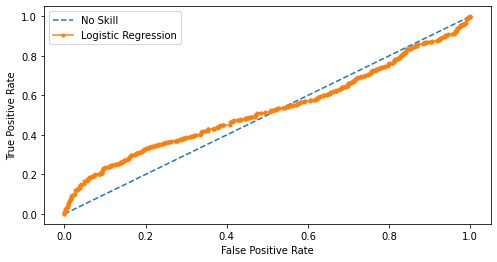

In [109]:
# generating ROC curve
ROC_AUC_curve(model=lr_model,model_name="Logistic Regression")

### LR coefficients

- As we have used the l2 regularization paramater, we can see that the coefficients for features are close to zero but not exactly zero 
- We can also conclude that 'MouthAspectRatio' has the highest coefficient indicating that 'MouthAspectRatio' increases the odds of having the Drowsy state the most
- Similarly, we can conclude that 'EyeAspectRatio' - increases the odds of having the Drowsy state the least

In [110]:
# printing the coefficients of LR model
lr_coefficients=OrderedDict(sorted(zip(X_train.columns,grid_lr.best_estimator_.coef_[0]),reverse=True,key=lambda x:x[1]))

In [111]:
# printing the coefficients 
pd.Series(lr_coefficients)

MouthAspectRatio         0.311139
MouthAspectRatio_lag4    0.248463
MouthAspectRatio_lag1    0.224908
PupilCircularity         0.221994
MouthAspectRatio_lag2    0.191746
MouthAspectRatio_lag3    0.190136
PupilCircularity_lag2    0.179151
PupilCircularity_lag1    0.173472
PupilCircularity_lag3    0.167901
PupilCircularity_lag4    0.155633
MouthOverEye_lag3       -0.214881
MouthOverEye_lag2       -0.234060
MouthOverEye_lag1       -0.246039
MouthOverEye_lag4       -0.285186
MouthOverEye            -0.336354
EyeAspectRatio_lag3     -0.624464
EyeAspectRatio_lag2     -0.656714
EyeAspectRatio_lag1     -0.666699
EyeAspectRatio_lag4     -0.703678
EyeAspectRatio          -0.830758
dtype: float64

### Naive Bayes

- Naive Bayes model performed with the below performance on the testing dataset:
- Accuracy: 44%
- Precision: 53%
- Recall: 45%
- F1-Score: 49%
- AUC: 43.4%

In [112]:
# initializing the gaussian naive bayes model
gnb = GaussianNB()

In [113]:
# Performing grid search to find the best hyper-parameters
param_grid_gnb = {
              'var_smoothing': [.001,.005,.01,0.1,0.3]
              }

In [114]:
# Using 5 fold cross validation and evaluation metric as Recall
grid_gnb = GridSearchCV(gnb, param_grid_gnb, cv=5, scoring='recall', n_jobs=-1, verbose=1)

In [115]:
# Fitting NBC model
gnb_model = grid_gnb.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.5s finished


In [116]:
# printing best hyper-parameters for model
gnb_best_params = grid_gnb.best_params_
print(gnb_best_params)

{'var_smoothing': 0.001}


In [117]:
# Printing classification report for predictions made by model on training dataset
print(classification_report(gnb_model.predict(X_train),y_train))

              precision    recall  f1-score   support

           0       0.78      0.75      0.76      3930
           1       0.73      0.77      0.75      3574

    accuracy                           0.76      7504
   macro avg       0.76      0.76      0.76      7504
weighted avg       0.76      0.76      0.76      7504



In [118]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(gnb_model.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.36      0.43      0.39       446
           1       0.53      0.45      0.49       626

    accuracy                           0.44      1072
   macro avg       0.44      0.44      0.44      1072
weighted avg       0.46      0.44      0.45      1072



No Skill: ROC AUC=0.500
Model: ROC AUC=0.434


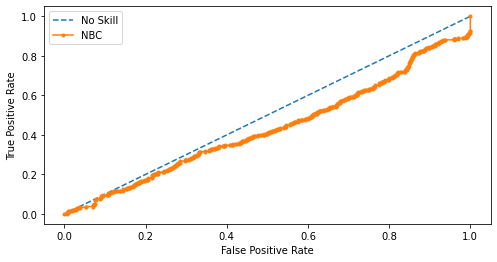

In [119]:
# printing the AUC-ROC for NBC model
ROC_AUC_curve(model=gnb_model,model_name="NBC")

### Decision Trees

- DT model performed with the below performance on the testing dataset:
- Accuracy: 43%
- Precision: 65%
- Recall: 45%
- F1-Score: 53%
- AUC: 44.2%

In [120]:
# initializing the DT model
dt=DecisionTreeClassifier(random_state=42)

In [121]:
# Using grid search for hyper-parameter tuning
param_grid_dt = { 'criterion':['gini','entropy'],
                 'max_features': ['auto','log2'],
              'min_samples_split':[25,50,100,200],
              'max_depth': [5,10,20,25,30],
              'min_samples_leaf': [1,3,5,10,20],
              'max_leaf_nodes': [2,5,10,20,40]}

In [122]:
# Using grid search and evaluation metric as Recall
grid_dt = GridSearchCV(dt, param_grid_dt, scoring='recall', n_jobs=-1, verbose=1)

In [123]:
# Fitting dt model
dt_model = grid_dt.fit(X_train, y_train)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 6018 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 8418 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 9768 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 10000 out of 1000

In [124]:
# printing the best hyper-parameters
dt_best_params = grid_dt.best_params_
print(dt_best_params)

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': 40, 'min_samples_leaf': 1, 'min_samples_split': 25}


In [125]:
# Printing classification report for predictions made by model on training dataset
print(classification_report(dt_model.predict(X_train),y_train))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87      3886
           1       0.85      0.88      0.87      3618

    accuracy                           0.87      7504
   macro avg       0.87      0.87      0.87      7504
weighted avg       0.87      0.87      0.87      7504



In [126]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(dt_model.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.21      0.37      0.26       299
           1       0.65      0.45      0.53       773

    accuracy                           0.43      1072
   macro avg       0.43      0.41      0.40      1072
weighted avg       0.52      0.43      0.46      1072



No Skill: ROC AUC=0.500
Model: ROC AUC=0.442


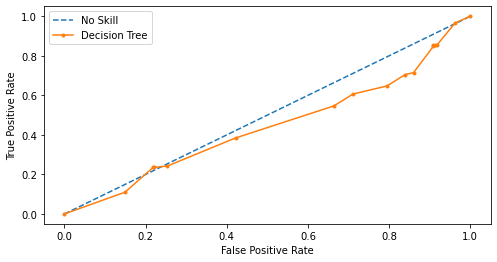

In [127]:
# ROC curve for DT model
ROC_AUC_curve(model=dt_model,model_name="Decision Tree")

### Feature importance

- According to DT model, the top 10 features that are most helpful in predicting the Drowsy state are:

- MouthOverEye_lag2
- MouthAspectRatio_lag3
- EyeAspectRatio_lag3
- EyeAspectRatio_lag4
- PupilCircularity_lag4
- MouthOverEye_lag4
- MouthOverEye_lag1
- MouthAspectRatio_lag4
- MouthAspectRatio_lag2
- EyeAspectRatio


In [128]:
# creating a new dataframe to store the features and their respective importance values
feature_imp = pd.DataFrame(dt_model.best_estimator_.feature_importances_, index=X_train.columns,
columns=['importance']).sort_values('importance', ascending=False)
feature_imp['features'] = feature_imp.index
feature_imp

,importance,features
MouthOverEye_lag2,0.313990,MouthOverEye_lag2
MouthAspectRatio_lag3,0.211376,MouthAspectRatio_lag3
EyeAspectRatio_lag3,0.139352,EyeAspectRatio_lag3
EyeAspectRatio_lag4,0.055812,EyeAspectRatio_lag4
PupilCircularity_lag4,0.053202,PupilCircularity_lag4
MouthOverEye_lag4,0.040742,MouthOverEye_lag4
MouthOverEye_lag1,0.035288,MouthOverEye_lag1
MouthAspectRatio_lag4,0.029213,MouthAspectRatio_lag4
MouthAspectRatio_lag2,0.024075,MouthAspectRatio_lag2
EyeAspectRatio,0.019205,EyeAspectRatio


Text(0, 0.5, 'FEATURE NAMES')

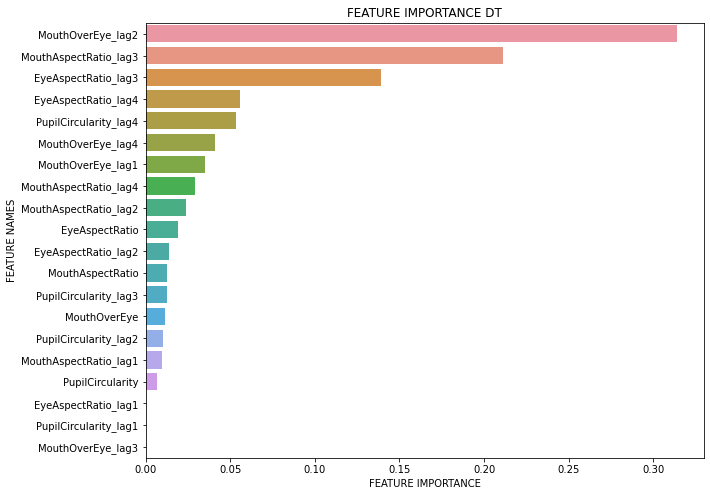

In [129]:
# Plotting Feature Importance graph
plt.figure(figsize=(10,8))

sns.barplot(x=feature_imp['importance'], y=feature_imp['features'])

plt.title('FEATURE IMPORTANCE DT')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')

### Artificial Neural Networks with 1 hidden layer

- ANN model performed with the below performance on the testing dataset:
- Accuracy: 43%
- Precision: 44%
- Recall: 56%
- F1-Score: 49%


In [40]:
# initializing the ANN1 model
ann1 = Sequential()
ann1.add(Dense(40, activation='relu', input_shape=(20,)))
ann1.add(Dense(1, activation='sigmoid', input_shape=(40,)))

In [41]:
# compiling ANN1 model
ann1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
# fitting ANN1 model
ann1.fit(X_train, y_train, epochs=5, batch_size=20, verbose=1,validation_data=(X_test,y_test))

Epoch 1/5
376/376 [==============================] - 12s 31ms/step - loss: 0.3755 - accuracy: 0.8356 - val_loss: 0.9703 - val_accuracy: 0.4394
Epoch 2/5
376/376 [==============================] - 12s 32ms/step - loss: 0.3581 - accuracy: 0.8441 - val_loss: 1.0281 - val_accuracy: 0.4328
Epoch 3/5
376/376 [==============================] - 8s 22ms/step - loss: 0.3419 - accuracy: 0.8555 - val_loss: 1.1153 - val_accuracy: 0.4216
Epoch 4/5
376/376 [==============================] - 6s 17ms/step - loss: 0.3279 - accuracy: 0.8669 - val_loss: 1.1117 - val_accuracy: 0.4254
Epoch 5/5
376/376 [==============================] - 5s 13ms/step - loss: 0.3150 - accuracy: 0.8717 - val_loss: 1.1967 - val_accuracy: 0.4179


In [44]:
# Printing classification report for predictions made by model on training dataset
print(classification_report(y_true=y_train,y_pred=(ann1.predict(X_train)>0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      3752
           1       0.91      0.84      0.87      3752

    accuracy                           0.88      7504
   macro avg       0.88      0.88      0.88      7504
weighted avg       0.88      0.88      0.88      7504



In [45]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(y_true=y_test,y_pred=(ann1.predict(X_test)>0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.37      0.23      0.28       536
           1       0.44      0.61      0.51       536

    accuracy                           0.42      1072
   macro avg       0.40      0.42      0.40      1072
weighted avg       0.40      0.42      0.40      1072



Instructions for updating:
Please use `model.predict()` instead.
No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.459


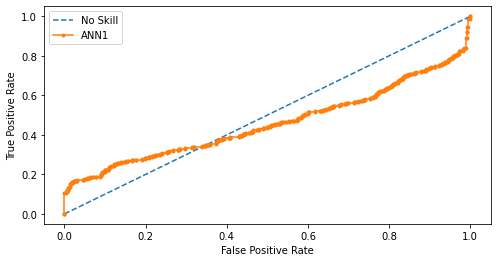

In [46]:
# generating ROC curve for ANN0
ROC_AUC_curve_upgraded(model=ann1,model_name="ANN1")

### K-Nearest Neighbors

- KNN model performed with the below performance on the testing dataset:
- Accuracy: 43%
- Precision: 76%
- Recall: 46%
- F1-Score: 57%


In [135]:
# initializing the model
knn = KNeighborsClassifier()

In [136]:
# Performing grid search to find the best hyper-parameters
param_grid_knn = { 'n_neighbors':[50,100,150,200],
              'weights':['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]
              }

In [137]:
# Using grid search and evaluation metric as Recall
grid_knn = GridSearchCV(knn, param_grid_knn, scoring='recall', n_jobs=-1)

In [138]:
# Fitting knn model
knn_model = grid_knn.fit(X_train, y_train)

In [139]:
# printing the best hyper-parameters
knn_best_params = knn_model.best_params_
print(knn_best_params)

{'algorithm': 'auto', 'n_neighbors': 200, 'p': 2, 'weights': 'uniform'}


In [140]:
# Printing classification report for predictions made by model on training dataset
print(classification_report(knn_model.predict(X_train),y_train))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85      3764
           1       0.84      0.85      0.85      3740

    accuracy                           0.85      7504
   macro avg       0.85      0.85      0.85      7504
weighted avg       0.85      0.85      0.85      7504



In [141]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(knn_model.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.10      0.29      0.15       181
           1       0.76      0.46      0.57       891

    accuracy                           0.43      1072
   macro avg       0.43      0.38      0.36      1072
weighted avg       0.65      0.43      0.50      1072



### Linear Support Vector Machine

- Linear SVM model performed with the below performance on the testing dataset:
- Accuracy: 48%
- Precision: 79%
- Recall: 49%
- F1-Score: 60%


In [142]:
# initializing the linear SVC model
lsvm = LinearSVC(random_state=16)

In [143]:
# Performing grid search to find the best hyper-parameters
param_grid_lsvm = { 'C':[.005,.01,.1,.2,.4,.8],
              'penalty':['l1', 'l2'],
              'loss': ['hinge', 'square_hinge']
              }

In [144]:
# Using 5 fold cross validation and evaluation metric as Recall
grid_lsvm = GridSearchCV(lsvm, param_grid_lsvm, cv=5, scoring='recall', n_jobs=-1)

In [145]:
# Fitting linear svc model
lsvm_model = grid_lsvm.fit(X_train, y_train)

/home/ssingh56/anaconda3/envs/production/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [146]:
# printing the best hyper-parameters
lsvm_best_params = grid_lsvm.best_params_
print(lsvm_best_params)

{'C': 0.8, 'loss': 'hinge', 'penalty': 'l2'}


In [147]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(lsvm_model.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.18      0.46      0.26       208
           1       0.79      0.49      0.60       864

    accuracy                           0.48      1072
   macro avg       0.48      0.47      0.43      1072
weighted avg       0.67      0.48      0.54      1072



### Random Forest

- RF model performed with the below performance on the testing dataset:
- Accuracy: 46%
- Precision: 74%
- Recall: 47%
- F1-Score: 58%
- AUC: 43.2%

In [148]:
# initializing the RF model
rf=RandomForestClassifier(random_state=16,n_jobs=-1,n_estimators=100)

In [149]:
# Performing grid search to find the best hyper-parameters
param_grid_rf = {'max_depth': [1,25,10, 20, 100],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [10,30,50,100],
             'min_samples_split': [10,50,100,200],
             'n_estimators': [25,50,100,200]}

In [152]:
# Using 5 fold cross validation and evaluation metric as Recall
grid_rf= GridSearchCV(rf, param_grid_rf, cv=5, scoring='recall', n_jobs=-1, verbose=1)

In [153]:
# Fitting RF model
rf_model = grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 640 candidates, totalling 3200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 3200 out of 3200 | elapsed:  9.0min finished


In [154]:
# printing the best hyper-parameters
rf_model_best_params = grid_rf.best_params_
print(rf_model_best_params)

{'max_depth': 1, 'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 25}


In [155]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(rf_model.predict(X_test),y_test))


              precision    recall  f1-score   support

           0       0.18      0.41      0.25       233
           1       0.74      0.47      0.58       839

    accuracy                           0.46      1072
   macro avg       0.46      0.44      0.41      1072
weighted avg       0.62      0.46      0.51      1072



No Skill: ROC AUC=0.500
Model: ROC AUC=0.432


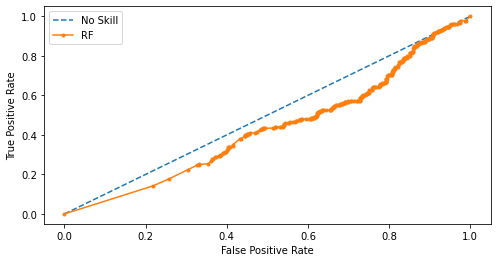

In [156]:
# ROC curve for RF model
ROC_AUC_curve(model=rf_model,model_name="RF")

### Feature importance
- According to RF model, the top 10 features that are most helpful in predicting the Drowsy state are:
- MouthOverEye_lag2
- EyeAspectRatio
- EyeAspectRatio_lag3
- MouthOverEye_lag1
- MouthOverEye_lag4
- EyeAspectRatio_lag1
- MouthOverEye_lag3
- EyeAspectRatio_lag4
- PupilCircularity_lag1
- PupilCircularity_lag2

In [157]:
# creating a new dataframe to store the features and their respective importance values
feature_imp = pd.DataFrame(rf_model.best_estimator_.feature_importances_, index=X_train.columns,
columns=['importance']).sort_values('importance', ascending=False)
feature_imp['features'] = feature_imp.index
feature_imp

,importance,features
MouthOverEye_lag2,0.16,MouthOverEye_lag2
EyeAspectRatio,0.12,EyeAspectRatio
EyeAspectRatio_lag3,0.12,EyeAspectRatio_lag3
MouthOverEye_lag1,0.12,MouthOverEye_lag1
MouthOverEye_lag4,0.12,MouthOverEye_lag4
EyeAspectRatio_lag1,0.08,EyeAspectRatio_lag1
MouthOverEye_lag3,0.08,MouthOverEye_lag3
EyeAspectRatio_lag4,0.04,EyeAspectRatio_lag4
PupilCircularity_lag1,0.04,PupilCircularity_lag1
PupilCircularity_lag2,0.04,PupilCircularity_lag2


Text(0, 0.5, 'FEATURE NAMES')

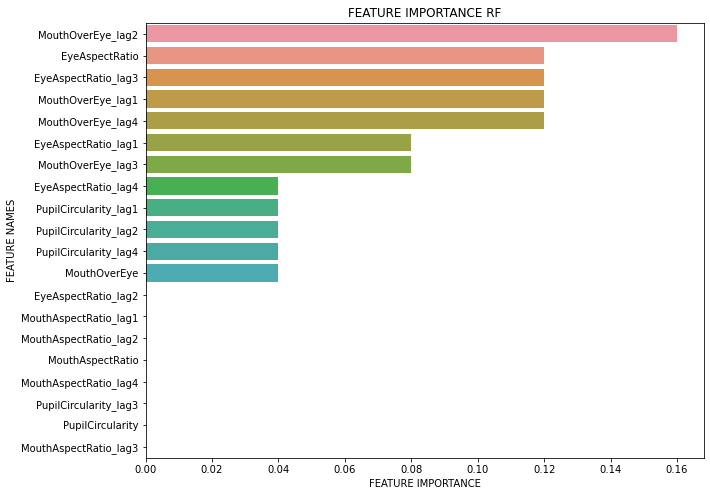

In [158]:
# Plotting Feature Importance graph
plt.figure(figsize=(10,8))

sns.barplot(x=feature_imp['importance'], y=feature_imp['features'])

plt.title('FEATURE IMPORTANCE RF')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')

In [168]:
# Save the trained model as a pickle string. 
saved_rf_model = pickle.dumps(rf_model) 
  
# Load the pickled model 
rf_from_pickle = pickle.loads(saved_rf_model) 

### Gradient Boosting Machine

- GBM model performed with the below performance on the testing dataset:
- Accuracy: 41%
- Precision: 68%
- Recall: 44%
- F1-Score: 54%
- AUC: 34.9%

In [159]:
# initializing the GBM model
gbm=GradientBoostingClassifier(random_state=16)

In [160]:
# Performing grid search to find the best hyper-parameters
param_grid_gbm = {'max_features': ['auto','sqrt'],
              'n_estimators': [20,50,100,200],
              'subsample':[0.6,0.8,0.9],
              'max_depth': [1,5,20,10,50,100],
              'min_samples_split':[25,50,100,200],
              'min_samples_leaf':[10,30,50,100]}

In [161]:
# Using 5 fold cross validation and evaluation metric as Recall
grid_gbm= GridSearchCV(gbm, param_grid_gbm, cv=5, scoring='recall', n_jobs=-1, verbose=1)

In [162]:
# Fitting GBM model
gbm_model = grid_gbm.fit(X_train, y_train)

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed: 39.7min
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed: 71.9min
[Parallel(n_jobs=-1)]: Done 6018 tasks      | elapsed: 91.4min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed: 117.1min
[Parallel(n_jobs=-1)]: Done 8418 tasks      | elapsed: 170.5min
[Parallel(n_jobs=-1)]: Done 9768 tasks      | elapsed: 208.4min
[Parallel(n_jobs=-1)]: Done 11218 tasks   

In [163]:
# printing the best hyper-parameters
gbm_best_params = grid_gbm.best_params_
print(gbm_best_params)

{'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 100, 'min_samples_split': 25, 'n_estimators': 200, 'subsample': 0.8}


In [164]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(gbm_model.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.14      0.31      0.20       249
           1       0.68      0.44      0.54       823

    accuracy                           0.41      1072
   macro avg       0.41      0.38      0.37      1072
weighted avg       0.55      0.41      0.46      1072



No Skill: ROC AUC=0.500
Model: ROC AUC=0.349


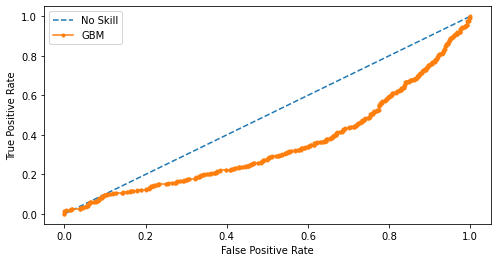

In [165]:
# printing AUC curve for GBM model
ROC_AUC_curve(model=gbm_model,model_name="GBM")

### Feature importance
- According to GBM model, the top 10 features that are most helpful in predicting the Drowsy state are:
- MouthOverEye_lag2
- MouthOverEye
- MouthOverEye_lag3
- MouthOverEye_lag1
- MouthOverEye_lag4
- EyeAspectRatio_lag3
- MouthAspectRatio_lag1
- MouthAspectRatio
- EyeAspectRatio_lag4
- MouthAspectRatio_lag4

In [166]:
# creating a new dataframe to store the features and their respective importance values
feature_imp = pd.DataFrame(gbm_model.best_estimator_.feature_importances_, index=X_train.columns,
columns=['importance']).sort_values('importance', ascending=False)
feature_imp['features'] = feature_imp.index
feature_imp

,importance,features
MouthOverEye_lag2,0.101073,MouthOverEye_lag2
MouthOverEye,0.089399,MouthOverEye
MouthOverEye_lag3,0.082456,MouthOverEye_lag3
MouthOverEye_lag1,0.072824,MouthOverEye_lag1
MouthOverEye_lag4,0.066141,MouthOverEye_lag4
EyeAspectRatio_lag3,0.058003,EyeAspectRatio_lag3
MouthAspectRatio_lag1,0.056314,MouthAspectRatio_lag1
MouthAspectRatio,0.052182,MouthAspectRatio
EyeAspectRatio_lag4,0.048928,EyeAspectRatio_lag4
MouthAspectRatio_lag4,0.048520,MouthAspectRatio_lag4


Text(0, 0.5, 'FEATURE NAMES')

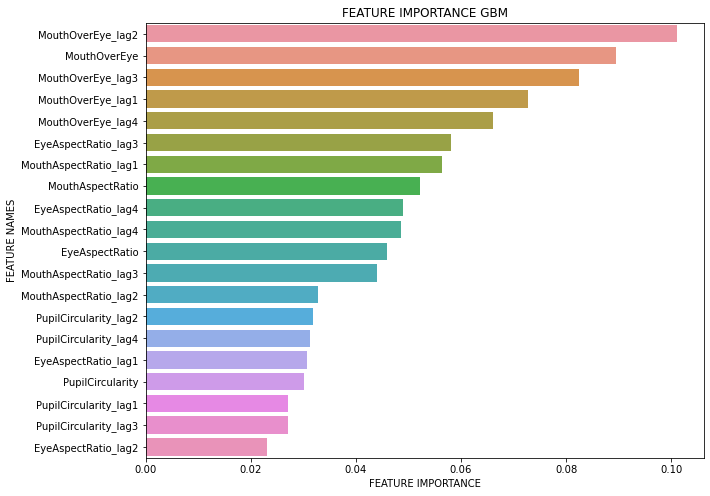

In [167]:
# Plotting Feature Importance graph
plt.figure(figsize=(10,8))

sns.barplot(x=feature_imp['importance'], y=feature_imp['features'])

plt.title('FEATURE IMPORTANCE GBM')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')

In [169]:
# Save the trained model as a pickle string. 
saved_gbm_model = pickle.dumps(gbm_model) 
  
# Load the pickled model 
gbm_from_pickle = pickle.loads(saved_gbm_model) 

### Simple Feed Forward Neural Network

In [178]:
# Time Complexity function
class TimeComplexity(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

### Architecture1 - 1 hidden layer - d-2d, optimizer=SGD, activation=relu, epochs=5, batch_size=20

### Run1

In [43]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 7s 20ms/step - loss: 0.5502 - accuracy: 0.7559 - val_loss: 0.8417 - val_accuracy: 0.4188
Epoch 2/5
376/376 [==============================] - 10s 25ms/step - loss: 0.5051 - accuracy: 0.7821 - val_loss: 0.8563 - val_accuracy: 0.4114
Epoch 3/5
376/376 [==============================] - 10s 27ms/step - loss: 0.4860 - accuracy: 0.7901 - val_loss: 0.8746 - val_accuracy: 0.4198
Epoch 4/5
376/376 [==============================] - 9s 24ms/step - loss: 0.4741 - accuracy: 0.7980 - val_loss: 0.8664 - val_accuracy: 0.4310
Epoch 5/5
376/376 [==============================] - 9s 25ms/step - loss: 0.4649 - accuracy: 0.8002 - val_loss: 0.8812 - val_accuracy: 0.4282


In [44]:
# Calculating the final validation mse
bp_validation_error1 = history_bp.history['val_loss']
print('Final Validation Loss for Plain Backpropagation Model for 1st Run:', bp_validation_error1[-1] )

# Calculating the final validation accracy
bp_validation_acc1 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Plain Backpropagation Model for 1st Run:', bp_validation_acc1[-1] )


# Calculating the time complexity
bp_time_complexity1 = sum(time_bp)
print('Time complexity for Plain Backpropagation Model for 1st Run:', bp_time_complexity1,'seconds')

Final Validation Loss for Plain Backpropagation Model for 1st Run: 0.8812460899353027
Final Validation Accuracy for Plain Backpropagation Model for 1st Run: 0.42817163467407227
Time complexity for Plain Backpropagation Model for 1st Run: 46.80898175283801 seconds


### Run2

In [45]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 10s 28ms/step - loss: 0.5590 - accuracy: 0.7340 - val_loss: 0.8778 - val_accuracy: 0.3993
Epoch 2/5
376/376 [==============================] - 11s 29ms/step - loss: 0.5123 - accuracy: 0.7677 - val_loss: 0.8907 - val_accuracy: 0.4039
Epoch 3/5
376/376 [==============================] - 10s 26ms/step - loss: 0.4960 - accuracy: 0.7849 - val_loss: 0.9062 - val_accuracy: 0.4132
Epoch 4/5
376/376 [==============================] - 9s 25ms/step - loss: 0.4846 - accuracy: 0.7932 - val_loss: 0.8936 - val_accuracy: 0.4207
Epoch 5/5
376/376 [==============================] - 10s 27ms/step - loss: 0.4751 - accuracy: 0.7973 - val_loss: 0.9033 - val_accuracy: 0.4198


In [46]:
# Calculating the final validation mse
bp_validation_error2 = history_bp.history['val_loss']
print('Final Validation Loss for Plain Backpropagation Model for 2nd Run:', bp_validation_error2[-1] )

# Calculating the final validation accracy
bp_validation_acc2 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Plain Backpropagation Model for 2nd Run:', bp_validation_acc2[-1] )


# Calculating the time complexity
bp_time_complexity2 = sum(time_bp)
print('Time complexity for Plain Backpropagation Model for 2nd Run:', bp_time_complexity2,'seconds')

Final Validation Loss for Plain Backpropagation Model for 2nd Run: 0.903296947479248
Final Validation Accuracy for Plain Backpropagation Model for 2nd Run: 0.4197761118412018
Time complexity for Plain Backpropagation Model for 2nd Run: 51.21204651298467 seconds


### Run3

In [47]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 8s 20ms/step - loss: 0.5832 - accuracy: 0.6990 - val_loss: 0.8540 - val_accuracy: 0.4058
Epoch 2/5
376/376 [==============================] - 9s 24ms/step - loss: 0.5141 - accuracy: 0.7643 - val_loss: 0.8665 - val_accuracy: 0.4188
Epoch 3/5
376/376 [==============================] - 8s 21ms/step - loss: 0.4937 - accuracy: 0.7771 - val_loss: 0.8784 - val_accuracy: 0.4356
Epoch 4/5
376/376 [==============================] - 7s 20ms/step - loss: 0.4800 - accuracy: 0.7873 - val_loss: 0.8723 - val_accuracy: 0.4394
Epoch 5/5
376/376 [==============================] - 8s 22ms/step - loss: 0.4690 - accuracy: 0.7881 - val_loss: 0.8856 - val_accuracy: 0.4431


In [48]:
# Calculating the final validation mse
bp_validation_error3 = history_bp.history['val_loss']
print('Final Validation Loss for Plain Backpropagation Model for 3rd Run:', bp_validation_error3[-1] )

# Calculating the final validation accracy
bp_validation_acc3 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Plain Backpropagation Model for 3rd Run:', bp_validation_acc3[-1] )


# Calculating the time complexity
bp_time_complexity3 = sum(time_bp)
print('Time complexity for Plain Backpropagation Model for 3rd Run:', bp_time_complexity3,'seconds')

Final Validation Loss for Plain Backpropagation Model for 3rd Run: 0.8856353163719177
Final Validation Accuracy for Plain Backpropagation Model for 3rd Run: 0.4430970251560211
Time complexity for Plain Backpropagation Model for 3rd Run: 40.67595023103058 seconds


### Run4

In [49]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 8s 20ms/step - loss: 0.5815 - accuracy: 0.7184 - val_loss: 0.8123 - val_accuracy: 0.4328
Epoch 2/5
376/376 [==============================] - 7s 20ms/step - loss: 0.5196 - accuracy: 0.7684 - val_loss: 0.8363 - val_accuracy: 0.4179
Epoch 3/5
376/376 [==============================] - 9s 23ms/step - loss: 0.4966 - accuracy: 0.7821 - val_loss: 0.8522 - val_accuracy: 0.4263
Epoch 4/5
376/376 [==============================] - 8s 22ms/step - loss: 0.4813 - accuracy: 0.7949 - val_loss: 0.8485 - val_accuracy: 0.4300
Epoch 5/5
376/376 [==============================] - 10s 28ms/step - loss: 0.4699 - accuracy: 0.7972 - val_loss: 0.8663 - val_accuracy: 0.4282


In [50]:
# Calculating the final validation mse
bp_validation_error4 = history_bp.history['val_loss']
print('Final Validation Loss for Plain Backpropagation Model for 4th Run:', bp_validation_error4[-1] )

# Calculating the final validation accracy
bp_validation_acc4 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Plain Backpropagation Model for 4th Run:', bp_validation_acc4[-1] )


# Calculating the time complexity
bp_time_complexity4 = sum(time_bp)
print('Time complexity for Plain Backpropagation Model for 4th Run:', bp_time_complexity4,'seconds')

Final Validation Loss for Plain Backpropagation Model for 4th Run: 0.8662537932395935
Final Validation Accuracy for Plain Backpropagation Model for 4th Run: 0.42817163467407227
Time complexity for Plain Backpropagation Model for 4th Run: 42.923556082183495 seconds


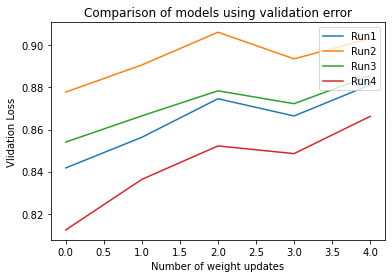

In [51]:
# Plotting validation loss of all the trials vs the Number of weight updates
plt.plot(bp_validation_error1)
plt.plot(bp_validation_error2)
plt.plot(bp_validation_error3)
plt.plot(bp_validation_error4)
plt.title('Comparison of models using validation error')
plt.ylabel('Vlidation Loss')
plt.xlabel('Number of weight updates')
plt.legend(['Run1', 'Run2', 'Run3', 'Run4'], loc='upper right')
plt.show()

In [52]:
# Storing the final validation for all models in a list
lowest_loss_obtained = [bp_validation_error1[-1],bp_validation_error2[-1],bp_validation_error3[-1],bp_validation_error4[-1]]

# Storing the time complexities for all models in a list
time_complexities = [bp_time_complexity1,bp_time_complexity2,bp_time_complexity3,bp_time_complexity4]

# Creating a list with all the model names
models = ['Run1', 'Run2', 'Run3', 'Run4']

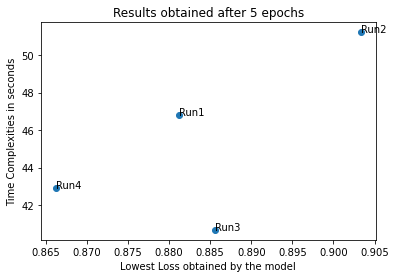

In [55]:
# Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation error
fig,ax = plt.subplots()
ax.scatter(lowest_loss_obtained, time_complexities)

plt.title('Results obtained after 5 epochs')
plt.ylabel('Time Complexities in seconds')
plt.xlabel('Lowest Loss obtained by the model')

for x,y in enumerate(models):
    ax.annotate(y, (lowest_loss_obtained[x], time_complexities[x]))    

In [65]:
architecture1_mean = statistics.mean(lowest_loss_obtained)
print('Architecture1 Validation Loss Mean: ', architecture1_mean)

Architecture1 Validation Loss Mean:  0.8841080367565155


In [66]:
architecture1_stddev = statistics.stdev(lowest_loss_obtained)
print('Architecture1 Validation Loss Std Dev: ', architecture1_stddev)

Architecture1 Validation Loss Std Dev:  0.015248077790524114


In [67]:
architecture1_time_mean = statistics.mean(time_complexities)
print('Architecture1 Time Complexity Mean: ', architecture1_time_mean)

Architecture1 Time Complexity Mean:  45.40513364475919


In [68]:
acc_list = [bp_validation_acc1[-1],bp_validation_acc2[-1],bp_validation_acc3[-1],bp_validation_acc4[-1]]
architecture1_acc_mean = statistics.mean(acc_list)
print('Architecture1 Validation Accuracy Mean: ', architecture1_acc_mean*100)

Architecture1 Validation Accuracy Mean:  42.980410158634186


### Architecture2 - 2 hidden layers - 1st hidden layer=40 nodes, 2nd hidden layer=20 nodes, epochs=5, batch_size=20, optimizer=adam, activation=tanh

### Run1

In [69]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(20, input_dim=40, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 9s 23ms/step - loss: 0.4929 - accuracy: 0.7637 - val_loss: 1.0834 - val_accuracy: 0.4207
Epoch 2/5
376/376 [==============================] - 9s 25ms/step - loss: 0.4238 - accuracy: 0.8018 - val_loss: 1.1405 - val_accuracy: 0.4384
Epoch 3/5
376/376 [==============================] - 12s 33ms/step - loss: 0.3896 - accuracy: 0.8256 - val_loss: 1.3034 - val_accuracy: 0.4263
Epoch 4/5
376/376 [==============================] - 12s 32ms/step - loss: 0.3626 - accuracy: 0.8526 - val_loss: 1.4197 - val_accuracy: 0.4198
Epoch 5/5
376/376 [==============================] - 10s 28ms/step - loss: 0.3383 - accuracy: 0.8670 - val_loss: 1.5219 - val_accuracy: 0.4226


In [70]:
# Calculating the final validation mse
bp_validation_error1 = history_bp.history['val_loss']
print('Final Validation MSE for Plain Backpropagation Model for 1st Run:', bp_validation_error1[-1] )

# Calculating the final validation accracy
bp_validation_acc1 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Plain Backpropagation Model for 1st Run:', bp_validation_acc1[-1] )


# Calculating the time complexity
bp_time_complexity1 = sum(time_bp)
print('Time complexity for Plain Backpropagation Model for 1st Run:', bp_time_complexity1,'seconds')

Final Validation MSE for Plain Backpropagation Model for 1st Run: 1.5218759775161743
Final Validation Accuracy for Plain Backpropagation Model for 1st Run: 0.42257463932037354
Time complexity for Plain Backpropagation Model for 1st Run: 54.04596387897618 seconds


### Run2

In [71]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(20, input_dim=40, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 17s 44ms/step - loss: 0.5108 - accuracy: 0.7665 - val_loss: 0.8898 - val_accuracy: 0.4450
Epoch 2/5
376/376 [==============================] - 13s 36ms/step - loss: 0.4096 - accuracy: 0.8217 - val_loss: 0.9918 - val_accuracy: 0.4347
Epoch 3/5
376/376 [==============================] - 15s 41ms/step - loss: 0.3476 - accuracy: 0.8547 - val_loss: 1.0772 - val_accuracy: 0.4291
Epoch 4/5
376/376 [==============================] - 14s 38ms/step - loss: 0.3099 - accuracy: 0.8730 - val_loss: 1.1568 - val_accuracy: 0.4207
Epoch 5/5
376/376 [==============================] - 13s 36ms/step - loss: 0.2855 - accuracy: 0.8807 - val_loss: 1.2261 - val_accuracy: 0.4272


In [72]:
# Calculating the final validation mse
bp_validation_error2 = history_bp.history['val_loss']
print('Final Validation Loss for Plain Backpropagation Model for 2nd Run:', bp_validation_error2[-1] )

# Calculating the final validation accracy
bp_validation_acc2 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Plain Backpropagation Model for 2nd Run:', bp_validation_acc2[-1] )


# Calculating the time complexity
bp_time_complexity2 = sum(time_bp)
print('Time complexity for Plain Backpropagation Model for 2nd Run:', bp_time_complexity2,'seconds')

Final Validation MSE for Plain Backpropagation Model for 2nd Run: 1.2260559797286987
Final Validation Accuracy for Plain Backpropagation Model for 2nd Run: 0.427238792181015
Time complexity for Plain Backpropagation Model for 2nd Run: 73.97496059304103 seconds


### Run3

In [73]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(20, input_dim=40, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 13s 35ms/step - loss: 0.4908 - accuracy: 0.7671 - val_loss: 1.0550 - val_accuracy: 0.4263
Epoch 2/5
376/376 [==============================] - 13s 33ms/step - loss: 0.4212 - accuracy: 0.8006 - val_loss: 1.0797 - val_accuracy: 0.4431
Epoch 3/5
376/376 [==============================] - 12s 32ms/step - loss: 0.3862 - accuracy: 0.8286 - val_loss: 1.2281 - val_accuracy: 0.4216
Epoch 4/5
376/376 [==============================] - 11s 28ms/step - loss: 0.3635 - accuracy: 0.8495 - val_loss: 1.4085 - val_accuracy: 0.4319
Epoch 5/5
376/376 [==============================] - 11s 28ms/step - loss: 0.3444 - accuracy: 0.8643 - val_loss: 1.5083 - val_accuracy: 0.4235


In [75]:
# Calculating the final validation mse
bp_validation_error3 = history_bp.history['val_loss']
print('Final Validation Loss for Plain Backpropagation Model for 3rd Run:', bp_validation_error3[-1] )

# Calculating the final validation accracy
bp_validation_acc3 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Plain Backpropagation Model for 3rd Run:', bp_validation_acc3[-1] )

# Calculating the time complexity
bp_time_complexity3 = sum(time_bp)
print('Time complexity for Plain Backpropagation Model for 3rd Run:', bp_time_complexity3,'seconds')

Final Validation Loss for Plain Backpropagation Model for 3rd Run: 1.5082981586456299
Final Validation Accuracy for Plain Backpropagation Model for 3rd Run: 0.4235074520111084
Time complexity for Plain Backpropagation Model for 3rd Run: 60.09856646810658 seconds


### Run4

In [76]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(20, input_dim=40, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 13s 34ms/step - loss: 0.4857 - accuracy: 0.7680 - val_loss: 1.0649 - val_accuracy: 0.4142
Epoch 2/5
376/376 [==============================] - 12s 31ms/step - loss: 0.4262 - accuracy: 0.8008 - val_loss: 1.1002 - val_accuracy: 0.4272
Epoch 3/5
376/376 [==============================] - 11s 30ms/step - loss: 0.3919 - accuracy: 0.8261 - val_loss: 1.2243 - val_accuracy: 0.4226
Epoch 4/5
376/376 [==============================] - 11s 29ms/step - loss: 0.3627 - accuracy: 0.8490 - val_loss: 1.3165 - val_accuracy: 0.4207
Epoch 5/5
376/376 [==============================] - 11s 29ms/step - loss: 0.3373 - accuracy: 0.8651 - val_loss: 1.4023 - val_accuracy: 0.4347


In [77]:
# Calculating the final validation mse
bp_validation_error4 = history_bp.history['val_loss']
print('Final Validation Loss for Plain Backpropagation Model for 4th Run:', bp_validation_error4[-1] )

# Calculating the final validation accracy
bp_validation_acc4 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Plain Backpropagation Model for 4th Run:', bp_validation_acc4[-1] )

# Calculating the time complexity
bp_time_complexity4 = sum(time_bp)
print('Time complexity for Plain Backpropagation Model for 4th Run:', bp_time_complexity4,'seconds')

Final Validation Loss for Plain Backpropagation Model for 4th Run: 1.4023444652557373
Final Validation Accuracy for Plain Backpropagation Model for 4th Run: 0.43470150232315063
Time complexity for Plain Backpropagation Model for 4th Run: 58.90296723484062 seconds


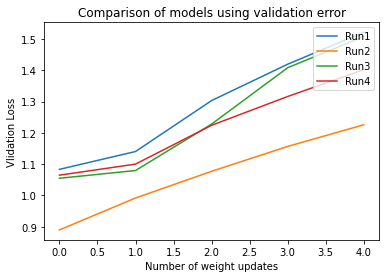

In [78]:
# Plotting validation loss of all the trials vs the Number of weight updates
plt.plot(bp_validation_error1)
plt.plot(bp_validation_error2)
plt.plot(bp_validation_error3)
plt.plot(bp_validation_error4)
plt.title('Comparison of models using validation error')
plt.ylabel('Vlidation Loss')
plt.xlabel('Number of weight updates')
plt.legend(['Run1', 'Run2', 'Run3', 'Run4'], loc='upper right')
plt.show()

In [79]:
# Storing the final validation for all models in a list
lowest_loss_obtained = [bp_validation_error1[-1],bp_validation_error2[-1],bp_validation_error3[-1],bp_validation_error4[-1]]

# Storing the time complexities for all models in a list
time_complexities = [bp_time_complexity1,bp_time_complexity2,bp_time_complexity3,bp_time_complexity4]

# Creating a list with all the model names
models = ['Run1', 'Run2', 'Run3', 'Run4']

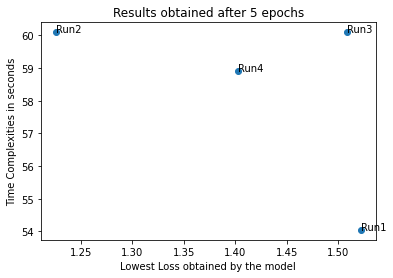

In [80]:
# Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation error
fig,ax = plt.subplots()
ax.scatter(lowest_loss_obtained, time_complexities)

plt.title('Results obtained after 5 epochs')
plt.ylabel('Time Complexities in seconds')
plt.xlabel('Lowest Loss obtained by the model')

for x,y in enumerate(models):
    ax.annotate(y, (lowest_loss_obtained[x], time_complexities[x]))    

In [81]:
architecture2_mean = statistics.mean(lowest_loss_obtained)
print('Architecture2 Validation Loss Mean: ', architecture2_mean)

Architecture2 Validation Loss Mean:  1.41464364528656


In [82]:
architecture2_stddev = statistics.stdev(lowest_loss_obtained)
print('Architecture2 Validation Loss Std Dev: ', architecture2_stddev)

Architecture2 Validation Loss Std Dev:  0.13660956332790286


In [83]:
architecture2_time_mean = statistics.mean(time_complexities)
print('Architecture2 Time Complexity Mean: ', architecture2_time_mean)

Architecture2 Time Complexity Mean:  58.28651601250749


In [84]:
acc_list = [bp_validation_acc1[-1],bp_validation_acc2[-1],bp_validation_acc3[-1],bp_validation_acc4[-1]]
architecture2_acc_mean = statistics.mean(acc_list)
print('Architecture2 Validation Accuracy Mean: ', architecture2_acc_mean*100)

Architecture2 Validation Accuracy Mean:  42.70055964589119


### Architecture3 - 3 hidden layers - 1st hidden layer=40 nodes, 2nd hidden layer=20 nodes, 3rd hidden layer=10 nodes, epochs=5, batch_size=20, optimizer=adam, activation=relu

### Run1

In [86]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(20, input_dim=40, activation='relu'))
model_bp.add(Dense(10, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 16s 42ms/step - loss: 0.5016 - accuracy: 0.7725 - val_loss: 0.9025 - val_accuracy: 0.4450
Epoch 2/5
376/376 [==============================] - 18s 49ms/step - loss: 0.3944 - accuracy: 0.8153 - val_loss: 1.0243 - val_accuracy: 0.4319
Epoch 3/5
376/376 [==============================] - 19s 49ms/step - loss: 0.3443 - accuracy: 0.8256 - val_loss: 1.0751 - val_accuracy: 0.4207
Epoch 4/5
376/376 [==============================] - 17s 46ms/step - loss: 0.3173 - accuracy: 0.8601 - val_loss: 1.1602 - val_accuracy: 0.4272
Epoch 5/5
376/376 [==============================] - 19s 51ms/step - loss: 0.2967 - accuracy: 0.8762 - val_loss: 1.1226 - val_accuracy: 0.4328


In [87]:
# Calculating the final validation mse
bp_validation_error1 = history_bp.history['val_loss']
print('Final Validation MSE for Plain Backpropagation Model for 1st Run:', bp_validation_error1[-1] )

# Calculating the final validation accracy
bp_validation_acc1 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Plain Backpropagation Model for 1st Run:', bp_validation_acc1[-1] )


# Calculating the time complexity
bp_time_complexity1 = sum(time_bp)
print('Time complexity for Plain Backpropagation Model for 1st Run:', bp_time_complexity1,'seconds')

Final Validation MSE for Plain Backpropagation Model for 1st Run: 1.122620701789856
Final Validation Accuracy for Plain Backpropagation Model for 1st Run: 0.43283581733703613
Time complexity for Plain Backpropagation Model for 1st Run: 90.65810526406858 seconds


### Run2

In [88]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(20, input_dim=40, activation='relu'))
model_bp.add(Dense(10, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 12s 31ms/step - loss: 0.4897 - accuracy: 0.7747 - val_loss: 0.9607 - val_accuracy: 0.4263
Epoch 2/5
376/376 [==============================] - 18s 47ms/step - loss: 0.3797 - accuracy: 0.8212 - val_loss: 0.9814 - val_accuracy: 0.4300
Epoch 3/5
376/376 [==============================] - 16s 44ms/step - loss: 0.3351 - accuracy: 0.8330 - val_loss: 1.0669 - val_accuracy: 0.4366
Epoch 4/5
376/376 [==============================] - 13s 34ms/step - loss: 0.3075 - accuracy: 0.8593 - val_loss: 1.1571 - val_accuracy: 0.4412
Epoch 5/5
376/376 [==============================] - 8s 21ms/step - loss: 0.2850 - accuracy: 0.8751 - val_loss: 1.2557 - val_accuracy: 0.4328


In [89]:
# Calculating the final validation mse
bp_validation_error2 = history_bp.history['val_loss']
print('Final Validation Loss for Plain Backpropagation Model for 2nd Run:', bp_validation_error2[-1] )

# Calculating the final validation accracy
bp_validation_acc2 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Plain Backpropagation Model for 2nd Run:', bp_validation_acc2[-1] )


# Calculating the time complexity
bp_time_complexity2 = sum(time_bp)
print('Time complexity for Plain Backpropagation Model for 2nd Run:', bp_time_complexity2,'seconds')

Final Validation Loss for Plain Backpropagation Model for 2nd Run: 1.255661964416504
Final Validation Accuracy for Plain Backpropagation Model for 2nd Run: 0.43283581733703613
Time complexity for Plain Backpropagation Model for 2nd Run: 67.70605590310879 seconds


### Run3

In [90]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(20, input_dim=40, activation='relu'))
model_bp.add(Dense(10, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 15s 40ms/step - loss: 0.4809 - accuracy: 0.7882 - val_loss: 0.9546 - val_accuracy: 0.4272
Epoch 2/5
376/376 [==============================] - 18s 47ms/step - loss: 0.3751 - accuracy: 0.8353 - val_loss: 1.0326 - val_accuracy: 0.4450
Epoch 3/5
376/376 [==============================] - 14s 36ms/step - loss: 0.3198 - accuracy: 0.8694 - val_loss: 1.2703 - val_accuracy: 0.4179
Epoch 4/5
376/376 [==============================] - 17s 44ms/step - loss: 0.2808 - accuracy: 0.8859 - val_loss: 1.4665 - val_accuracy: 0.4403
Epoch 5/5
376/376 [==============================] - 16s 43ms/step - loss: 0.2592 - accuracy: 0.8910 - val_loss: 1.3666 - val_accuracy: 0.4440


In [91]:
# Calculating the final validation mse
bp_validation_error3 = history_bp.history['val_loss']
print('Final Validation Loss for Plain Backpropagation Model for 3rd Run:', bp_validation_error3[-1] )

# Calculating the final validation accracy
bp_validation_acc3 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Plain Backpropagation Model for 3rd Run:', bp_validation_acc3[-1] )

# Calculating the time complexity
bp_time_complexity3 = sum(time_bp)
print('Time complexity for Plain Backpropagation Model for 3rd Run:', bp_time_complexity3,'seconds')

Final Validation Loss for Plain Backpropagation Model for 3rd Run: 1.3665801286697388
Final Validation Accuracy for Plain Backpropagation Model for 3rd Run: 0.444029837846756
Time complexity for Plain Backpropagation Model for 3rd Run: 80.10545339994133 seconds


### Run4

In [92]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(20, input_dim=40, activation='relu'))
model_bp.add(Dense(10, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 15s 41ms/step - loss: 0.4964 - accuracy: 0.7739 - val_loss: 0.9288 - val_accuracy: 0.4440
Epoch 2/5
376/376 [==============================] - 17s 44ms/step - loss: 0.3814 - accuracy: 0.8398 - val_loss: 1.0460 - val_accuracy: 0.4226
Epoch 3/5
376/376 [==============================] - 14s 38ms/step - loss: 0.3194 - accuracy: 0.8695 - val_loss: 1.1619 - val_accuracy: 0.4104
Epoch 4/5
376/376 [==============================] - 13s 35ms/step - loss: 0.2841 - accuracy: 0.8831 - val_loss: 1.2965 - val_accuracy: 0.4188
Epoch 5/5
376/376 [==============================] - 15s 41ms/step - loss: 0.2657 - accuracy: 0.8914 - val_loss: 1.2934 - val_accuracy: 0.4282


In [93]:
# Calculating the final validation mse
bp_validation_error4 = history_bp.history['val_loss']
print('Final Validation Loss for Plain Backpropagation Model for 4th Run:', bp_validation_error4[-1] )

# Calculating the final validation accracy
bp_validation_acc4 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Plain Backpropagation Model for 4th Run:', bp_validation_acc4[-1] )

# Calculating the time complexity
bp_time_complexity4 = sum(time_bp)
print('Time complexity for Plain Backpropagation Model for 4th Run:', bp_time_complexity4,'seconds')

Final Validation Loss for Plain Backpropagation Model for 4th Run: 1.293393850326538
Final Validation Accuracy for Plain Backpropagation Model for 4th Run: 0.42817163467407227
Time complexity for Plain Backpropagation Model for 4th Run: 76.67233494995162 seconds


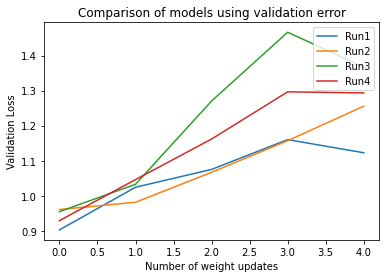

In [94]:
# Plotting validation loss of all the trials vs the Number of weight updates
plt.plot(bp_validation_error1)
plt.plot(bp_validation_error2)
plt.plot(bp_validation_error3)
plt.plot(bp_validation_error4)
plt.title('Comparison of models using validation error')
plt.ylabel('Validation Loss')
plt.xlabel('Number of weight updates')
plt.legend(['Run1', 'Run2', 'Run3', 'Run4'], loc='upper right')
plt.show()

In [95]:
# Storing the final validation for all models in a list
lowest_loss_obtained = [bp_validation_error1[-1],bp_validation_error2[-1],bp_validation_error3[-1],bp_validation_error4[-1]]

# Storing the time complexities for all models in a list
time_complexities = [bp_time_complexity1,bp_time_complexity2,bp_time_complexity3,bp_time_complexity4]

# Creating a list with all the model names
models = ['Run1', 'Run2', 'Run3', 'Run4']

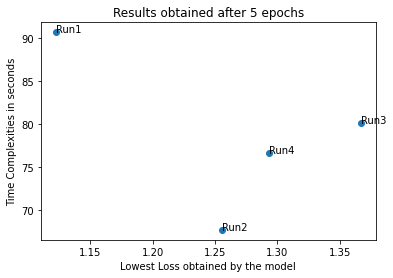

In [96]:
# Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation error
fig,ax = plt.subplots()
ax.scatter(lowest_loss_obtained, time_complexities)

plt.title('Results obtained after 5 epochs')
plt.ylabel('Time Complexities in seconds')
plt.xlabel('Lowest Loss obtained by the model')

for x,y in enumerate(models):
    ax.annotate(y, (lowest_loss_obtained[x], time_complexities[x]))    

In [97]:
architecture3_mean = statistics.mean(lowest_loss_obtained)
print('Architecture3 Validation Loss Mean: ', architecture3_mean)

Architecture3 Validation Loss Mean:  1.2595641613006592


In [98]:
architecture3_stddev = statistics.stdev(lowest_loss_obtained)
print('Architecture3 Validation Loss Std Dev: ', architecture3_stddev)

Architecture3 Validation Loss Std Dev:  0.10225067787034844


In [99]:
architecture3_time_mean = statistics.mean(time_complexities)
print('Architecture3 Time Complexity Mean: ', architecture3_time_mean)

Architecture3 Time Complexity Mean:  78.78548737926758


In [100]:
acc_list = [bp_validation_acc1[-1],bp_validation_acc2[-1],bp_validation_acc3[-1],bp_validation_acc4[-1]]
architecture3_acc_mean = statistics.mean(acc_list)
print('Architecture3 Validation Accuracy Mean: ', architecture3_acc_mean*100)

Architecture3 Validation Accuracy Mean:  43.44682767987251


In [103]:
# Creating a summary table for the model names, lowest MSE and their time complexities
model_summary = pd.DataFrame({"Model":["Plain Backpropagation Architecture1","Plain Backpropagation Architecture2",
                                       "Plain Backpropagation Architecture3"], "Mean Validation loss after 4 trials":[architecture1_mean,architecture2_mean,architecture3_mean],
                              "Mean Standard deviation after 4 trials":[architecture1_stddev,architecture2_stddev,architecture3_stddev],
                            "Mean Time Complexity in seconds after 4 trials":[architecture1_time_mean,architecture2_time_mean,architecture3_time_mean],
                              "Mean Validation Accuracy after 4 trials":[architecture1_acc_mean,architecture2_acc_mean,architecture3_acc_mean]
                                               })

In [104]:
model_summary

,Model,Mean Validation loss after 4 trials,Mean Standard deviation after 4 trials,Mean Time Complexity in seconds after 4 trials,Mean Validation Accuracy after 4 trials
0,Plain Backpropagation Architecture1,0.884108,0.015248,45.405134,0.429804
1,Plain Backpropagation Architecture2,1.414644,0.136610,58.286516,0.427006
2,Plain Backpropagation Architecture3,1.259564,0.102251,78.785487,0.434468


### Using Best Model - Plain Backpropagation Architecture1 - with - epochs=20

In [105]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=20, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/20
376/376 [==============================] - 10s 27ms/step - loss: 0.5769 - accuracy: 0.7188 - val_loss: 0.8297 - val_accuracy: 0.4310
Epoch 2/20
376/376 [==============================] - 9s 24ms/step - loss: 0.5221 - accuracy: 0.7681 - val_loss: 0.8433 - val_accuracy: 0.4244
Epoch 3/20
376/376 [==============================] - 10s 25ms/step - loss: 0.5012 - accuracy: 0.7818 - val_loss: 0.8593 - val_accuracy: 0.4291
Epoch 4/20
376/376 [==============================] - 10s 26ms/step - loss: 0.4871 - accuracy: 0.7920 - val_loss: 0.8577 - val_accuracy: 0.4366
Epoch 5/20
376/376 [==============================] - 11s 28ms/step - loss: 0.4760 - accuracy: 0.7972 - val_loss: 0.8759 - val_accuracy: 0.4356
Epoch 6/20
376/376 [==============================] - 10s 27ms/step - loss: 0.4664 - accuracy: 0.7992 - val_loss: 0.8944 - val_accuracy: 0.4384
Epoch 7/20
376/376 [==============================] - 11s 30ms/step - loss: 0.4585 - accuracy: 0.7993 - val_loss: 0.8839 - val_accuracy: 

In [106]:
# Calculating the final validation loss
bp_validation_error_best = history_bp.history['val_loss']
print('Final Validation Loss for Best Plain Backpropagation Model:', bp_validation_error_best[-1] )

# Calculating the final validation accracy
bp_validation_acc_best = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Best Plain Backpropagation Model:', bp_validation_acc_best[-1] )


# Calculating the time complexity
bp_time_complexity_best = sum(time_bp)
print('Time complexity for Best Plain Backpropagation Model:', bp_time_complexity_best,'seconds')

Final Validation Loss for Best Plain Backpropagation Model: 1.003814697265625
Final Validation Accuracy for Best Plain Backpropagation Model: 0.4430970251560211
Time complexity for Best Plain Backpropagation Model: 195.70424000942148 seconds


In [107]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(y_true=y_test,y_pred=(model_bp.predict(X_test)>0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.43      0.32      0.37       536
           1       0.45      0.56      0.50       536

    accuracy                           0.44      1072
   macro avg       0.44      0.44      0.43      1072
weighted avg       0.44      0.44      0.43      1072



#### Reshaping the X_train and X_test arrays from 2-dim to 3-dim as the RNN, LSTM, GRU and CNN models require the input shape for the training data as 3-dim. The dimensions will be: (observations, features, TimeSteps)

In [41]:
# check shape for X_train
X_train.shape

(7504, 20)

In [42]:
# check shape for X_test
X_test.shape

(1072, 20)

In [43]:
# Converting the dataframe to n-dimensional array to feed into the models
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [44]:
# Reshaping X_train
X_train = np.arange(150080).reshape(7504,20,1)

In [45]:
# Reshaping X_test
X_test = np.arange(21440).reshape(1072,20,1)

### Recurrent Neural Network

- Initially we have set the seed so that model performance does not vary with each run
- Here, we have setup a RNN model that uses backpropagation through time
- We have used the activation function as 'relu' for the SimpleRNN layer. We have used a single RNN unit and input shape is [features,TimeSteps] i.e. [20,1]
- We have used the loss function as 'BCE' as this is a binary classification problem and optimizer as 'adam'
- Hyperparameters used for training:
    - epochs = 10
    - batch_size = 10
- RNN model performed with the below performance on the testing dataset:
- Accuracy: 50%

### Architecture1 - 1 RNN layer , optimizer=SGD, activation=tanh, epochs=5, batch_size=20

### Run1

In [115]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(SimpleRNN(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 60s 160ms/step - loss: 0.7429 - accuracy: 0.5000 - val_loss: 0.6986 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 58s 155ms/step - loss: 0.6946 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 57s 151ms/step - loss: 0.6933 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 59s 156ms/step - loss: 0.6932 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 57s 152ms/step - loss: 0.6933 - accuracy: 0.4939 - val_loss: 0.6932 - val_accuracy: 0.5000


In [116]:
# Calculating the final validation mse
bp_validation_error1 = history_bp.history['val_loss']
print('Final Validation Loss for RNN Model for 1st Run:', bp_validation_error1[-1] )

# Calculating the final validation accracy
bp_validation_acc1 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for RNN Model for 1st Run:', bp_validation_acc1[-1] )


# Calculating the time complexity
bp_time_complexity1 = sum(time_bp)
print('Time complexity for RNN Model for 1st Run:', bp_time_complexity1,'seconds')

Final Validation Loss for RNN Model for 1st Run: 0.6931632161140442
Final Validation Accuracy for RNN Model for 1st Run: 0.5
Time complexity for RNN Model for 1st Run: 293.661299208994 seconds


### Run2

In [117]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(SimpleRNN(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 70s 187ms/step - loss: 0.7668 - accuracy: 0.5000 - val_loss: 0.6999 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 69s 184ms/step - loss: 0.6951 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 69s 183ms/step - loss: 0.6933 - accuracy: 0.4952 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 64s 170ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 68s 181ms/step - loss: 0.6933 - accuracy: 0.4941 - val_loss: 0.6932 - val_accuracy: 0.5000


In [118]:
# Calculating the final validation mse
bp_validation_error2 = history_bp.history['val_loss']
print('Final Validation Loss for RNN Model for 2nd Run:', bp_validation_error2[-1] )

# Calculating the final validation accracy
bp_validation_acc2 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for RNN Model for 2nd Run:', bp_validation_acc2[-1] )


# Calculating the time complexity
bp_time_complexity2 = sum(time_bp)
print('Time complexity for RNN Model for 2nd Run:', bp_time_complexity2,'seconds')

Final Validation Loss for RNN Model for 2nd Run: 0.6931642293930054
Final Validation Accuracy for RNN Model for 2nd Run: 0.5
Time complexity for RNN Model for 2nd Run: 342.80055158003233 seconds


### Run3

In [120]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(SimpleRNN(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 69s 184ms/step - loss: 0.7279 - accuracy: 0.5000 - val_loss: 0.6969 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 62s 166ms/step - loss: 0.6942 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 63s 167ms/step - loss: 0.6933 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 56s 148ms/step - loss: 0.6932 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 61s 162ms/step - loss: 0.6933 - accuracy: 0.4939 - val_loss: 0.6932 - val_accuracy: 0.5000


In [122]:
# Calculating the final validation mse
bp_validation_error3 = history_bp.history['val_loss']
print('Final Validation Loss for RNN Model for 3rd Run:', bp_validation_error3[-1] )

# Calculating the final validation accracy
bp_validation_acc3 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for RNN Model for 3rd Run:', bp_validation_acc3[-1] )


# Calculating the time complexity
bp_time_complexity3 = sum(time_bp)
print('Time complexity for RNN Model for 3rd Run:', bp_time_complexity3,'seconds')

Final Validation Loss for RNN Model for 3rd Run: 0.693163275718689
Final Validation Accuracy for RNN Model for 3rd Run: 0.5
Time complexity for RNN Model for 3rd Run: 312.7515104219783 seconds


### Run4

In [123]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(SimpleRNN(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 61s 161ms/step - loss: 0.7048 - accuracy: 0.5000 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 62s 164ms/step - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5009
Epoch 3/5
376/376 [==============================] - 61s 162ms/step - loss: 0.6932 - accuracy: 0.4891 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 55s 147ms/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6932 - val_accuracy: 0.5009
Epoch 5/5
376/376 [==============================] - 58s 156ms/step - loss: 0.6933 - accuracy: 0.4937 - val_loss: 0.6932 - val_accuracy: 0.5009


In [124]:
# Calculating the final validation mse
bp_validation_error4 = history_bp.history['val_loss']
print('Final Validation Loss for RNN Model for 4th Run:', bp_validation_error4[-1] )

# Calculating the final validation accracy
bp_validation_acc4 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for RNN Model for 4th Run:', bp_validation_acc4[-1] )


# Calculating the time complexity
bp_time_complexity4 = sum(time_bp)
print('Time complexity for RNN Model for 4th Run:', bp_time_complexity4,'seconds')

Final Validation Loss for RNN Model for 4th Run: 0.6931511163711548
Final Validation Accuracy for RNN Model for 4th Run: 0.5009328126907349
Time complexity for RNN Model for 4th Run: 299.65006688504945 seconds


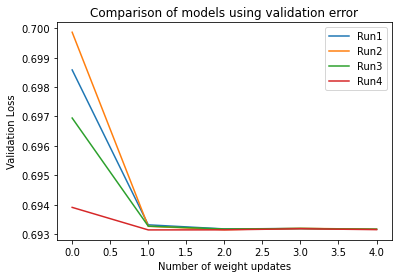

In [125]:
# Plotting validation loss of all the trials vs the Number of weight updates
plt.plot(bp_validation_error1)
plt.plot(bp_validation_error2)
plt.plot(bp_validation_error3)
plt.plot(bp_validation_error4)
plt.title('Comparison of models using validation error')
plt.ylabel('Validation Loss')
plt.xlabel('Number of weight updates')
plt.legend(['Run1', 'Run2', 'Run3', 'Run4'], loc='upper right')
plt.show()

In [126]:
# Storing the final validation for all models in a list
lowest_loss_obtained = [bp_validation_error1[-1],bp_validation_error2[-1],bp_validation_error3[-1],bp_validation_error4[-1]]

# Storing the time complexities for all models in a list
time_complexities = [bp_time_complexity1,bp_time_complexity2,bp_time_complexity3,bp_time_complexity4]

# Creating a list with all the model names
models = ['Run1', 'Run2', 'Run3', 'Run4']

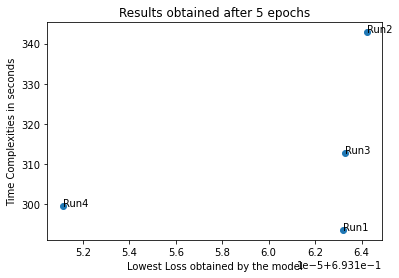

In [127]:
# Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation error
fig,ax = plt.subplots()
ax.scatter(lowest_loss_obtained, time_complexities)

plt.title('Results obtained after 5 epochs')
plt.ylabel('Time Complexities in seconds')
plt.xlabel('Lowest Loss obtained by the model')

for x,y in enumerate(models):
    ax.annotate(y, (lowest_loss_obtained[x], time_complexities[x]))    

In [128]:
architecture1_mean = statistics.mean(lowest_loss_obtained)
print('Architecture1 Validation Loss Mean: ', architecture1_mean)

Architecture1 Validation Loss Mean:  0.6931604593992233


In [129]:
architecture1_stddev = statistics.stdev(lowest_loss_obtained)
print('Architecture1 Validation Loss Std Dev: ', architecture1_stddev)

Architecture1 Validation Loss Std Dev:  6.245962923956167e-06


In [130]:
architecture1_time_mean = statistics.mean(time_complexities)
print('Architecture1 Time Complexity Mean: ', architecture1_time_mean)

Architecture1 Time Complexity Mean:  312.21585702401353


In [131]:
acc_list = [bp_validation_acc1[-1],bp_validation_acc2[-1],bp_validation_acc3[-1],bp_validation_acc4[-1]]
architecture1_acc_mean = statistics.mean(acc_list)
print('Architecture1 Validation Accuracy Mean: ', architecture1_acc_mean*100)

Architecture1 Validation Accuracy Mean:  50.02332031726837


### Architecture2 - 1 RNN layer, 1 hidden layer=40 nodes, epochs=5, batch_size=20, optimizer=adam, activation=relu

### Run1

In [132]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(SimpleRNN(units=1, input_shape=[20,1], activation='relu'))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 92s 244ms/step - loss: 5079.4590 - accuracy: 0.5059 - val_loss: 41.0124 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 92s 245ms/step - loss: 894.0347 - accuracy: 0.5063 - val_loss: 101.1059 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 90s 240ms/step - loss: 427.3706 - accuracy: 0.4980 - val_loss: 14.7920 - val_accuracy: 0.5028
Epoch 4/5
376/376 [==============================] - 88s 235ms/step - loss: 415.0359 - accuracy: 0.4981 - val_loss: 170.6501 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 89s 236ms/step - loss: 343.8685 - accuracy: 0.5008 - val_loss: 7.8421 - val_accuracy: 0.5103


In [133]:
# Calculating the final validation mse
bp_validation_error1 = history_bp.history['val_loss']
print('Final Validation loss for RNN Model for 1st Run:', bp_validation_error1[-1] )

# Calculating the final validation accracy
bp_validation_acc1 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for RNN Model for 1st Run:', bp_validation_acc1[-1] )


# Calculating the time complexity
bp_time_complexity1 = sum(time_bp)
print('Time complexity for RNN Model for 1st Run:', bp_time_complexity1,'seconds')

Final Validation loss for RNN Model for 1st Run: 7.842075824737549
Final Validation Accuracy for RNN Model for 1st Run: 0.5102611780166626
Time complexity for RNN Model for 1st Run: 454.16285982192494 seconds


### Run2

In [134]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(SimpleRNN(units=1, input_shape=[20,1], activation='relu'))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 84s 223ms/step - loss: 0.6929 - accuracy: 0.4983 - val_loss: 0.6911 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 109s 289ms/step - loss: 0.6928 - accuracy: 0.4973 - val_loss: 0.6902 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 108s 288ms/step - loss: 0.6928 - accuracy: 0.4968 - val_loss: 0.6896 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 105s 280ms/step - loss: 0.6927 - accuracy: 0.4971 - val_loss: 0.6890 - val_accuracy: 0.5084
Epoch 5/5
376/376 [==============================] - 89s 237ms/step - loss: 0.6926 - accuracy: 0.4952 - val_loss: 0.6885 - val_accuracy: 0.5084


In [135]:
# Calculating the final validation mse
bp_validation_error2 = history_bp.history['val_loss']
print('Final Validation Loss for RNN Model for 2nd Run:', bp_validation_error2[-1] )

# Calculating the final validation accracy
bp_validation_acc2 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for RNN Model for 2nd Run:', bp_validation_acc2[-1] )


# Calculating the time complexity
bp_time_complexity2 = sum(time_bp)
print('Time complexity for RNN Model for 2nd Run:', bp_time_complexity2,'seconds')

Final Validation Loss for RNN Model for 2nd Run: 0.6885039210319519
Final Validation Accuracy for RNN Model for 2nd Run: 0.5083954930305481
Time complexity for RNN Model for 2nd Run: 498.50502397608943 seconds


### Run3

In [136]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(SimpleRNN(units=1, input_shape=[20,1], activation='relu'))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 106s 282ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 82s 219ms/step - loss: 0.6932 - accuracy: 0.4939 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 82s 219ms/step - loss: 0.6932 - accuracy: 0.4936 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 80s 214ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 87s 232ms/step - loss: 0.6932 - accuracy: 0.4923 - val_loss: 0.6932 - val_accuracy: 0.5000


In [137]:
# Calculating the final validation mse
bp_validation_error3 = history_bp.history['val_loss']
print('Final Validation Loss for RNN Model for 3rd Run:', bp_validation_error3[-1] )

# Calculating the final validation accracy
bp_validation_acc3 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for RNN Model for 3rd Run:', bp_validation_acc3[-1] )

# Calculating the time complexity
bp_time_complexity3 = sum(time_bp)
print('Time complexity for RNN Model for 3rd Run:', bp_time_complexity3,'seconds')

Final Validation Loss for RNN Model for 3rd Run: 0.6931506395339966
Final Validation Accuracy for RNN Model for 3rd Run: 0.5
Time complexity for RNN Model for 3rd Run: 440.7534353460651 seconds


### Run4

In [138]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(SimpleRNN(units=1, input_shape=[20,1], activation='relu'))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 84s 224ms/step - loss: 4922.3335 - accuracy: 0.5063 - val_loss: 8.5051 - val_accuracy: 0.5037
Epoch 2/5
376/376 [==============================] - 102s 271ms/step - loss: 203.2617 - accuracy: 0.4915 - val_loss: 45.4077 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 104s 276ms/step - loss: 219.8848 - accuracy: 0.5007 - val_loss: 35.2379 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 96s 256ms/step - loss: 210.4067 - accuracy: 0.4960 - val_loss: 23.0579 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 93s 247ms/step - loss: 170.2211 - accuracy: 0.4976 - val_loss: 88.7969 - val_accuracy: 0.5000


In [139]:
# Calculating the final validation mse
bp_validation_error4 = history_bp.history['val_loss']
print('Final Validation Loss for RNN Model for 4th Run:', bp_validation_error4[-1] )

# Calculating the final validation accracy
bp_validation_acc4 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for RNN Model for 4th Run:', bp_validation_acc4[-1] )

# Calculating the time complexity
bp_time_complexity4 = sum(time_bp)
print('Time complexity for RNN Model for 4th Run:', bp_time_complexity4,'seconds')

Final Validation Loss for RNN Model for 4th Run: 88.79690551757812
Final Validation Accuracy for RNN Model for 4th Run: 0.5
Time complexity for RNN Model for 4th Run: 481.7172401830321 seconds


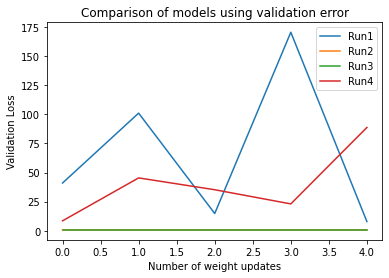

In [140]:
# Plotting validation loss of all the trials vs the Number of weight updates
plt.plot(bp_validation_error1)
plt.plot(bp_validation_error2)
plt.plot(bp_validation_error3)
plt.plot(bp_validation_error4)
plt.title('Comparison of models using validation error')
plt.ylabel('Validation Loss')
plt.xlabel('Number of weight updates')
plt.legend(['Run1', 'Run2', 'Run3', 'Run4'], loc='upper right')
plt.show()

In [141]:
# Storing the final validation for all models in a list
lowest_loss_obtained = [bp_validation_error1[-1],bp_validation_error2[-1],bp_validation_error3[-1],bp_validation_error4[-1]]

# Storing the time complexities for all models in a list
time_complexities = [bp_time_complexity1,bp_time_complexity2,bp_time_complexity3,bp_time_complexity4]

# Creating a list with all the model names
models = ['Run1', 'Run2', 'Run3', 'Run4']

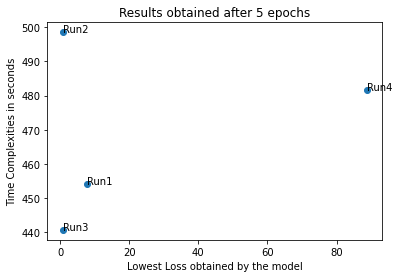

In [142]:
# Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation error
fig,ax = plt.subplots()
ax.scatter(lowest_loss_obtained, time_complexities)

plt.title('Results obtained after 5 epochs')
plt.ylabel('Time Complexities in seconds')
plt.xlabel('Lowest Loss obtained by the model')

for x,y in enumerate(models):
    ax.annotate(y, (lowest_loss_obtained[x], time_complexities[x]))    

In [143]:
architecture2_mean = statistics.mean(lowest_loss_obtained)
print('Architecture2 Validation Loss Mean: ', architecture2_mean)

Architecture2 Validation Loss Mean:  24.505158975720406


In [144]:
architecture2_stddev = statistics.stdev(lowest_loss_obtained)
print('Architecture2 Validation Loss Std Dev: ', architecture2_stddev)

Architecture2 Validation Loss Std Dev:  42.99353367075748


In [145]:
architecture2_time_mean = statistics.mean(time_complexities)
print('Architecture2 Time Complexity Mean: ', architecture2_time_mean)

Architecture2 Time Complexity Mean:  468.7846398317779


In [146]:
acc_list = [bp_validation_acc1[-1],bp_validation_acc2[-1],bp_validation_acc3[-1],bp_validation_acc4[-1]]
architecture2_acc_mean = statistics.mean(acc_list)
print('Architecture2 Validation Accuracy Mean: ', architecture2_acc_mean*100)

Architecture2 Validation Accuracy Mean:  50.46641677618027


### Architecture3 - 1st RNN layer,  2nd hidden layer=40 nodes, 3rd hidden layer=20 nodes, epochs=5, batch_size=20, optimizer=adam, activation=relu

### Run1

In [147]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(SimpleRNN(units=1, input_shape=[20,1], activation='relu'))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(20, input_dim=40, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 83s 222ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 71s 188ms/step - loss: 0.6932 - accuracy: 0.4939 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 79s 209ms/step - loss: 0.6932 - accuracy: 0.4936 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 91s 243ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 69s 183ms/step - loss: 0.6932 - accuracy: 0.4923 - val_loss: 0.6932 - val_accuracy: 0.5000


In [148]:
# Calculating the final validation mse
bp_validation_error1 = history_bp.history['val_loss']
print('Final Validation Loss for RNN Model for 1st Run:', bp_validation_error1[-1] )

# Calculating the final validation accracy
bp_validation_acc1 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for RNN Model for 1st Run:', bp_validation_acc1[-1] )


# Calculating the time complexity
bp_time_complexity1 = sum(time_bp)
print('Time complexity for RNN Model for 1st Run:', bp_time_complexity1,'seconds')

Final Validation Loss for RNN Model for 1st Run: 0.6931506395339966
Final Validation Accuracy for RNN Model for 1st Run: 0.5
Time complexity for RNN Model for 1st Run: 395.3436774581205 seconds


### Run2

In [149]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(SimpleRNN(units=1, input_shape=[20,1], activation='relu'))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(20, input_dim=40, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 75s 199ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 91s 243ms/step - loss: 0.6932 - accuracy: 0.4939 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 89s 236ms/step - loss: 0.6932 - accuracy: 0.4936 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 88s 233ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 78s 208ms/step - loss: 0.6932 - accuracy: 0.4923 - val_loss: 0.6932 - val_accuracy: 0.5000


In [150]:
# Calculating the final validation mse
bp_validation_error2 = history_bp.history['val_loss']
print('Final Validation Loss for RNN Model for 2nd Run:', bp_validation_error2[-1] )

# Calculating the final validation accracy
bp_validation_acc2 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for RNN Model for 2nd Run:', bp_validation_acc2[-1] )


# Calculating the time complexity
bp_time_complexity2 = sum(time_bp)
print('Time complexity for RNN Model for 2nd Run:', bp_time_complexity2,'seconds')

Final Validation Loss for RNN Model for 2nd Run: 0.6931506395339966
Final Validation Accuracy for RNN Model for 2nd Run: 0.5
Time complexity for RNN Model for 2nd Run: 423.29462295386475 seconds


### Run3

In [151]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(SimpleRNN(units=1, input_shape=[20,1], activation='relu'))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(20, input_dim=40, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 95s 253ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 104s 278ms/step - loss: 0.6932 - accuracy: 0.4939 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 103s 274ms/step - loss: 0.6932 - accuracy: 0.4936 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 108s 287ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 104s 276ms/step - loss: 0.6932 - accuracy: 0.4923 - val_loss: 0.6932 - val_accuracy: 0.5000


In [152]:
# Calculating the final validation mse
bp_validation_error3 = history_bp.history['val_loss']
print('Final Validation Loss for RNN Model for 3rd Run:', bp_validation_error3[-1] )

# Calculating the final validation accracy
bp_validation_acc3 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for RNN Model for 3rd Run:', bp_validation_acc3[-1] )

# Calculating the time complexity
bp_time_complexity3 = sum(time_bp)
print('Time complexity for RNN Model for 3rd Run:', bp_time_complexity3,'seconds')

Final Validation Loss for RNN Model for 3rd Run: 0.6931506395339966
Final Validation Accuracy for RNN Model for 3rd Run: 0.5
Time complexity for RNN Model for 3rd Run: 517.1202250889037 seconds


### Run4

In [153]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(SimpleRNN(units=1, input_shape=[20,1], activation='relu'))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(20, input_dim=40, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 99s 262ms/step - loss: 0.6947 - accuracy: 0.5043 - val_loss: 0.6897 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 100s 266ms/step - loss: 0.6927 - accuracy: 0.5012 - val_loss: 0.6894 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 101s 269ms/step - loss: 0.6928 - accuracy: 0.4973 - val_loss: 0.6889 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 97s 259ms/step - loss: 0.6926 - accuracy: 0.4976 - val_loss: 0.6886 - val_accuracy: 0.5075
Epoch 5/5
376/376 [==============================] - 95s 252ms/step - loss: 0.6926 - accuracy: 0.4971 - val_loss: 0.6885 - val_accuracy: 0.5075


In [154]:
# Calculating the final validation mse
bp_validation_error4 = history_bp.history['val_loss']
print('Final Validation Loss for RNN Model for 4th Run:', bp_validation_error4[-1] )

# Calculating the final validation accracy
bp_validation_acc4 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for RNN Model for 4th Run:', bp_validation_acc4[-1] )

# Calculating the time complexity
bp_time_complexity4 = sum(time_bp)
print('Time complexity for RNN Model for 4th Run:', bp_time_complexity4,'seconds')

Final Validation Loss for RNN Model for 4th Run: 0.6884564757347107
Final Validation Accuracy for RNN Model for 4th Run: 0.5074626803398132
Time complexity for RNN Model for 4th Run: 495.1155846359907 seconds


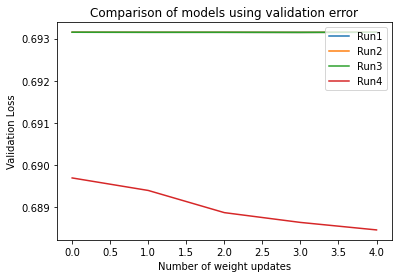

In [155]:
# Plotting validation loss of all the trials vs the Number of weight updates
plt.plot(bp_validation_error1)
plt.plot(bp_validation_error2)
plt.plot(bp_validation_error3)
plt.plot(bp_validation_error4)
plt.title('Comparison of models using validation error')
plt.ylabel('Validation Loss')
plt.xlabel('Number of weight updates')
plt.legend(['Run1', 'Run2', 'Run3', 'Run4'], loc='upper right')
plt.show()

In [156]:
# Storing the final validation for all models in a list
lowest_loss_obtained = [bp_validation_error1[-1],bp_validation_error2[-1],bp_validation_error3[-1],bp_validation_error4[-1]]

# Storing the time complexities for all models in a list
time_complexities = [bp_time_complexity1,bp_time_complexity2,bp_time_complexity3,bp_time_complexity4]

# Creating a list with all the model names
models = ['Run1', 'Run2', 'Run3', 'Run4']

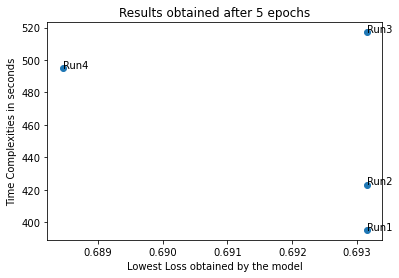

In [157]:
# Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation error
fig,ax = plt.subplots()
ax.scatter(lowest_loss_obtained, time_complexities)

plt.title('Results obtained after 5 epochs')
plt.ylabel('Time Complexities in seconds')
plt.xlabel('Lowest Loss obtained by the model')

for x,y in enumerate(models):
    ax.annotate(y, (lowest_loss_obtained[x], time_complexities[x]))    

In [158]:
architecture3_mean = statistics.mean(lowest_loss_obtained)
print('Architecture3 Validation Loss Mean: ', architecture3_mean)

Architecture3 Validation Loss Mean:  0.6919770985841751


In [159]:
architecture3_stddev = statistics.stdev(lowest_loss_obtained)
print('Architecture3 Validation Loss Std Dev: ', architecture3_stddev)

Architecture3 Validation Loss Std Dev:  0.0023470818996429443


In [160]:
architecture3_time_mean = statistics.mean(time_complexities)
print('Architecture3 Time Complexity Mean: ', architecture3_time_mean)

Architecture3 Time Complexity Mean:  457.7185275342199


In [161]:
acc_list = [bp_validation_acc1[-1],bp_validation_acc2[-1],bp_validation_acc3[-1],bp_validation_acc4[-1]]
architecture3_acc_mean = statistics.mean(acc_list)
print('Architecture3 Validation Accuracy Mean: ', architecture3_acc_mean*100)

Architecture3 Validation Accuracy Mean:  50.18656700849533


In [162]:
# Creating a summary table for the model names, lowest MSE and their time complexities
model_summary = pd.DataFrame({"Model":["RNN Architecture1","RNN Architecture2",
                                       "RNN Architecture3"], "Mean Validation loss after 4 trials":[architecture1_mean,architecture2_mean,architecture3_mean],
                              "Mean Standard deviation after 4 trials":[architecture1_stddev,architecture2_stddev,architecture3_stddev],
                            "Mean Time Complexity in seconds after 4 trials":[architecture1_time_mean,architecture2_time_mean,architecture3_time_mean],
                              "Mean Validation Accuracy after 4 trials":[architecture1_acc_mean,architecture2_acc_mean,architecture3_acc_mean]
                                               })

In [163]:
model_summary

,Model,Mean Validation loss after 4 trials,Mean Standard deviation after 4 trials,Mean Time Complexity in seconds after 4 trials,Mean Validation Accuracy after 4 trials
0,RNN Architecture1,0.693160,0.000006,312.215857,0.500233
1,RNN Architecture2,24.505159,42.993534,468.784640,0.504664
2,RNN Architecture3,0.691977,0.002347,457.718528,0.501866


### Using Best Model - RNN Architecture3 - with - epochs=20

In [164]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(SimpleRNN(units=1, input_shape=[20,1], activation='relu'))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(20, input_dim=40, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=20, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/20
376/376 [==============================] - 92s 244ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/20
376/376 [==============================] - 98s 262ms/step - loss: 0.6932 - accuracy: 0.4939 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/20
376/376 [==============================] - 85s 225ms/step - loss: 0.6932 - accuracy: 0.4936 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/20
376/376 [==============================] - 82s 219ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/20
376/376 [==============================] - 81s 214ms/step - loss: 0.6932 - accuracy: 0.4923 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/20
376/376 [==============================] - 84s 223ms/step - loss: 0.6932 - accuracy: 0.4848 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/20
376/376 [==============================] - 76s 202ms/step - loss: 0.6932 - accuracy: 0.4939 - val_loss: 0.6931 - val_ac

In [165]:
# Calculating the final validation loss
bp_validation_error_best = history_bp.history['val_loss']
print('Final Validation Loss for RNN Model:', bp_validation_error_best[-1] )

# Calculating the final validation accracy
bp_validation_acc_best = history_bp.history['val_accuracy']
print('Final Validation Accuracy for RNN Model:', bp_validation_acc_best[-1] )


# Calculating the time complexity
bp_time_complexity_best = sum(time_bp)
print('Time complexity for RNN Model:', bp_time_complexity_best,'seconds')

Final Validation Loss for Best Plain Backpropagation Model: 0.6931502223014832
Final Validation Accuracy for Best Plain Backpropagation Model: 0.5
Time complexity for Best Plain Backpropagation Model: 1598.4135850556195 seconds


In [166]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(y_true=y_test,y_pred=(model_bp.predict(X_test)>0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       536
           1       0.50      1.00      0.67       536

    accuracy                           0.50      1072
   macro avg       0.25      0.50      0.33      1072
weighted avg       0.25      0.50      0.33      1072



/home/ssingh56/anaconda3/envs/production/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Architecture1 - 1 LSTM layer, epochs=5, batch_size=20, optimizer=SGD, activation=tanh

### Run1

In [167]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(LSTM(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 75s 199ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 83s 220ms/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 80s 212ms/step - loss: 0.6932 - accuracy: 0.4971 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 76s 203ms/step - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 77s 204ms/step - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6932 - val_accuracy: 0.5000


In [168]:
# Calculating the final validation mse
bp_validation_error1 = history_bp.history['val_loss']
print('Final Validation Loss for LSTM Model for 1st Run:', bp_validation_error1[-1] )

# Calculating the final validation accracy
bp_validation_acc1 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for LSTM Model for 1st Run:', bp_validation_acc1[-1] )


# Calculating the time complexity
bp_time_complexity1 = sum(time_bp)
print('Time complexity for LSTM Model for 1st Run:', bp_time_complexity1,'seconds')

Final Validation Loss for LSTM Model for 1st Run: 0.6931519508361816
Final Validation Accuracy for LSTM Model for 1st Run: 0.5
Time complexity for LSTM Model for 1st Run: 395.5842968369834 seconds


### Run2

In [169]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(LSTM(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 82s 219ms/step - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 84s 223ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 80s 212ms/step - loss: 0.6932 - accuracy: 0.4975 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 83s 221ms/step - loss: 0.6932 - accuracy: 0.4991 - val_loss: 0.6931 - val_accuracy: 0.5037
Epoch 5/5
376/376 [==============================] - 83s 221ms/step - loss: 0.6932 - accuracy: 0.4948 - val_loss: 0.6931 - val_accuracy: 0.5037


In [170]:
# Calculating the final validation mse
bp_validation_error2 = history_bp.history['val_loss']
print('Final Validation Loss for LSTM Model for 2nd Run:', bp_validation_error2[-1] )

# Calculating the final validation accracy
bp_validation_acc2 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for LSTM Model for 2nd Run:', bp_validation_acc2[-1] )


# Calculating the time complexity
bp_time_complexity2 = sum(time_bp)
print('Time complexity for LSTM Model for 2nd Run:', bp_time_complexity2,'seconds')

Final Validation Loss for LSTM Model for 2nd Run: 0.6930756568908691
Final Validation Accuracy for LSTM Model for 2nd Run: 0.503731369972229
Time complexity for LSTM Model for 2nd Run: 417.0322614731267 seconds


### Run3

In [171]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(LSTM(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 81s 216ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 84s 224ms/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 80s 212ms/step - loss: 0.6932 - accuracy: 0.4971 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 81s 214ms/step - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 81s 216ms/step - loss: 0.6932 - accuracy: 0.4945 - val_loss: 0.6932 - val_accuracy: 0.5000


In [172]:
# Calculating the final validation mse
bp_validation_error3 = history_bp.history['val_loss']
print('Final Validation Loss for LSTM Model for 3rd Run:', bp_validation_error3[-1] )

# Calculating the final validation accracy
bp_validation_acc3 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for LSTM Model for 3rd Run:', bp_validation_acc3[-1] )


# Calculating the time complexity
bp_time_complexity3 = sum(time_bp)
print('Time complexity for LSTM Model for 3rd Run:', bp_time_complexity3,'seconds')

Final Validation Loss for LSTM Model for 3rd Run: 0.693150520324707
Final Validation Accuracy for LSTM Model for 3rd Run: 0.5
Time complexity for LSTM Model for 3rd Run: 412.6052392120473 seconds


### Run4

In [173]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(LSTM(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 79s 211ms/step - loss: 0.7035 - accuracy: 0.5000 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 80s 212ms/step - loss: 0.6937 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 81s 215ms/step - loss: 0.6932 - accuracy: 0.4960 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 82s 217ms/step - loss: 0.6932 - accuracy: 0.4949 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 83s 220ms/step - loss: 0.6933 - accuracy: 0.4944 - val_loss: 0.6932 - val_accuracy: 0.5000


In [174]:
# Calculating the final validation mse
bp_validation_error4 = history_bp.history['val_loss']
print('Final Validation Loss for LSTM Model for 4th Run:', bp_validation_error4[-1] )

# Calculating the final validation accracy
bp_validation_acc4 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for LSTM Model for 4th Run:', bp_validation_acc4[-1] )


# Calculating the time complexity
bp_time_complexity4 = sum(time_bp)
print('Time complexity for LSTM Model for 4th Run:', bp_time_complexity4,'seconds')

Final Validation Loss for LSTM Model for 4th Run: 0.6931592226028442
Final Validation Accuracy for LSTM Model for 4th Run: 0.5
Time complexity for LSTM Model for 4th Run: 409.1514149638824 seconds


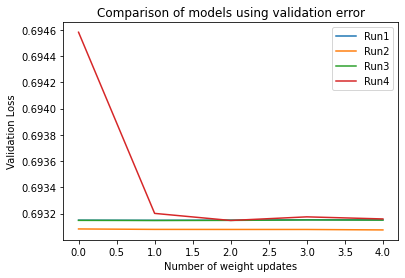

In [175]:
# Plotting validation loss of all the trials vs the Number of weight updates
plt.plot(bp_validation_error1)
plt.plot(bp_validation_error2)
plt.plot(bp_validation_error3)
plt.plot(bp_validation_error4)
plt.title('Comparison of models using validation error')
plt.ylabel('Validation Loss')
plt.xlabel('Number of weight updates')
plt.legend(['Run1', 'Run2', 'Run3', 'Run4'], loc='upper right')
plt.show()

In [176]:
# Storing the final validation for all models in a list
lowest_loss_obtained = [bp_validation_error1[-1],bp_validation_error2[-1],bp_validation_error3[-1],bp_validation_error4[-1]]

# Storing the time complexities for all models in a list
time_complexities = [bp_time_complexity1,bp_time_complexity2,bp_time_complexity3,bp_time_complexity4]

# Creating a list with all the model names
models = ['Run1', 'Run2', 'Run3', 'Run4']

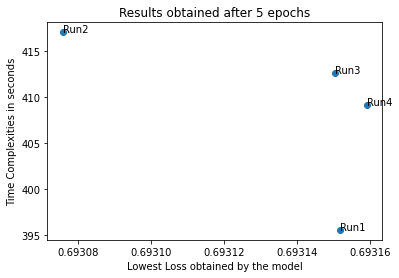

In [177]:
# Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation error
fig,ax = plt.subplots()
ax.scatter(lowest_loss_obtained, time_complexities)

plt.title('Results obtained after 5 epochs')
plt.ylabel('Time Complexities in seconds')
plt.xlabel('Lowest Loss obtained by the model')

for x,y in enumerate(models):
    ax.annotate(y, (lowest_loss_obtained[x], time_complexities[x]))    

In [178]:
architecture1_mean = statistics.mean(lowest_loss_obtained)
print('Architecture1 Validation Loss Mean: ', architecture1_mean)

Architecture1 Validation Loss Mean:  0.6931343376636505


In [179]:
architecture1_stddev = statistics.stdev(lowest_loss_obtained)
print('Architecture1 Validation Loss Std Dev: ', architecture1_stddev)

Architecture1 Validation Loss Std Dev:  3.930562155882149e-05


In [180]:
architecture1_time_mean = statistics.mean(time_complexities)
print('Architecture1 Time Complexity Mean: ', architecture1_time_mean)

Architecture1 Time Complexity Mean:  408.59330312150996


In [181]:
acc_list = [bp_validation_acc1[-1],bp_validation_acc2[-1],bp_validation_acc3[-1],bp_validation_acc4[-1]]
architecture1_acc_mean = statistics.mean(acc_list)
print('Architecture1 Validation Accuracy Mean: ', architecture1_acc_mean*100)

Architecture1 Validation Accuracy Mean:  50.093284249305725


### Architecture2 - 1 LSTM layer, 1 hidden layer=40 nodes, epochs=5, batch_size=20, optimizer=adam, activation=tanh

### Run1

In [182]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(LSTM(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 89s 236ms/step - loss: 0.6955 - accuracy: 0.5005 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 79s 210ms/step - loss: 0.6936 - accuracy: 0.5059 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 76s 203ms/step - loss: 0.6939 - accuracy: 0.4891 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 79s 210ms/step - loss: 0.6935 - accuracy: 0.5077 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 71s 188ms/step - loss: 0.6942 - accuracy: 0.4928 - val_loss: 0.6932 - val_accuracy: 0.5000


In [183]:
# Calculating the final validation mse
bp_validation_error1 = history_bp.history['val_loss']
print('Final Validation loss for LSTM Model for 1st Run:', bp_validation_error1[-1] )

# Calculating the final validation accracy
bp_validation_acc1 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for LSTM Model for 1st Run:', bp_validation_acc1[-1] )


# Calculating the time complexity
bp_time_complexity1 = sum(time_bp)
print('Time complexity for LSTM Model for 1st Run:', bp_time_complexity1,'seconds')

Final Validation loss for LSTM Model for 1st Run: 0.6932461857795715
Final Validation Accuracy for LSTM Model for 1st Run: 0.5
Time complexity for LSTM Model for 1st Run: 399.50898512499407 seconds


### Run2

In [184]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(LSTM(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 76s 203ms/step - loss: 0.6939 - accuracy: 0.5029 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 78s 208ms/step - loss: 0.6935 - accuracy: 0.5093 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 82s 219ms/step - loss: 0.6938 - accuracy: 0.4867 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 84s 225ms/step - loss: 0.6934 - accuracy: 0.5045 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 81s 215ms/step - loss: 0.6940 - accuracy: 0.4891 - val_loss: 0.6933 - val_accuracy: 0.5000


In [185]:
# Calculating the final validation mse
bp_validation_error2 = history_bp.history['val_loss']
print('Final Validation Loss for LSTM Model for 2nd Run:', bp_validation_error2[-1] )

# Calculating the final validation accracy
bp_validation_acc2 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for LSTM Model for 2nd Run:', bp_validation_acc2[-1] )


# Calculating the time complexity
bp_time_complexity2 = sum(time_bp)
print('Time complexity for LSTM Model for 2nd Run:', bp_time_complexity2,'seconds')

Final Validation Loss for LSTM Model for 2nd Run: 0.6932649612426758
Final Validation Accuracy for LSTM Model for 2nd Run: 0.5
Time complexity for LSTM Model for 2nd Run: 407.7686723767547 seconds


### Run3

In [186]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(LSTM(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 93s 246ms/step - loss: 0.6934 - accuracy: 0.5045 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 90s 239ms/step - loss: 0.6933 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 88s 235ms/step - loss: 0.6933 - accuracy: 0.4987 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 90s 239ms/step - loss: 0.6932 - accuracy: 0.4933 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 89s 237ms/step - loss: 0.6933 - accuracy: 0.4931 - val_loss: 0.6932 - val_accuracy: 0.5000


In [187]:
# Calculating the final validation mse
bp_validation_error3 = history_bp.history['val_loss']
print('Final Validation Loss for LSTM Model for 3rd Run:', bp_validation_error3[-1] )

# Calculating the final validation accracy
bp_validation_acc3 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for LSTM Model for 3rd Run:', bp_validation_acc3[-1] )

# Calculating the time complexity
bp_time_complexity3 = sum(time_bp)
print('Time complexity for LSTM Model for 3rd Run:', bp_time_complexity3,'seconds')

Final Validation Loss for LSTM Model for 3rd Run: 0.6931709051132202
Final Validation Accuracy for LSTM Model for 3rd Run: 0.5
Time complexity for LSTM Model for 3rd Run: 456.1126623979071 seconds


### Run4

In [188]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(LSTM(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 95s 252ms/step - loss: 0.6935 - accuracy: 0.5037 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 91s 243ms/step - loss: 0.6933 - accuracy: 0.5003 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 91s 242ms/step - loss: 0.6933 - accuracy: 0.4968 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 91s 241ms/step - loss: 0.6932 - accuracy: 0.4952 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 83s 222ms/step - loss: 0.6933 - accuracy: 0.4933 - val_loss: 0.6932 - val_accuracy: 0.5000


In [189]:
# Calculating the final validation mse
bp_validation_error4 = history_bp.history['val_loss']
print('Final Validation Loss for LSTM Model for 4th Run:', bp_validation_error4[-1] )

# Calculating the final validation accracy
bp_validation_acc4 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for LSTM Model for 4th Run:', bp_validation_acc4[-1] )

# Calculating the time complexity
bp_time_complexity4 = sum(time_bp)
print('Time complexity for LSTM Model for 4th Run:', bp_time_complexity4,'seconds')

Final Validation Loss for LSTM Model for 4th Run: 0.6931721568107605
Final Validation Accuracy for LSTM Model for 4th Run: 0.5
Time complexity for LSTM Model for 4th Run: 456.89901408797596 seconds


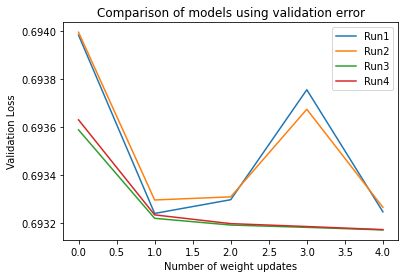

In [190]:
# Plotting validation loss of all the trials vs the Number of weight updates
plt.plot(bp_validation_error1)
plt.plot(bp_validation_error2)
plt.plot(bp_validation_error3)
plt.plot(bp_validation_error4)
plt.title('Comparison of models using validation error')
plt.ylabel('Validation Loss')
plt.xlabel('Number of weight updates')
plt.legend(['Run1', 'Run2', 'Run3', 'Run4'], loc='upper right')
plt.show()

In [191]:
# Storing the final validation for all models in a list
lowest_loss_obtained = [bp_validation_error1[-1],bp_validation_error2[-1],bp_validation_error3[-1],bp_validation_error4[-1]]

# Storing the time complexities for all models in a list
time_complexities = [bp_time_complexity1,bp_time_complexity2,bp_time_complexity3,bp_time_complexity4]

# Creating a list with all the model names
models = ['Run1', 'Run2', 'Run3', 'Run4']

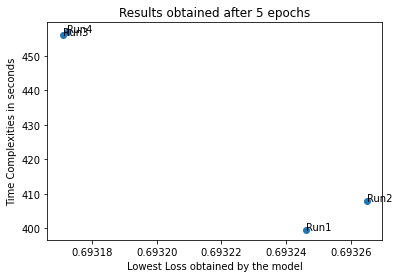

In [192]:
# Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation error
fig,ax = plt.subplots()
ax.scatter(lowest_loss_obtained, time_complexities)

plt.title('Results obtained after 5 epochs')
plt.ylabel('Time Complexities in seconds')
plt.xlabel('Lowest Loss obtained by the model')

for x,y in enumerate(models):
    ax.annotate(y, (lowest_loss_obtained[x], time_complexities[x]))    

In [193]:
architecture2_mean = statistics.mean(lowest_loss_obtained)
print('Architecture2 Validation Loss Mean: ', architecture2_mean)

Architecture2 Validation Loss Mean:  0.693213552236557


In [194]:
architecture2_stddev = statistics.stdev(lowest_loss_obtained)
print('Architecture2 Validation Loss Std Dev: ', architecture2_stddev)

Architecture2 Validation Loss Std Dev:  4.9126342036219704e-05


In [195]:
architecture2_time_mean = statistics.mean(time_complexities)
print('Architecture2 Time Complexity Mean: ', architecture2_time_mean)

Architecture2 Time Complexity Mean:  430.07233349690796


In [196]:
acc_list = [bp_validation_acc1[-1],bp_validation_acc2[-1],bp_validation_acc3[-1],bp_validation_acc4[-1]]
architecture2_acc_mean = statistics.mean(acc_list)
print('Architecture2 Validation Accuracy Mean: ', architecture2_acc_mean*100)

Architecture2 Validation Accuracy Mean:  50.0


### Architecture3 - 1st LSTM layer,  2nd hidden layer=40 nodes, 3rd hidden layer=20 nodes, epochs=5, batch_size=20, optimizer=adam, activation=tanh

### Run1

In [197]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(LSTM(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(20, input_dim=40, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 92s 244ms/step - loss: 0.6935 - accuracy: 0.5021 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 87s 233ms/step - loss: 0.6933 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 85s 226ms/step - loss: 0.6933 - accuracy: 0.4968 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 85s 226ms/step - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 79s 211ms/step - loss: 0.6933 - accuracy: 0.4941 - val_loss: 0.6932 - val_accuracy: 0.5009


In [198]:
# Calculating the final validation mse
bp_validation_error1 = history_bp.history['val_loss']
print('Final Validation Loss for LSTM Model for 1st Run:', bp_validation_error1[-1] )

# Calculating the final validation accracy
bp_validation_acc1 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for LSTM Model for 1st Run:', bp_validation_acc1[-1] )


# Calculating the time complexity
bp_time_complexity1 = sum(time_bp)
print('Time complexity for LSTM Model for 1st Run:', bp_time_complexity1,'seconds')

Final Validation Loss for LSTM Model for 1st Run: 0.6931617259979248
Final Validation Accuracy for LSTM Model for 1st Run: 0.5009328126907349
Time complexity for LSTM Model for 1st Run: 435.057998941862 seconds


### Run2

In [199]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(LSTM(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(20, input_dim=40, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 90s 240ms/step - loss: 0.6935 - accuracy: 0.5004 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 80s 214ms/step - loss: 0.6934 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 77s 205ms/step - loss: 0.6934 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 80s 213ms/step - loss: 0.6932 - accuracy: 0.4952 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 80s 213ms/step - loss: 0.6934 - accuracy: 0.4915 - val_loss: 0.6932 - val_accuracy: 0.5009


In [200]:
# Calculating the final validation mse
bp_validation_error2 = history_bp.history['val_loss']
print('Final Validation Loss for LSTM Model for 2nd Run:', bp_validation_error2[-1] )

# Calculating the final validation accracy
bp_validation_acc2 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for LSTM Model for 2nd Run:', bp_validation_acc2[-1] )


# Calculating the time complexity
bp_time_complexity2 = sum(time_bp)
print('Time complexity for LSTM Model for 2nd Run:', bp_time_complexity2,'seconds')

Final Validation Loss for LSTM Model for 2nd Run: 0.693173348903656
Final Validation Accuracy for LSTM Model for 2nd Run: 0.5009328126907349
Time complexity for LSTM Model for 2nd Run: 412.79406913311686 seconds


### Run3

In [201]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(LSTM(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(20, input_dim=40, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 91s 243ms/step - loss: 0.6936 - accuracy: 0.5043 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 85s 225ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 85s 225ms/step - loss: 0.6933 - accuracy: 0.4976 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 81s 215ms/step - loss: 0.6932 - accuracy: 0.4965 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 83s 221ms/step - loss: 0.6934 - accuracy: 0.4923 - val_loss: 0.6932 - val_accuracy: 0.5000


In [202]:
# Calculating the final validation mse
bp_validation_error3 = history_bp.history['val_loss']
print('Final Validation Loss for LSTM Model for 3rd Run:', bp_validation_error3[-1] )

# Calculating the final validation accracy
bp_validation_acc3 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for LSTM Model for 3rd Run:', bp_validation_acc3[-1] )

# Calculating the time complexity
bp_time_complexity3 = sum(time_bp)
print('Time complexity for LSTM Model for 3rd Run:', bp_time_complexity3,'seconds')

Final Validation Loss for LSTM Model for 3rd Run: 0.6931803226470947
Final Validation Accuracy for LSTM Model for 3rd Run: 0.5
Time complexity for LSTM Model for 3rd Run: 430.0714209669968 seconds


### Run4

In [203]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(LSTM(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(20, input_dim=40, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 85s 226ms/step - loss: 0.6947 - accuracy: 0.5128 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 89s 237ms/step - loss: 0.6941 - accuracy: 0.5069 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 87s 232ms/step - loss: 0.6944 - accuracy: 0.4979 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 88s 235ms/step - loss: 0.6936 - accuracy: 0.5101 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 88s 235ms/step - loss: 0.6945 - accuracy: 0.4939 - val_loss: 0.6932 - val_accuracy: 0.5000


In [204]:
# Calculating the final validation mse
bp_validation_error4 = history_bp.history['val_loss']
print('Final Validation Loss for LSTM Model for 4th Run:', bp_validation_error4[-1] )

# Calculating the final validation accracy
bp_validation_acc4 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for LSTM Model for 4th Run:', bp_validation_acc4[-1] )

# Calculating the time complexity
bp_time_complexity4 = sum(time_bp)
print('Time complexity for LSTM Model for 4th Run:', bp_time_complexity4,'seconds')

Final Validation Loss for LSTM Model for 4th Run: 0.6931678652763367
Final Validation Accuracy for LSTM Model for 4th Run: 0.5
Time complexity for LSTM Model for 4th Run: 442.20675299409777 seconds


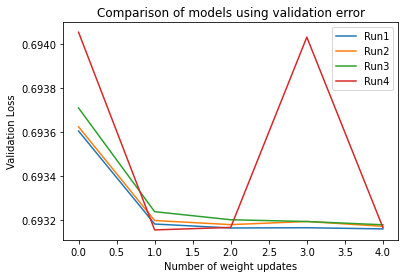

In [205]:
# Plotting validation loss of all the trials vs the Number of weight updates
plt.plot(bp_validation_error1)
plt.plot(bp_validation_error2)
plt.plot(bp_validation_error3)
plt.plot(bp_validation_error4)
plt.title('Comparison of models using validation error')
plt.ylabel('Validation Loss')
plt.xlabel('Number of weight updates')
plt.legend(['Run1', 'Run2', 'Run3', 'Run4'], loc='upper right')
plt.show()

In [206]:
# Storing the final validation for all models in a list
lowest_loss_obtained = [bp_validation_error1[-1],bp_validation_error2[-1],bp_validation_error3[-1],bp_validation_error4[-1]]

# Storing the time complexities for all models in a list
time_complexities = [bp_time_complexity1,bp_time_complexity2,bp_time_complexity3,bp_time_complexity4]

# Creating a list with all the model names
models = ['Run1', 'Run2', 'Run3', 'Run4']

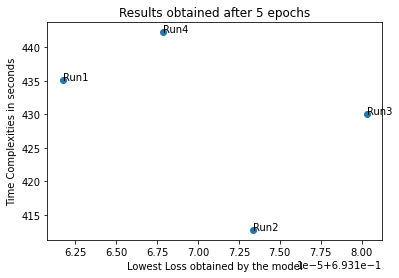

In [207]:
# Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation error
fig,ax = plt.subplots()
ax.scatter(lowest_loss_obtained, time_complexities)

plt.title('Results obtained after 5 epochs')
plt.ylabel('Time Complexities in seconds')
plt.xlabel('Lowest Loss obtained by the model')

for x,y in enumerate(models):
    ax.annotate(y, (lowest_loss_obtained[x], time_complexities[x]))    

In [208]:
architecture3_mean = statistics.mean(lowest_loss_obtained)
print('Architecture3 Validation Loss Mean: ', architecture3_mean)

Architecture3 Validation Loss Mean:  0.693170815706253


In [209]:
architecture3_stddev = statistics.stdev(lowest_loss_obtained)
print('Architecture3 Validation Loss Std Dev: ', architecture3_stddev)

Architecture3 Validation Loss Std Dev:  7.918898227942296e-06


In [210]:
architecture3_time_mean = statistics.mean(time_complexities)
print('Architecture3 Time Complexity Mean: ', architecture3_time_mean)

Architecture3 Time Complexity Mean:  430.03256050901837


In [211]:
acc_list = [bp_validation_acc1[-1],bp_validation_acc2[-1],bp_validation_acc3[-1],bp_validation_acc4[-1]]
architecture3_acc_mean = statistics.mean(acc_list)
print('Architecture3 Validation Accuracy Mean: ', architecture3_acc_mean*100)

Architecture3 Validation Accuracy Mean:  50.04664063453674


In [212]:
# Creating a summary table for the model names, lowest MSE and their time complexities
model_summary = pd.DataFrame({"Model":["LSTM Architecture1","LSTM Architecture2",
                                       "LSTM Architecture3"], "Mean Validation loss after 4 trials":[architecture1_mean,architecture2_mean,architecture3_mean],
                              "Mean Standard deviation after 4 trials":[architecture1_stddev,architecture2_stddev,architecture3_stddev],
                            "Mean Time Complexity in seconds after 4 trials":[architecture1_time_mean,architecture2_time_mean,architecture3_time_mean],
                              "Mean Validation Accuracy after 4 trials":[architecture1_acc_mean,architecture2_acc_mean,architecture3_acc_mean]
                                               })

In [213]:
model_summary

,Model,Mean Validation loss after 4 trials,Mean Standard deviation after 4 trials,Mean Time Complexity in seconds after 4 trials,Mean Validation Accuracy after 4 trials
0,LSTM Architecture1,0.693134,0.000039,408.593303,0.500933
1,LSTM Architecture2,0.693214,0.000049,430.072333,0.500000
2,LSTM Architecture3,0.693171,0.000008,430.032561,0.500466


Instructions for updating:
Please use `model.predict()` instead.
No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.499


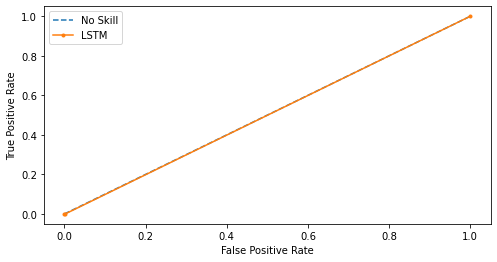

In [214]:
ROC_AUC_curve_upgraded(model=model_bp,model_name="LSTM")

### Using Best Model - LSTM Architecture1 - with - epochs=20

In [215]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(LSTM(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=20, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/20
376/376 [==============================] - 77s 205ms/step - loss: 0.7372 - accuracy: 0.5000 - val_loss: 0.7011 - val_accuracy: 0.5000
Epoch 2/20
376/376 [==============================] - 65s 174ms/step - loss: 0.6957 - accuracy: 0.5000 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 3/20
376/376 [==============================] - 65s 173ms/step - loss: 0.6934 - accuracy: 0.4999 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/20
376/376 [==============================] - 62s 165ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/20
376/376 [==============================] - 58s 154ms/step - loss: 0.6932 - accuracy: 0.4931 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/20
376/376 [==============================] - 58s 153ms/step - loss: 0.6932 - accuracy: 0.4925 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/20
376/376 [==============================] - 58s 155ms/step - loss: 0.6932 - accuracy: 0.4923 - val_loss: 0.6932 - val_ac

In [216]:
# Calculating the final validation loss
bp_validation_error_best = history_bp.history['val_loss']
print('Final Validation Loss for Best LSTM Model:', bp_validation_error_best[-1] )

# Calculating the final validation accracy
bp_validation_acc_best = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Best LSTM Model:', bp_validation_acc_best[-1] )


# Calculating the time complexity
bp_time_complexity_best = sum(time_bp)
print('Time complexity for Best LSTM Model:', bp_time_complexity_best,'seconds')

Final Validation Loss for Best LSTM Model: 0.6931639909744263
Final Validation Accuracy for Best LSTM Model: 0.5
Time complexity for Best LSTM Model: 1340.7730651039165 seconds


In [217]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(y_true=y_test,y_pred=(model_bp.predict(X_test)>0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       536
           1       0.50      1.00      0.67       536

    accuracy                           0.50      1072
   macro avg       0.25      0.50      0.33      1072
weighted avg       0.25      0.50      0.33      1072



/home/ssingh56/anaconda3/envs/production/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Gated Recurrent Unit

- Initially we have set the seed so that model performance does not vary with each run
- Here, we have setup a GRU model
- We have used the activation function as 'relu' for the GRU layer. We have used a single GRU unit and input shape is [features, TimeSteps] i.e. [20,1]
- We have used the loss function as 'BCE' and optimizer as 'adam'
- Hyperparameters used for training:
    - epochs = 5
    - batch_size = 20


- GRU model performed with the below performance on the testing dataset:
- Accuracy: 50%

### Architecture1 - 1 GRU layer , optimizer=SGD, activation=tanh, epochs=5, batch_size=20

### Run1

In [220]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(GRU(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 153s 407ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6932 - val_accuracy: 0.4991
Epoch 2/5
376/376 [==============================] - 169s 448ms/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6932 - val_accuracy: 0.4991
Epoch 3/5
376/376 [==============================] - 171s 453ms/step - loss: 0.6932 - accuracy: 0.4971 - val_loss: 0.6932 - val_accuracy: 0.4991
Epoch 4/5
376/376 [==============================] - 157s 417ms/step - loss: 0.6932 - accuracy: 0.4988 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 167s 445ms/step - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6932 - val_accuracy: 0.5000


In [221]:
# Calculating the final validation mse
bp_validation_error1 = history_bp.history['val_loss']
print('Final Validation Loss for GRU Model for 1st Run:', bp_validation_error1[-1] )

# Calculating the final validation accracy
bp_validation_acc1 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for GRU Model for 1st Run:', bp_validation_acc1[-1] )


# Calculating the time complexity
bp_time_complexity1 = sum(time_bp)
print('Time complexity for GRU Model for 1st Run:', bp_time_complexity1,'seconds')

Final Validation Loss for GRU Model for 1st Run: 0.6932322382926941
Final Validation Accuracy for GRU Model for 1st Run: 0.5
Time complexity for GRU Model for 1st Run: 823.6186329439515 seconds


### Run2

In [222]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(GRU(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 130s 346ms/step - loss: 0.6932 - accuracy: 0.4952 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 154s 409ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 146s 389ms/step - loss: 0.6932 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 125s 333ms/step - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 147s 390ms/step - loss: 0.6933 - accuracy: 0.4936 - val_loss: 0.6932 - val_accuracy: 0.5000


In [223]:
# Calculating the final validation mse
bp_validation_error2 = history_bp.history['val_loss']
print('Final Validation Loss for GRU Model for 2nd Run:', bp_validation_error2[-1] )

# Calculating the final validation accracy
bp_validation_acc2 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for GRU Model for 2nd Run:', bp_validation_acc2[-1] )


# Calculating the time complexity
bp_time_complexity2 = sum(time_bp)
print('Time complexity for GRU Model for 2nd Run:', bp_time_complexity2,'seconds')

Final Validation Loss for GRU Model for 2nd Run: 0.693163275718689
Final Validation Accuracy for GRU Model for 2nd Run: 0.5
Time complexity for GRU Model for 2nd Run: 707.6266621198738 seconds


### Run3

In [224]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(GRU(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 171s 456ms/step - loss: 0.6932 - accuracy: 0.5015 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 144s 382ms/step - loss: 0.6932 - accuracy: 0.4985 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 148s 392ms/step - loss: 0.6932 - accuracy: 0.4973 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 160s 427ms/step - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6931 - val_accuracy: 0.5019
Epoch 5/5
376/376 [==============================] - 147s 391ms/step - loss: 0.6932 - accuracy: 0.4945 - val_loss: 0.6931 - val_accuracy: 0.5019


In [225]:
# Calculating the final validation mse
bp_validation_error3 = history_bp.history['val_loss']
print('Final Validation Loss for GRU Model for 3rd Run:', bp_validation_error3[-1] )

# Calculating the final validation accracy
bp_validation_acc3 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for GRU Model for 3rd Run:', bp_validation_acc3[-1] )


# Calculating the time complexity
bp_time_complexity3 = sum(time_bp)
print('Time complexity for GRU Model for 3rd Run:', bp_time_complexity3,'seconds')

Final Validation Loss for GRU Model for 3rd Run: 0.6930986046791077
Final Validation Accuracy for GRU Model for 3rd Run: 0.5018656849861145
Time complexity for GRU Model for 3rd Run: 775.9955039470224 seconds


### Run4

In [226]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(GRU(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 148s 394ms/step - loss: 0.6932 - accuracy: 0.5015 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 171s 456ms/step - loss: 0.6932 - accuracy: 0.4980 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 178s 474ms/step - loss: 0.6932 - accuracy: 0.4975 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 156s 415ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6930 - val_accuracy: 0.5009
Epoch 5/5
376/376 [==============================] - 151s 403ms/step - loss: 0.6932 - accuracy: 0.4948 - val_loss: 0.6930 - val_accuracy: 0.5009


In [227]:
# Calculating the final validation mse
bp_validation_error4 = history_bp.history['val_loss']
print('Final Validation Loss for GRU Model for 4th Run:', bp_validation_error4[-1] )

# Calculating the final validation accracy
bp_validation_acc4 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for GRU Model for 4th Run:', bp_validation_acc4[-1] )


# Calculating the time complexity
bp_time_complexity4 = sum(time_bp)
print('Time complexity for GRU Model for 4th Run:', bp_time_complexity4,'seconds')

Final Validation Loss for GRU Model for 4th Run: 0.6929767727851868
Final Validation Accuracy for GRU Model for 4th Run: 0.5009328126907349
Time complexity for GRU Model for 4th Run: 810.9720555730164 seconds


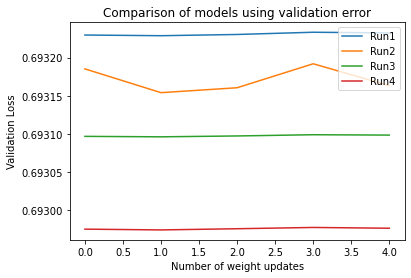

In [228]:
# Plotting validation loss of all the trials vs the Number of weight updates
plt.plot(bp_validation_error1)
plt.plot(bp_validation_error2)
plt.plot(bp_validation_error3)
plt.plot(bp_validation_error4)
plt.title('Comparison of models using validation error')
plt.ylabel('Validation Loss')
plt.xlabel('Number of weight updates')
plt.legend(['Run1', 'Run2', 'Run3', 'Run4'], loc='upper right')
plt.show()

In [229]:
# Storing the final validation for all models in a list
lowest_loss_obtained = [bp_validation_error1[-1],bp_validation_error2[-1],bp_validation_error3[-1],bp_validation_error4[-1]]

# Storing the time complexities for all models in a list
time_complexities = [bp_time_complexity1,bp_time_complexity2,bp_time_complexity3,bp_time_complexity4]

# Creating a list with all the model names
models = ['Run1', 'Run2', 'Run3', 'Run4']

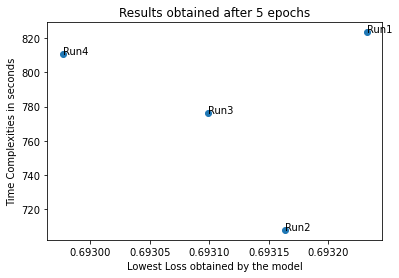

In [230]:
# Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation error
fig,ax = plt.subplots()
ax.scatter(lowest_loss_obtained, time_complexities)

plt.title('Results obtained after 5 epochs')
plt.ylabel('Time Complexities in seconds')
plt.xlabel('Lowest Loss obtained by the model')

for x,y in enumerate(models):
    ax.annotate(y, (lowest_loss_obtained[x], time_complexities[x]))    

In [231]:
architecture1_mean = statistics.mean(lowest_loss_obtained)
print('Architecture1 Validation Loss Mean: ', architecture1_mean)

Architecture1 Validation Loss Mean:  0.6931177228689194


In [232]:
architecture1_stddev = statistics.stdev(lowest_loss_obtained)
print('Architecture1 Validation Loss Std Dev: ', architecture1_stddev)

Architecture1 Validation Loss Std Dev:  0.0001086604431096238


In [233]:
architecture1_time_mean = statistics.mean(time_complexities)
print('Architecture1 Time Complexity Mean: ', architecture1_time_mean)

Architecture1 Time Complexity Mean:  779.553213645966


In [234]:
acc_list = [bp_validation_acc1[-1],bp_validation_acc2[-1],bp_validation_acc3[-1],bp_validation_acc4[-1]]
architecture1_acc_mean = statistics.mean(acc_list)
print('Architecture1 Validation Accuracy Mean: ', architecture1_acc_mean*100)

Architecture1 Validation Accuracy Mean:  50.069962441921234


### Architecture2 - 1 GRU layer, 1 hidden layer=40 nodes, epochs=5, batch_size=20, optimizer=adam, activation=tanh

### Run1

In [235]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(GRU(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 116s 309ms/step - loss: 0.6943 - accuracy: 0.4976 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 137s 364ms/step - loss: 0.6935 - accuracy: 0.5093 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 123s 326ms/step - loss: 0.6938 - accuracy: 0.4867 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 153s 408ms/step - loss: 0.6934 - accuracy: 0.5045 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 158s 421ms/step - loss: 0.6940 - accuracy: 0.4891 - val_loss: 0.6933 - val_accuracy: 0.5000


In [236]:
# Calculating the final validation mse
bp_validation_error1 = history_bp.history['val_loss']
print('Final Validation loss for GRU Model for 1st Run:', bp_validation_error1[-1] )

# Calculating the final validation accracy
bp_validation_acc1 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for GRU Model for 1st Run:', bp_validation_acc1[-1] )


# Calculating the time complexity
bp_time_complexity1 = sum(time_bp)
print('Time complexity for GRU Model for 1st Run:', bp_time_complexity1,'seconds')

Final Validation loss for GRU Model for 1st Run: 0.6932540535926819
Final Validation Accuracy for GRU Model for 1st Run: 0.5
Time complexity for GRU Model for 1st Run: 694.07481964014 seconds


### Run2

In [237]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(GRU(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 147s 392ms/step - loss: 0.6934 - accuracy: 0.5037 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 161s 428ms/step - loss: 0.6933 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 142s 377ms/step - loss: 0.6933 - accuracy: 0.4988 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 140s 372ms/step - loss: 0.6932 - accuracy: 0.4931 - val_loss: 0.6931 - val_accuracy: 0.5009
Epoch 5/5
376/376 [==============================] - 140s 372ms/step - loss: 0.6933 - accuracy: 0.4921 - val_loss: 0.6931 - val_accuracy: 0.5009


In [238]:
# Calculating the final validation mse
bp_validation_error2 = history_bp.history['val_loss']
print('Final Validation Loss for GRU Model for 2nd Run:', bp_validation_error2[-1] )

# Calculating the final validation accracy
bp_validation_acc2 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for GRU Model for 2nd Run:', bp_validation_acc2[-1] )


# Calculating the time complexity
bp_time_complexity2 = sum(time_bp)
print('Time complexity for GRU Model for 2nd Run:', bp_time_complexity2,'seconds')

Final Validation Loss for GRU Model for 2nd Run: 0.6930522322654724
Final Validation Accuracy for GRU Model for 2nd Run: 0.5009328126907349
Time complexity for GRU Model for 2nd Run: 738.0011379721109 seconds


### Run3

In [239]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(GRU(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 177s 471ms/step - loss: 0.6944 - accuracy: 0.4975 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 169s 448ms/step - loss: 0.6939 - accuracy: 0.5059 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 190s 505ms/step - loss: 0.6938 - accuracy: 0.4867 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 178s 474ms/step - loss: 0.6934 - accuracy: 0.5043 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 177s 470ms/step - loss: 0.6941 - accuracy: 0.4891 - val_loss: 0.6932 - val_accuracy: 0.5000


In [240]:
# Calculating the final validation mse
bp_validation_error3 = history_bp.history['val_loss']
print('Final Validation Loss for GRU Model for 3rd Run:', bp_validation_error3[-1] )

# Calculating the final validation accracy
bp_validation_acc3 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for GRU Model for 3rd Run:', bp_validation_acc3[-1] )

# Calculating the time complexity
bp_time_complexity3 = sum(time_bp)
print('Time complexity for GRU Model for 3rd Run:', bp_time_complexity3,'seconds')

Final Validation Loss for GRU Model for 3rd Run: 0.6932421326637268
Final Validation Accuracy for GRU Model for 3rd Run: 0.5
Time complexity for GRU Model for 3rd Run: 897.0340685590636 seconds


### Run4

In [241]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(GRU(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 162s 430ms/step - loss: 0.6934 - accuracy: 0.5036 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 152s 403ms/step - loss: 0.6933 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 142s 378ms/step - loss: 0.6933 - accuracy: 0.4967 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 134s 355ms/step - loss: 0.6932 - accuracy: 0.4971 - val_loss: 0.6931 - val_accuracy: 0.5009
Epoch 5/5
376/376 [==============================] - 137s 363ms/step - loss: 0.6933 - accuracy: 0.4937 - val_loss: 0.6931 - val_accuracy: 0.5009


In [242]:
# Calculating the final validation mse
bp_validation_error4 = history_bp.history['val_loss']
print('Final Validation Loss for GRU Model for 4th Run:', bp_validation_error4[-1] )

# Calculating the final validation accracy
bp_validation_acc4 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for GRU Model for 4th Run:', bp_validation_acc4[-1] )

# Calculating the time complexity
bp_time_complexity4 = sum(time_bp)
print('Time complexity for GRU Model for 4th Run:', bp_time_complexity4,'seconds')

Final Validation Loss for GRU Model for 4th Run: 0.6931086182594299
Final Validation Accuracy for GRU Model for 4th Run: 0.5009328126907349
Time complexity for GRU Model for 4th Run: 731.121070157038 seconds


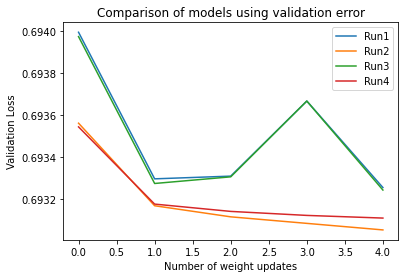

In [243]:
# Plotting validation loss of all the trials vs the Number of weight updates
plt.plot(bp_validation_error1)
plt.plot(bp_validation_error2)
plt.plot(bp_validation_error3)
plt.plot(bp_validation_error4)
plt.title('Comparison of models using validation error')
plt.ylabel('Validation Loss')
plt.xlabel('Number of weight updates')
plt.legend(['Run1', 'Run2', 'Run3', 'Run4'], loc='upper right')
plt.show()

In [244]:
# Storing the final validation for all models in a list
lowest_loss_obtained = [bp_validation_error1[-1],bp_validation_error2[-1],bp_validation_error3[-1],bp_validation_error4[-1]]

# Storing the time complexities for all models in a list
time_complexities = [bp_time_complexity1,bp_time_complexity2,bp_time_complexity3,bp_time_complexity4]

# Creating a list with all the model names
models = ['Run1', 'Run2', 'Run3', 'Run4']

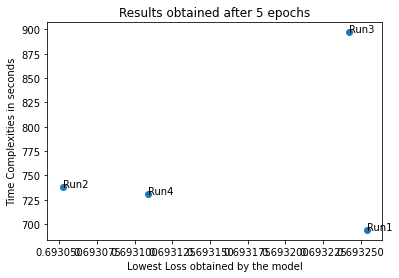

In [245]:
# Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation error
fig,ax = plt.subplots()
ax.scatter(lowest_loss_obtained, time_complexities)

plt.title('Results obtained after 5 epochs')
plt.ylabel('Time Complexities in seconds')
plt.xlabel('Lowest Loss obtained by the model')

for x,y in enumerate(models):
    ax.annotate(y, (lowest_loss_obtained[x], time_complexities[x]))    

In [246]:
architecture2_mean = statistics.mean(lowest_loss_obtained)
print('Architecture2 Validation Loss Mean: ', architecture2_mean)

Architecture2 Validation Loss Mean:  0.6931642591953278


In [247]:
architecture2_stddev = statistics.stdev(lowest_loss_obtained)
print('Architecture2 Validation Loss Std Dev: ', architecture2_stddev)

Architecture2 Validation Loss Std Dev:  9.962137929361857e-05


In [248]:
architecture2_time_mean = statistics.mean(time_complexities)
print('Architecture2 Time Complexity Mean: ', architecture2_time_mean)

Architecture2 Time Complexity Mean:  765.0577740820881


In [249]:
acc_list = [bp_validation_acc1[-1],bp_validation_acc2[-1],bp_validation_acc3[-1],bp_validation_acc4[-1]]
architecture2_acc_mean = statistics.mean(acc_list)
print('Architecture2 Validation Accuracy Mean: ', architecture2_acc_mean*100)

Architecture2 Validation Accuracy Mean:  50.04664063453674


### Architecture3 - 1st GRU layer,  2nd hidden layer=40 nodes, 3rd hidden layer=20 nodes, epochs=5, batch_size=20, optimizer=adam, activation=tanh

### Run1

In [250]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(GRU(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(20, input_dim=40, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 132s 351ms/step - loss: 0.6935 - accuracy: 0.5045 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 127s 338ms/step - loss: 0.6933 - accuracy: 0.5008 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 124s 330ms/step - loss: 0.6933 - accuracy: 0.4957 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 121s 321ms/step - loss: 0.6932 - accuracy: 0.4949 - val_loss: 0.6932 - val_accuracy: 0.5009
Epoch 5/5
376/376 [==============================] - 126s 336ms/step - loss: 0.6933 - accuracy: 0.4912 - val_loss: 0.6931 - val_accuracy: 0.5009


In [251]:
# Calculating the final validation mse
bp_validation_error1 = history_bp.history['val_loss']
print('Final Validation Loss for GRU Model for 1st Run:', bp_validation_error1[-1] )

# Calculating the final validation accracy
bp_validation_acc1 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for GRU Model for 1st Run:', bp_validation_acc1[-1] )


# Calculating the time complexity
bp_time_complexity1 = sum(time_bp)
print('Time complexity for GRU Model for 1st Run:', bp_time_complexity1,'seconds')

Final Validation Loss for GRU Model for 1st Run: 0.6931409239768982
Final Validation Accuracy for GRU Model for 1st Run: 0.5009328126907349
Time complexity for GRU Model for 1st Run: 636.9482932359679 seconds


### Run2

In [252]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(GRU(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(20, input_dim=40, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 154s 410ms/step - loss: 0.6935 - accuracy: 0.5028 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 138s 366ms/step - loss: 0.6933 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 138s 366ms/step - loss: 0.6933 - accuracy: 0.4968 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 107s 285ms/step - loss: 0.6932 - accuracy: 0.4939 - val_loss: 0.6932 - val_accuracy: 0.5009
Epoch 5/5
376/376 [==============================] - 100s 267ms/step - loss: 0.6933 - accuracy: 0.4897 - val_loss: 0.6932 - val_accuracy: 0.5009


In [253]:
# Calculating the final validation mse
bp_validation_error2 = history_bp.history['val_loss']
print('Final Validation Loss for GRU Model for 2nd Run:', bp_validation_error2[-1] )

# Calculating the final validation accracy
bp_validation_acc2 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for GRU Model for 2nd Run:', bp_validation_acc2[-1] )


# Calculating the time complexity
bp_time_complexity2 = sum(time_bp)
print('Time complexity for GRU Model for 2nd Run:', bp_time_complexity2,'seconds')

Final Validation Loss for GRU Model for 2nd Run: 0.6931577324867249
Final Validation Accuracy for GRU Model for 2nd Run: 0.5009328126907349
Time complexity for GRU Model for 2nd Run: 644.6181420700159 seconds


### Run3

In [254]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(GRU(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(20, input_dim=40, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 157s 418ms/step - loss: 0.6936 - accuracy: 0.5017 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 166s 440ms/step - loss: 0.6934 - accuracy: 0.5004 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 163s 433ms/step - loss: 0.6933 - accuracy: 0.4996 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 146s 389ms/step - loss: 0.6932 - accuracy: 0.4963 - val_loss: 0.6932 - val_accuracy: 0.5009
Epoch 5/5
376/376 [==============================] - 132s 351ms/step - loss: 0.6934 - accuracy: 0.4916 - val_loss: 0.6931 - val_accuracy: 0.5009


In [255]:
# Calculating the final validation mse
bp_validation_error3 = history_bp.history['val_loss']
print('Final Validation Loss for GRU Model for 3rd Run:', bp_validation_error3[-1] )

# Calculating the final validation accracy
bp_validation_acc3 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for GRU Model for 3rd Run:', bp_validation_acc3[-1] )

# Calculating the time complexity
bp_time_complexity3 = sum(time_bp)
print('Time complexity for GRU Model for 3rd Run:', bp_time_complexity3,'seconds')

Final Validation Loss for GRU Model for 3rd Run: 0.6931406259536743
Final Validation Accuracy for GRU Model for 3rd Run: 0.5009328126907349
Time complexity for GRU Model for 3rd Run: 771.0440862169489 seconds


### Run4

In [256]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(GRU(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(20, input_dim=40, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 161s 430ms/step - loss: 0.6936 - accuracy: 0.5045 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 168s 446ms/step - loss: 0.6934 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 164s 435ms/step - loss: 0.6934 - accuracy: 0.4984 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 125s 333ms/step - loss: 0.6933 - accuracy: 0.4965 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 118s 314ms/step - loss: 0.6934 - accuracy: 0.4920 - val_loss: 0.6932 - val_accuracy: 0.5009


In [257]:
# Calculating the final validation mse
bp_validation_error4 = history_bp.history['val_loss']
print('Final Validation Loss for GRU Model for 4th Run:', bp_validation_error4[-1] )

# Calculating the final validation accracy
bp_validation_acc4 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for GRU Model for 4th Run:', bp_validation_acc4[-1] )

# Calculating the time complexity
bp_time_complexity4 = sum(time_bp)
print('Time complexity for GRU Model for 4th Run:', bp_time_complexity4,'seconds')

Final Validation Loss for GRU Model for 4th Run: 0.6931771039962769
Final Validation Accuracy for GRU Model for 4th Run: 0.5009328126907349
Time complexity for GRU Model for 4th Run: 742.3312646390405 seconds


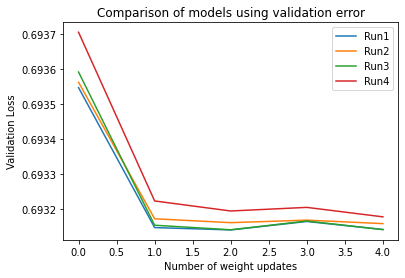

In [258]:
# Plotting validation loss of all the trials vs the Number of weight updates
plt.plot(bp_validation_error1)
plt.plot(bp_validation_error2)
plt.plot(bp_validation_error3)
plt.plot(bp_validation_error4)
plt.title('Comparison of models using validation error')
plt.ylabel('Validation Loss')
plt.xlabel('Number of weight updates')
plt.legend(['Run1', 'Run2', 'Run3', 'Run4'], loc='upper right')
plt.show()

In [259]:
# Storing the final validation for all models in a list
lowest_loss_obtained = [bp_validation_error1[-1],bp_validation_error2[-1],bp_validation_error3[-1],bp_validation_error4[-1]]

# Storing the time complexities for all models in a list
time_complexities = [bp_time_complexity1,bp_time_complexity2,bp_time_complexity3,bp_time_complexity4]

# Creating a list with all the model names
models = ['Run1', 'Run2', 'Run3', 'Run4']

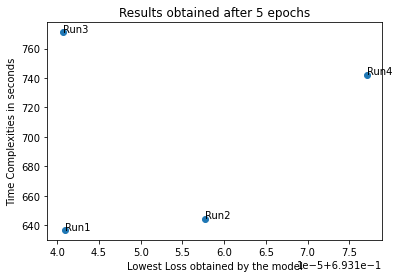

In [260]:
# Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation error
fig,ax = plt.subplots()
ax.scatter(lowest_loss_obtained, time_complexities)

plt.title('Results obtained after 5 epochs')
plt.ylabel('Time Complexities in seconds')
plt.xlabel('Lowest Loss obtained by the model')

for x,y in enumerate(models):
    ax.annotate(y, (lowest_loss_obtained[x], time_complexities[x]))    

In [261]:
architecture3_mean = statistics.mean(lowest_loss_obtained)
print('Architecture3 Validation Loss Mean: ', architecture3_mean)

Architecture3 Validation Loss Mean:  0.6931540966033936


In [262]:
architecture3_stddev = statistics.stdev(lowest_loss_obtained)
print('Architecture3 Validation Loss Std Dev: ', architecture3_stddev)

Architecture3 Validation Loss Std Dev:  1.7296784552146155e-05


In [263]:
architecture3_time_mean = statistics.mean(time_complexities)
print('Architecture3 Time Complexity Mean: ', architecture3_time_mean)

Architecture3 Time Complexity Mean:  698.7354465404933


In [264]:
acc_list = [bp_validation_acc1[-1],bp_validation_acc2[-1],bp_validation_acc3[-1],bp_validation_acc4[-1]]
architecture3_acc_mean = statistics.mean(acc_list)
print('Architecture3 Validation Accuracy Mean: ', architecture3_acc_mean*100)

Architecture3 Validation Accuracy Mean:  50.093281269073486


In [265]:
# Creating a summary table for the model names, lowest MSE and their time complexities
model_summary = pd.DataFrame({"Model":["GRU Architecture1","GRU Architecture2",
                                       "GRU Architecture3"], "Mean Validation loss after 4 trials":[architecture1_mean,architecture2_mean,architecture3_mean],
                              "Mean Standard deviation after 4 trials":[architecture1_stddev,architecture2_stddev,architecture3_stddev],
                            "Mean Time Complexity in seconds after 4 trials":[architecture1_time_mean,architecture2_time_mean,architecture3_time_mean],
                              "Mean Validation Accuracy after 4 trials":[architecture1_acc_mean,architecture2_acc_mean,architecture3_acc_mean]
                                               })

In [266]:
model_summary

,Model,Mean Validation loss after 4 trials,Mean Standard deviation after 4 trials,Mean Time Complexity in seconds after 4 trials,Mean Validation Accuracy after 4 trials
0,GRU Architecture1,0.693118,0.000109,779.553214,0.500700
1,GRU Architecture2,0.693164,0.000100,765.057774,0.500466
2,GRU Architecture3,0.693154,0.000017,698.735447,0.500933


No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.501


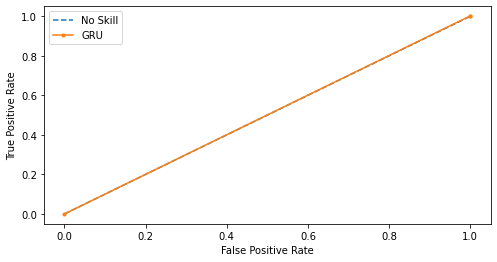

In [267]:
ROC_AUC_curve_upgraded(model=model_bp,model_name="GRU")

### Using Best Model - GRU Architecture1 - with - epochs=20

In [268]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(GRU(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=20, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/20
376/376 [==============================] - 171s 454ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6934 - val_accuracy: 0.4991
Epoch 2/20
376/376 [==============================] - 181s 482ms/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6934 - val_accuracy: 0.4991
Epoch 3/20
376/376 [==============================] - 179s 477ms/step - loss: 0.6932 - accuracy: 0.4971 - val_loss: 0.6934 - val_accuracy: 0.4991
Epoch 4/20
376/376 [==============================] - 177s 470ms/step - loss: 0.6932 - accuracy: 0.4988 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 5/20
376/376 [==============================] - 171s 456ms/step - loss: 0.6933 - accuracy: 0.4933 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 6/20
376/376 [==============================] - 165s 440ms/step - loss: 0.6932 - accuracy: 0.4941 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 7/20
376/376 [==============================] - 166s 442ms/step - loss: 0.6933 - accuracy: 0.4912 - val_loss: 0.6934 -

In [269]:
# Calculating the final validation loss
bp_validation_error_best = history_bp.history['val_loss']
print('Final Validation Loss for Best GRU Model:', bp_validation_error_best[-1] )

# Calculating the final validation accracy
bp_validation_acc_best = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Best GRU Model:', bp_validation_acc_best[-1] )


# Calculating the time complexity
bp_time_complexity_best = sum(time_bp)
print('Time complexity for Best GRU Model:', bp_time_complexity_best,'seconds')

Final Validation Loss for Best GRU Model: 0.6934462189674377
Final Validation Accuracy for Best GRU Model: 0.5
Time complexity for Best GRU Model: 3420.663734086789 seconds


In [270]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(y_true=y_test,y_pred=(model_bp.predict(X_test)>0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       536
           1       0.50      1.00      0.67       536

    accuracy                           0.50      1072
   macro avg       0.25      0.50      0.33      1072
weighted avg       0.25      0.50      0.33      1072



/home/ssingh56/anaconda3/envs/production/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Convolutional Neural Network

- Initially we have set the seed so that model performance does not vary with each run
- Here, we have setup a CNN model
- We have used the activation function as 'relu' for the CNN layer. We have used a 64 filters and 3 kernels and input shape is [features, TimeSteps] i.e. [20,1]
- First conv layer is followed by a flattening layer, followed by 2 hidden layers and a dropout layer
- We have used the loss function as 'BCE' and optimizer as 'adam'
- Hyperparameters used for training:
       - epochs = 5
       - batch_size = 20


- CNN model performed with the below performance on the testing dataset:
- Accuracy: 50%

### Architecture1 - 1 CNN layer , optimizer=SGD, activation=relu, epochs=5, batch_size=20

### Run1

In [80]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (20,1)))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 16s 44ms/step - loss: 7.7126 - accuracy: 0.5000 - val_loss: 7.7130 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 30s 80ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7129 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 23s 62ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7129 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 20s 53ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7128 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 18s 48ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7128 - val_accuracy: 0.5000


In [81]:
# Calculating the final validation mse
bp_validation_error1 = history_bp.history['val_loss']
print('Final Validation Loss for CNN Model for 1st Run:', bp_validation_error1[-1] )

# Calculating the final validation accracy
bp_validation_acc1 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for CNN Model for 1st Run:', bp_validation_acc1[-1] )


# Calculating the time complexity
bp_time_complexity1 = sum(time_bp)
print('Time complexity for CNN Model for 1st Run:', bp_time_complexity1,'seconds')

Final Validation Loss for CNN Model for 1st Run: 7.712820529937744
Final Validation Accuracy for CNN Model for 1st Run: 0.5
Time complexity for CNN Model for 1st Run: 109.60063244518824 seconds


### Run2

In [82]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (20,1)))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 30s 81ms/step - loss: 7.7307 - accuracy: 0.4981 - val_loss: 7.7128 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 16s 42ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7127 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 37s 98ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7127 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 37s 99ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7127 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 29s 76ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7127 - val_accuracy: 0.5000


In [83]:
# Calculating the final validation mse
bp_validation_error2 = history_bp.history['val_loss']
print('Final Validation Loss for CNN Model for 2nd Run:', bp_validation_error2[-1] )

# Calculating the final validation accracy
bp_validation_acc2 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for CNN Model for 2nd Run:', bp_validation_acc2[-1] )


# Calculating the time complexity
bp_time_complexity2 = sum(time_bp)
print('Time complexity for CNN Model for 2nd Run:', bp_time_complexity2,'seconds')

Final Validation Loss for CNN Model for 2nd Run: 7.712721347808838
Final Validation Accuracy for CNN Model for 2nd Run: 0.5
Time complexity for CNN Model for 2nd Run: 150.65406192594673 seconds


### Run3

In [84]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (20,1)))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 30s 79ms/step - loss: 7.5010 - accuracy: 0.5099 - val_loss: 7.7128 - val_accuracy: 0.4999
Epoch 2/5
376/376 [==============================] - 34s 89ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7128 - val_accuracy: 0.4999
Epoch 3/5
376/376 [==============================] - 20s 52ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7128 - val_accuracy: 0.4999
Epoch 4/5
376/376 [==============================] - 16s 44ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7128 - val_accuracy: 0.4999
Epoch 5/5
376/376 [==============================] - 10s 27ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7128 - val_accuracy: 0.4999


In [85]:
# Calculating the final validation mse
bp_validation_error3 = history_bp.history['val_loss']
print('Final Validation Loss for CNN Model for 3rd Run:', bp_validation_error3[-1] )

# Calculating the final validation accracy
bp_validation_acc3 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for CNN Model for 3rd Run:', bp_validation_acc3[-1] )


# Calculating the time complexity
bp_time_complexity3 = sum(time_bp)
print('Time complexity for CNN Model for 3rd Run:', bp_time_complexity3,'seconds')

Final Validation Loss for CNN Model for 3rd Run: 7.712752342224121
Final Validation Accuracy for CNN Model for 3rd Run: 0.4999481737613678
Time complexity for CNN Model for 3rd Run: 110.64049764897209 seconds


### Run4

In [86]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (20,1)))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 27s 72ms/step - loss: 7.6080 - accuracy: 0.5008 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 32s 86ms/step - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 27s 71ms/step - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 24s 65ms/step - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 28s 73ms/step - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000


In [87]:
# Calculating the final validation mse
bp_validation_error4 = history_bp.history['val_loss']
print('Final Validation Loss for CNN Model for 4th Run:', bp_validation_error4[-1] )

# Calculating the final validation accracy
bp_validation_acc4 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for CNN Model for 4th Run:', bp_validation_acc4[-1] )


# Calculating the time complexity
bp_time_complexity4 = sum(time_bp)
print('Time complexity for CNN Model for 4th Run:', bp_time_complexity4,'seconds')

Final Validation Loss for CNN Model for 4th Run: 7.62462043762207
Final Validation Accuracy for CNN Model for 4th Run: 0.5
Time complexity for CNN Model for 4th Run: 139.8169573979685 seconds


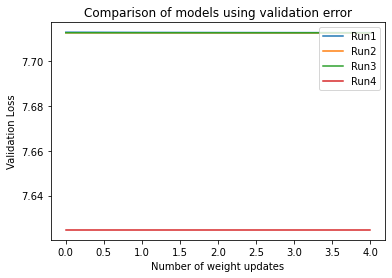

In [88]:
# Plotting validation loss of all the trials vs the Number of weight updates
plt.plot(bp_validation_error1)
plt.plot(bp_validation_error2)
plt.plot(bp_validation_error3)
plt.plot(bp_validation_error4)
plt.title('Comparison of models using validation error')
plt.ylabel('Validation Loss')
plt.xlabel('Number of weight updates')
plt.legend(['Run1', 'Run2', 'Run3', 'Run4'], loc='upper right')
plt.show()

In [89]:
# Storing the final validation for all models in a list
lowest_loss_obtained = [bp_validation_error1[-1],bp_validation_error2[-1],bp_validation_error3[-1],bp_validation_error4[-1]]

# Storing the time complexities for all models in a list
time_complexities = [bp_time_complexity1,bp_time_complexity2,bp_time_complexity3,bp_time_complexity4]

# Creating a list with all the model names
models = ['Run1', 'Run2', 'Run3', 'Run4']

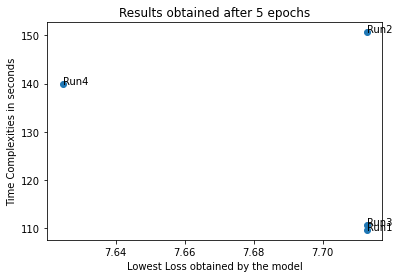

In [90]:
# Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation error
fig,ax = plt.subplots()
ax.scatter(lowest_loss_obtained, time_complexities)

plt.title('Results obtained after 5 epochs')
plt.ylabel('Time Complexities in seconds')
plt.xlabel('Lowest Loss obtained by the model')

for x,y in enumerate(models):
    ax.annotate(y, (lowest_loss_obtained[x], time_complexities[x]))    

In [91]:
architecture1_mean = statistics.mean(lowest_loss_obtained)
print('Architecture1 Validation Loss Mean: ', architecture1_mean)

Architecture1 Validation Loss Mean:  7.690728664398193


In [92]:
architecture1_stddev = statistics.stdev(lowest_loss_obtained)
print('Architecture1 Validation Loss Std Dev: ', architecture1_stddev)

Architecture1 Validation Loss Std Dev:  0.04407217065632992


In [93]:
architecture1_time_mean = statistics.mean(time_complexities)
print('Architecture1 Time Complexity Mean: ', architecture1_time_mean)

Architecture1 Time Complexity Mean:  127.67803735451889


In [94]:
acc_list = [bp_validation_acc1[-1],bp_validation_acc2[-1],bp_validation_acc3[-1],bp_validation_acc4[-1]]
architecture1_acc_mean = statistics.mean(acc_list)
print('Architecture1 Validation Accuracy Mean: ', architecture1_acc_mean*100)

Architecture1 Validation Accuracy Mean:  49.998704344034195


### Architecture2 - 1 CNN layer, 1 hidden layer=40 nodes, epochs=5, batch_size=20, optimizer=adam, activation=relu

### Run1

In [55]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (20,1)))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 43s 115ms/step - loss: 7.6928 - accuracy: 0.5005 - val_loss: 7.7127 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 39s 103ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7127 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 41s 108ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7126 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 37s 98ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 35s 93ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000


In [56]:
# Calculating the final validation mse
bp_validation_error1 = history_bp.history['val_loss']
print('Final Validation loss for CNN Model for 1st Run:', bp_validation_error1[-1] )

# Calculating the final validation accracy
bp_validation_acc1 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for CNN Model for 1st Run:', bp_validation_acc1[-1] )


# Calculating the time complexity
bp_time_complexity1 = sum(time_bp)
print('Time complexity for CNN Model for 1st Run:', bp_time_complexity1,'seconds')

Final Validation loss for CNN Model for 1st Run: 7.712503433227539
Final Validation Accuracy for CNN Model for 1st Run: 0.5
Time complexity for CNN Model for 1st Run: 196.52165232691914 seconds


### Run2

In [48]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (20,1)))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 34s 91ms/step - loss: 7.6612 - accuracy: 0.5024 - val_loss: 7.7126 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 30s 80ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 25s 67ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 42s 111ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 44s 116ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000


In [49]:
# Calculating the final validation mse
bp_validation_error2 = history_bp.history['val_loss']
print('Final Validation Loss for CNN Model for 2nd Run:', bp_validation_error2[-1] )

# Calculating the final validation accracy
bp_validation_acc2 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for CNN Model for 2nd Run:', bp_validation_acc2[-1] )


# Calculating the time complexity
bp_time_complexity2 = sum(time_bp)
print('Time complexity for CNN Model for 2nd Run:', bp_time_complexity2,'seconds')

Final Validation Loss for CNN Model for 2nd Run: 7.712494373321533
Final Validation Accuracy for CNN Model for 2nd Run: 0.5
Time complexity for CNN Model for 2nd Run: 177.80335812678095 seconds


### Run3

In [50]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (20,1)))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 26s 68ms/step - loss: 7.7013 - accuracy: 0.5000 - val_loss: 7.7126 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 35s 93ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7126 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 34s 91ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 34s 91ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 30s 81ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000


In [51]:
# Calculating the final validation mse
bp_validation_error3 = history_bp.history['val_loss']
print('Final Validation Loss for CNN Model for 3rd Run:', bp_validation_error3[-1] )

# Calculating the final validation accracy
bp_validation_acc3 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for CNN Model for 3rd Run:', bp_validation_acc3[-1] )

# Calculating the time complexity
bp_time_complexity3 = sum(time_bp)
print('Time complexity for CNN Model for 3rd Run:', bp_time_complexity3,'seconds')

Final Validation Loss for CNN Model for 3rd Run: 7.712502479553223
Final Validation Accuracy for CNN Model for 3rd Run: 0.5
Time complexity for CNN Model for 3rd Run: 161.33270869590342 seconds


### Run4

In [52]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (20,1)))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 39s 103ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7126 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 35s 92ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 33s 88ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 37s 100ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 30s 79ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000


In [53]:
# Calculating the final validation mse
bp_validation_error4 = history_bp.history['val_loss']
print('Final Validation Loss for CNN Model for 4th Run:', bp_validation_error4[-1] )

# Calculating the final validation accracy
bp_validation_acc4 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for CNN Model for 4th Run:', bp_validation_acc4[-1] )

# Calculating the time complexity
bp_time_complexity4 = sum(time_bp)
print('Time complexity for CNN Model for 4th Run:', bp_time_complexity4,'seconds')

Final Validation Loss for CNN Model for 4th Run: 7.712484359741211
Final Validation Accuracy for CNN Model for 4th Run: 0.5
Time complexity for CNN Model for 4th Run: 175.05790356185753 seconds


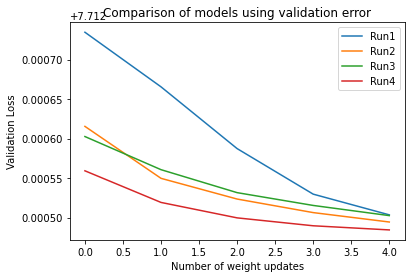

In [57]:
# Plotting validation loss of all the trials vs the Number of weight updates
plt.plot(bp_validation_error1)
plt.plot(bp_validation_error2)
plt.plot(bp_validation_error3)
plt.plot(bp_validation_error4)
plt.title('Comparison of models using validation error')
plt.ylabel('Validation Loss')
plt.xlabel('Number of weight updates')
plt.legend(['Run1', 'Run2', 'Run3', 'Run4'], loc='upper right')
plt.show()

In [58]:
# Storing the final validation for all models in a list
lowest_loss_obtained = [bp_validation_error1[-1],bp_validation_error2[-1],bp_validation_error3[-1],bp_validation_error4[-1]]

# Storing the time complexities for all models in a list
time_complexities = [bp_time_complexity1,bp_time_complexity2,bp_time_complexity3,bp_time_complexity4]

# Creating a list with all the model names
models = ['Run1', 'Run2', 'Run3', 'Run4']

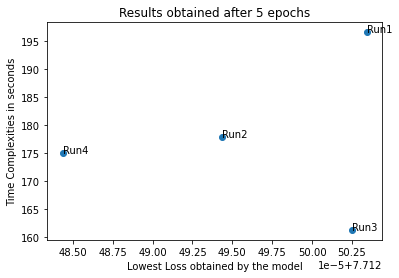

In [59]:
# Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation error
fig,ax = plt.subplots()
ax.scatter(lowest_loss_obtained, time_complexities)

plt.title('Results obtained after 5 epochs')
plt.ylabel('Time Complexities in seconds')
plt.xlabel('Lowest Loss obtained by the model')

for x,y in enumerate(models):
    ax.annotate(y, (lowest_loss_obtained[x], time_complexities[x]))    

In [60]:
architecture2_mean = statistics.mean(lowest_loss_obtained)
print('Architecture2 Validation Loss Mean: ', architecture2_mean)

Architecture2 Validation Loss Mean:  7.7124961614608765


In [61]:
architecture2_stddev = statistics.stdev(lowest_loss_obtained)
print('Architecture2 Validation Loss Std Dev: ', architecture2_stddev)

Architecture2 Validation Loss Std Dev:  8.85578738575109e-06


In [62]:
architecture2_time_mean = statistics.mean(time_complexities)
print('Architecture2 Time Complexity Mean: ', architecture2_time_mean)

Architecture2 Time Complexity Mean:  177.67890567786526


In [63]:
acc_list = [bp_validation_acc1[-1],bp_validation_acc2[-1],bp_validation_acc3[-1],bp_validation_acc4[-1]]
architecture2_acc_mean = statistics.mean(acc_list)
print('Architecture2 Validation Accuracy Mean: ', architecture2_acc_mean*100)

Architecture2 Validation Accuracy Mean:  50.0


### Architecture3 - 1st CNN layer,  2nd hidden layer=40 nodes, 3rd hidden layer=20 nodes, epochs=5, batch_size=20, optimizer=adam, activation=relu

### Run1

In [64]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (20,1)))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(20, input_dim=40, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 52s 139ms/step - loss: 7.6584 - accuracy: 0.5024 - val_loss: 7.7127 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 52s 139ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7126 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 52s 139ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7126 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 42s 111ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 57s 151ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000


In [65]:
# Calculating the final validation mse
bp_validation_error1 = history_bp.history['val_loss']
print('Final Validation Loss for CNN Model for 1st Run:', bp_validation_error1[-1] )

# Calculating the final validation accracy
bp_validation_acc1 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for CNN Model for 1st Run:', bp_validation_acc1[-1] )


# Calculating the time complexity
bp_time_complexity1 = sum(time_bp)
print('Time complexity for CNN Model for 1st Run:', bp_time_complexity1,'seconds')

Final Validation Loss for CNN Model for 1st Run: 7.712514400482178
Final Validation Accuracy for CNN Model for 1st Run: 0.5
Time complexity for CNN Model for 1st Run: 257.135272670188 seconds


### Run2

In [66]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (20,1)))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(20, input_dim=40, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 48s 128ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 50s 134ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 39s 104ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 40s 106ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 34s 90ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000


In [67]:
# Calculating the final validation mse
bp_validation_error2 = history_bp.history['val_loss']
print('Final Validation Loss for CNN Model for 2nd Run:', bp_validation_error2[-1] )

# Calculating the final validation accracy
bp_validation_acc2 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for CNN Model for 2nd Run:', bp_validation_acc2[-1] )


# Calculating the time complexity
bp_time_complexity2 = sum(time_bp)
print('Time complexity for CNN Model for 2nd Run:', bp_time_complexity2,'seconds')

Final Validation Loss for CNN Model for 2nd Run: 7.712478160858154
Final Validation Accuracy for CNN Model for 2nd Run: 0.5
Time complexity for CNN Model for 2nd Run: 213.8270866270177 seconds


### Run3

In [68]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (20,1)))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(20, input_dim=40, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 36s 95ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 43s 115ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 54s 143ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 26s 68ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 36s 95ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000


In [69]:
# Calculating the final validation mse
bp_validation_error3 = history_bp.history['val_loss']
print('Final Validation Loss for CNN Model for 3rd Run:', bp_validation_error3[-1] )

# Calculating the final validation accracy
bp_validation_acc3 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for CNN Model for 3rd Run:', bp_validation_acc3[-1] )

# Calculating the time complexity
bp_time_complexity3 = sum(time_bp)
print('Time complexity for CNN Model for 3rd Run:', bp_time_complexity3,'seconds')

Final Validation Loss for CNN Model for 3rd Run: 7.7124762535095215
Final Validation Accuracy for CNN Model for 3rd Run: 0.5
Time complexity for CNN Model for 3rd Run: 196.16501340980176 seconds


### Run4

In [70]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (20,1)))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(20, input_dim=40, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
376/376 [==============================] - 47s 125ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 2/5
376/376 [==============================] - 55s 147ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 3/5
376/376 [==============================] - 37s 100ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 4/5
376/376 [==============================] - 55s 147ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000
Epoch 5/5
376/376 [==============================] - 43s 114ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7125 - val_accuracy: 0.5000


In [71]:
# Calculating the final validation mse
bp_validation_error4 = history_bp.history['val_loss']
print('Final Validation Loss for CNN Model for 4th Run:', bp_validation_error4[-1] )

# Calculating the final validation accracy
bp_validation_acc4 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for CNN Model for 4th Run:', bp_validation_acc4[-1] )

# Calculating the time complexity
bp_time_complexity4 = sum(time_bp)
print('Time complexity for CNN Model for 4th Run:', bp_time_complexity4,'seconds')

Final Validation Loss for CNN Model for 4th Run: 7.712477207183838
Final Validation Accuracy for CNN Model for 4th Run: 0.5
Time complexity for CNN Model for 4th Run: 240.23848771699704 seconds


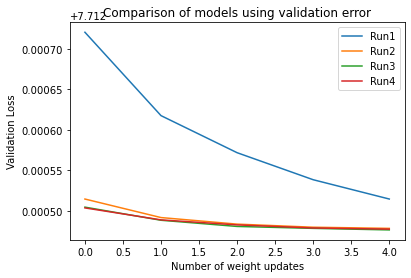

In [72]:
# Plotting validation loss of all the trials vs the Number of weight updates
plt.plot(bp_validation_error1)
plt.plot(bp_validation_error2)
plt.plot(bp_validation_error3)
plt.plot(bp_validation_error4)
plt.title('Comparison of models using validation error')
plt.ylabel('Validation Loss')
plt.xlabel('Number of weight updates')
plt.legend(['Run1', 'Run2', 'Run3', 'Run4'], loc='upper right')
plt.show()

In [73]:
# Storing the final validation for all models in a list
lowest_loss_obtained = [bp_validation_error1[-1],bp_validation_error2[-1],bp_validation_error3[-1],bp_validation_error4[-1]]

# Storing the time complexities for all models in a list
time_complexities = [bp_time_complexity1,bp_time_complexity2,bp_time_complexity3,bp_time_complexity4]

# Creating a list with all the model names
models = ['Run1', 'Run2', 'Run3', 'Run4']

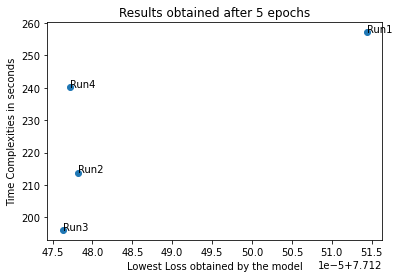

In [74]:
# Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation error
fig,ax = plt.subplots()
ax.scatter(lowest_loss_obtained, time_complexities)

plt.title('Results obtained after 5 epochs')
plt.ylabel('Time Complexities in seconds')
plt.xlabel('Lowest Loss obtained by the model')

for x,y in enumerate(models):
    ax.annotate(y, (lowest_loss_obtained[x], time_complexities[x]))    

In [75]:
architecture3_mean = statistics.mean(lowest_loss_obtained)
print('Architecture3 Validation Loss Mean: ', architecture3_mean)

Architecture3 Validation Loss Mean:  7.712486505508423


In [76]:
architecture3_stddev = statistics.stdev(lowest_loss_obtained)
print('Architecture3 Validation Loss Std Dev: ', architecture3_stddev)

Architecture3 Validation Loss Std Dev:  1.8612944155891565e-05


In [77]:
architecture3_time_mean = statistics.mean(time_complexities)
print('Architecture3 Time Complexity Mean: ', architecture3_time_mean)

Architecture3 Time Complexity Mean:  226.84146510600112


In [78]:
acc_list = [bp_validation_acc1[-1],bp_validation_acc2[-1],bp_validation_acc3[-1],bp_validation_acc4[-1]]
architecture3_acc_mean = statistics.mean(acc_list)
print('Architecture3 Validation Accuracy Mean: ', architecture3_acc_mean*100)

Architecture3 Validation Accuracy Mean:  50.0


In [95]:
# Creating a summary table for the model names, lowest MSE and their time complexities
model_summary = pd.DataFrame({"Model":["CNN Architecture1","CNN Architecture2",
                                       "CNN Architecture3"], "Mean Validation loss after 4 trials":[architecture1_mean,architecture2_mean,architecture3_mean],
                              "Mean Standard deviation after 4 trials":[architecture1_stddev,architecture2_stddev,architecture3_stddev],
                            "Mean Time Complexity in seconds after 4 trials":[architecture1_time_mean,architecture2_time_mean,architecture3_time_mean],
                              "Mean Validation Accuracy after 4 trials":[architecture1_acc_mean,architecture2_acc_mean,architecture3_acc_mean]
                                               })

In [96]:
model_summary

,Model,Mean Validation loss after 4 trials,Mean Standard deviation after 4 trials,Mean Time Complexity in seconds after 4 trials,Mean Validation Accuracy after 4 trials
0,CNN Architecture1,7.690729,0.044072,127.678037,0.499987
1,CNN Architecture2,7.712496,0.000009,177.678906,0.500000
2,CNN Architecture3,7.712487,0.000019,226.841465,0.500000


### Using Best Model - CNN Architecture1 - with - epochs=20

In [98]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (20,1)))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=20, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/20
376/376 [==============================] - 24s 63ms/step - loss: 7.7126 - accuracy: 0.5000 - val_loss: 7.7131 - val_accuracy: 0.5000
Epoch 2/20
376/376 [==============================] - 18s 47ms/step - loss: 7.7126 - accuracy: 0.5000 - val_loss: 7.7130 - val_accuracy: 0.5000
Epoch 3/20
376/376 [==============================] - 15s 41ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7129 - val_accuracy: 0.5000
Epoch 4/20
376/376 [==============================] - 22s 59ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7129 - val_accuracy: 0.5000
Epoch 5/20
376/376 [==============================] - 20s 52ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7129 - val_accuracy: 0.5000
Epoch 6/20
376/376 [==============================] - 19s 50ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7128 - val_accuracy: 0.5000
Epoch 7/20
376/376 [==============================] - 20s 52ms/step - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7128 - val_accuracy:

In [99]:
# Calculating the final validation loss
bp_validation_error_best = history_bp.history['val_loss']
print('Final Validation Loss for Best CNN Model:', bp_validation_error_best[-1] )

# Calculating the final validation accracy
bp_validation_acc_best = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Best CNN Model:', bp_validation_acc_best[-1] )


# Calculating the time complexity
bp_time_complexity_best = sum(time_bp)
print('Time complexity for Best CNN Model:', bp_time_complexity_best,'seconds')

Final Validation Loss for Best CNN Model: 7.712725639343262
Final Validation Accuracy for Best CNN Model: 0.5
Time complexity for Best CNN Model: 471.2156661420595 seconds


### Approach 2) Random 70-30 train-test shuffle

- Here, I have performed a Random train-test split with a size ratio of 70-30

- This approach is expected to perform better than previous approach as here the models will be trained on random participants and most probably they will be trained on some features of every participant

In [179]:
# Define X & y for the split
X = train_df.drop('State', axis=1)
y = train_df['State']

In [180]:
# 70-30 train-validation split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

In [181]:
# removing irrelevant columns from train and test datatset
del X_train['Participant']
del X_train['TimeSec']


del X_test['Participant']
del X_test['TimeSec']


### Logistic Regression

- LR model performed with the below performance on the testing dataset:
- Accuracy: 72%
- Precision: 75%
- Recall: 71%
- F1-Score: 73%
- AUC: 78.9%

In [40]:
# initializing the LR model
lr=LogisticRegression(random_state=32,solver="liblinear")

In [41]:
# Performing grid search to find the best hyper-parameters
param_grid_lr = {
              'C': [.001,.005,.01,0.1,0.3,0.5,1,3,5,10],
              'penalty': ['l1', 'l2']
              }

In [42]:
# Using 5 fold cross validation and evaluation metric as Recall
grid_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='recall', n_jobs=-1, verbose=1)

In [43]:
# Fitting LR model
lr_model = grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.0s finished


In [44]:
# printing best hyper-parameters for model
lr_best_params = grid_lr.best_params_
print(lr_best_params)

{'C': 1, 'penalty': 'l2'}


In [45]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(lr_model.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.70      0.73      0.72      1220
           1       0.75      0.71      0.73      1353

    accuracy                           0.72      2573
   macro avg       0.72      0.72      0.72      2573
weighted avg       0.73      0.72      0.72      2573



No Skill: ROC AUC=0.500
Model: ROC AUC=0.789


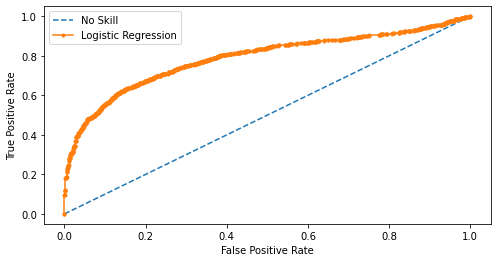

In [46]:
# printing ROC curve
ROC_AUC_curve(model=lr_model,model_name="Logistic Regression")

### LR coefficients 
- As we have used the l2 regularization paramater, we can see that the coefficients for features are close to zero but not exactly zero
- We can also conclude that 'MouthAspectRatio' has the highest coefficient indicating that 'MouthAspectRatio' increases the odds of having the Drowsy state the most
- Similarly, we can conclude that 'EyeAspectRatio' - increases the odds of having the Drowsy state the least

In [47]:
# printing the coefficients of LR model
lr_coefficients=OrderedDict(sorted(zip(X_train.columns,grid_lr.best_estimator_.coef_[0]),reverse=True,key=lambda x:x[1]))

In [48]:
# printing the coefficients 
pd.Series(lr_coefficients)

MouthAspectRatio         0.317444
PupilCircularity_lag2    0.311677
MouthAspectRatio_lag3    0.309178
MouthAspectRatio_lag1    0.268479
PupilCircularity_lag1    0.214938
PupilCircularity_lag4    0.212626
PupilCircularity         0.203085
PupilCircularity_lag3    0.194882
MouthAspectRatio_lag4    0.148484
MouthAspectRatio_lag2    0.030088
MouthOverEye_lag1       -0.155390
MouthOverEye_lag3       -0.160265
MouthOverEye_lag2       -0.180826
MouthOverEye_lag4       -0.219781
MouthOverEye            -0.275149
EyeAspectRatio_lag3     -0.569626
EyeAspectRatio_lag1     -0.576443
EyeAspectRatio_lag4     -0.658455
EyeAspectRatio_lag2     -0.709766
EyeAspectRatio          -0.755044
dtype: float64

### Naive Bayes 

- NB model performed with the below performance on the testing dataset:
- Accuracy: 70%
- Precision: 70%
- Recall: 70%
- F1-Score: 70%
- AUC: 76.4%

In [49]:
# initializing the gaussian naive bayes model
gnb = GaussianNB()

In [50]:
# Performing grid search to find the best hyper-parameters
param_grid_gnb = {
              'var_smoothing': [.001,.005,.01,0.1,0.3]
              }

In [51]:
# Using 5 fold cross validation and evaluation metric as Recall
grid_gnb = GridSearchCV(gnb, param_grid_gnb, cv=5, scoring='recall', n_jobs=-1, verbose=1)

In [52]:
# Fitting NBC model
gnb_model = grid_gnb.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.6s finished


In [53]:
# printing best hyper-parameters for model
gnb_best_params = grid_gnb.best_params_
print(gnb_best_params)

{'var_smoothing': 0.001}


In [54]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(gnb_model.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70      1279
           1       0.70      0.70      0.70      1294

    accuracy                           0.70      2573
   macro avg       0.70      0.70      0.70      2573
weighted avg       0.70      0.70      0.70      2573



No Skill: ROC AUC=0.500
Model: ROC AUC=0.764


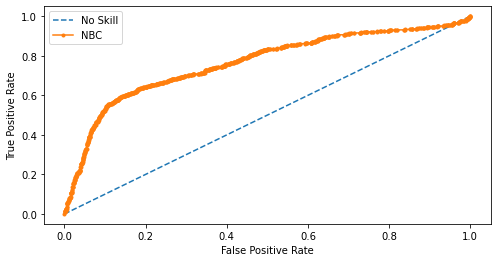

In [55]:
# printing the AUC-ROC for NBC model
ROC_AUC_curve(model=gnb_model,model_name="NBC")

### Decision Trees

- DT model performed with the below performance on the testing dataset:
- Accuracy: 77%
- Precision: 85%
- Recall: 73%
- F1-Score: 79%
- AUC: 85.2%

In [56]:
# initializing the DT model
dt=DecisionTreeClassifier(random_state=42)

In [57]:
# Using grid search for hyper-parameter tuning
param_grid_dt = { 'criterion':['gini','entropy'],
                 'max_features': ['auto','log2'],
              'min_samples_split':[25,50,100,200],
              'max_depth': [5,10,20,25,30],
              'min_samples_leaf': [1,3,5,10,20],
              'max_leaf_nodes': [2,5,10,20,40]}

In [58]:
# Using grid search and evaluation metric as Recall
grid_dt = GridSearchCV(dt, param_grid_dt, scoring='recall', n_jobs=-1, verbose=1)

In [59]:
# Fitting dt model
dt_model = grid_dt.fit(X_train, y_train)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 6018 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 8418 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 9768 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 10000 out of 1000

In [60]:
# printing the best hyper-parameters
dt_best_params = grid_dt.best_params_
print(dt_best_params)

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 50}


In [61]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(dt_model.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.69      0.82      0.75      1086
           1       0.85      0.73      0.79      1487

    accuracy                           0.77      2573
   macro avg       0.77      0.78      0.77      2573
weighted avg       0.78      0.77      0.77      2573



No Skill: ROC AUC=0.500
Model: ROC AUC=0.852


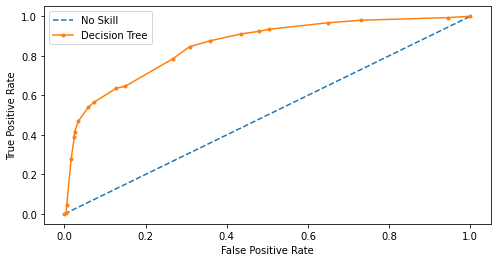

In [62]:
# ROC curve for DT model
ROC_AUC_curve(model=dt_model,model_name="Decision Tree")

### Feature importance
- According to DT model, the top 10 features that are most helpful in predicting the Drowsy state are:
- MouthOverEye_lag2
- MouthAspectRatio_lag4
- MouthOverEye
- PupilCircularity_lag3
- PupilCircularity_lag4
- EyeAspectRatio_lag4
- PupilCircularity_lag1
- MouthAspectRatio
- MouthOverEye_lag3
- MouthOverEye_lag1

In [63]:
# creating a new dataframe to store the features and their respective importance values
feature_imp = pd.DataFrame(dt_model.best_estimator_.feature_importances_, index=X_train.columns,
columns=['importance']).sort_values('importance', ascending=False)
feature_imp['features'] = feature_imp.index
feature_imp

,importance,features
MouthOverEye_lag2,0.330105,MouthOverEye_lag2
MouthAspectRatio_lag4,0.135593,MouthAspectRatio_lag4
MouthOverEye,0.130986,MouthOverEye
PupilCircularity_lag3,0.072921,PupilCircularity_lag3
PupilCircularity_lag4,0.069985,PupilCircularity_lag4
EyeAspectRatio_lag4,0.062154,EyeAspectRatio_lag4
PupilCircularity_lag1,0.050843,PupilCircularity_lag1
MouthAspectRatio,0.047091,MouthAspectRatio
MouthOverEye_lag3,0.040118,MouthOverEye_lag3
MouthOverEye_lag1,0.018554,MouthOverEye_lag1


Text(0, 0.5, 'FEATURE NAMES')

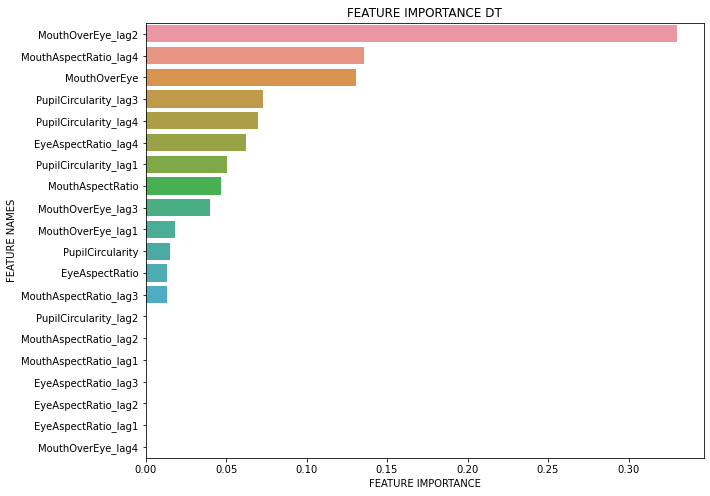

In [64]:
# Plotting Feature Importance graph
plt.figure(figsize=(10,8))

sns.barplot(x=feature_imp['importance'], y=feature_imp['features'])

plt.title('FEATURE IMPORTANCE DT')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')

### Artificial Neural Network with 1 hidden layer

- ANN model performed with the below performance on the testing dataset:
- Accuracy: 77%
- Precision: 80%
- Recall: 71%
- F1-Score: 76%


In [65]:
# initializing the ANN1 model
ann1 = Sequential()
ann1.add(Dense(40, activation='relu', input_shape=(20,)))
ann1.add(Dense(1, activation='sigmoid', input_shape=(40,)))

In [66]:
# compiling ANN1 model
ann1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [67]:
# fitting ANN1 model
ann1.fit(X_train, y_train, epochs=5, batch_size=20, verbose=1,validation_data=(X_test,y_test))

Epoch 1/5
301/301 [==============================] - 9s 31ms/step - loss: 0.5570 - accuracy: 0.7291 - val_loss: 0.5237 - val_accuracy: 0.7384
Epoch 2/5
301/301 [==============================] - 20s 66ms/step - loss: 0.5143 - accuracy: 0.7503 - val_loss: 0.4968 - val_accuracy: 0.7567
Epoch 3/5
301/301 [==============================] - 16s 53ms/step - loss: 0.4946 - accuracy: 0.7528 - val_loss: 0.4838 - val_accuracy: 0.7567
Epoch 4/5
301/301 [==============================] - 14s 46ms/step - loss: 0.4810 - accuracy: 0.7620 - val_loss: 0.4718 - val_accuracy: 0.7614
Epoch 5/5
301/301 [==============================] - 17s 58ms/step - loss: 0.4700 - accuracy: 0.7650 - val_loss: 0.4638 - val_accuracy: 0.7684


In [68]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(y_true=y_test,y_pred=(ann1.predict(X_test)>0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.74      0.82      0.78      1282
           1       0.80      0.71      0.76      1291

    accuracy                           0.77      2573
   macro avg       0.77      0.77      0.77      2573
weighted avg       0.77      0.77      0.77      2573



### K-Nearest Neighbors

- KNN model performed with the below performance on the testing dataset:
- Accuracy: 86%
- Precision: 87%
- Recall: 86%
- F1-Score: 87%

In [69]:
# initializing the model
knn = KNeighborsClassifier()

In [70]:
# Performing grid search to find the best hyper-parameters
param_grid_knn = { 'n_neighbors':[50,100,150,200],
              'weights':['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]
              }

In [71]:
# Using grid search and evaluation metric as Recall
grid_knn = GridSearchCV(knn, param_grid_knn, scoring='recall', n_jobs=-1)

In [72]:
# Fitting knn model
knn_model = grid_knn.fit(X_train, y_train)

In [73]:
# printing the best hyper-parameters
knn_best_params = knn_model.best_params_
print(knn_best_params)

{'algorithm': 'auto', 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}


In [74]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(knn_model.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1274
           1       0.87      0.86      0.87      1299

    accuracy                           0.86      2573
   macro avg       0.86      0.86      0.86      2573
weighted avg       0.86      0.86      0.86      2573



### Linear Support Vector Machine

- Linear SVM model performed with the below performance on the testing dataset:
- Accuracy: 75%
- Precision: 77%
- Recall: 74%
- F1-Score: 76%

In [75]:
# initializing the linear SVC model
lsvm = LinearSVC(random_state=16)

In [76]:
# Performing grid search to find the best hyper-parameters
param_grid_lsvm = { 'C':[.005,.01,.1,.2,.4,.8],
              'penalty':['l1', 'l2'],
              'loss': ['hinge', 'square_hinge']
              }

In [77]:
# Using 5 fold cross validation and evaluation metric as Recall
grid_lsvm = GridSearchCV(lsvm, param_grid_lsvm, cv=5, scoring='recall', n_jobs=-1)

In [78]:
# Fitting linear svc model
lsvm_model = grid_lsvm.fit(X_train, y_train)

/home/ssingh56/anaconda3/envs/production/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [79]:
# printing the best hyper-parameters
lsvm_best_params = grid_lsvm.best_params_
print(lsvm_best_params)

{'C': 0.4, 'loss': 'hinge', 'penalty': 'l2'}


In [80]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(lsvm_model.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.73      0.76      0.75      1236
           1       0.77      0.74      0.76      1337

    accuracy                           0.75      2573
   macro avg       0.75      0.75      0.75      2573
weighted avg       0.75      0.75      0.75      2573



### Random Forest

- RF model performed with the below performance on the testing dataset:
- Accuracy: 87%
- Precision: 84%
- Recall: 89%
- F1-Score: 86%
- AUC: 94.9%

In [81]:
# initializing the RF model
rf=RandomForestClassifier(random_state=16,n_jobs=-1,n_estimators=100)

In [82]:
# Performing grid search to find the best hyper-parameters
param_grid_rf = {'max_depth': [1,25,10, 20, 100],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [10,30,50,100],
             'min_samples_split': [10,50,100,200],
             'n_estimators': [25,50,100,200]}

In [83]:
# Using 5 fold cross validation and evaluation metric as Recall
grid_rf= GridSearchCV(rf, param_grid_rf, cv=3, scoring='recall', n_jobs=-1, verbose=1)

In [84]:
# Fitting RF model
rf_model = grid_rf.fit(X_train, y_train)

Fitting 3 folds for each of 640 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  4.5min finished


In [85]:
# printing the best hyper-parameters
rf_model_best_params = grid_rf.best_params_
print(rf_model_best_params)

{'max_depth': 25, 'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 200}


In [86]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(rf_model.predict(X_test),y_test))


              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1355
           1       0.84      0.89      0.86      1218

    accuracy                           0.87      2573
   macro avg       0.87      0.87      0.87      2573
weighted avg       0.87      0.87      0.87      2573



No Skill: ROC AUC=0.500
Model: ROC AUC=0.949


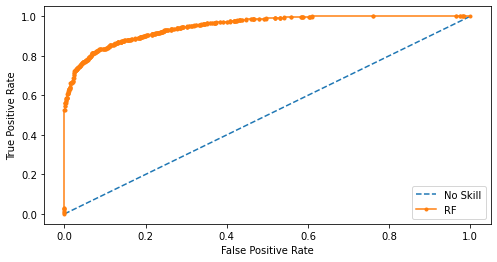

In [87]:
# ROC curve for RF model
ROC_AUC_curve(model=rf_model,model_name="RF")

### Feature importance
- According to RF model, the top 10 features that are most helpful in predicting the Drowsy state are:
- MouthOverEye_lag1
- MouthOverEye
- MouthOverEye_lag4
- MouthOverEye_lag2
- MouthOverEye_lag3
- MouthAspectRatio_lag4
- MouthAspectRatio_lag1
- MouthAspectRatio_lag3
- MouthAspectRatio_lag2
- MouthAspectRatio

In [88]:
# creating a new dataframe to store the features and their respective importance values
feature_imp = pd.DataFrame(rf_model.best_estimator_.feature_importances_, index=X_train.columns,
columns=['importance']).sort_values('importance', ascending=False)
feature_imp['features'] = feature_imp.index
feature_imp

,importance,features
MouthOverEye_lag1,0.085943,MouthOverEye_lag1
MouthOverEye,0.084133,MouthOverEye
MouthOverEye_lag4,0.083661,MouthOverEye_lag4
MouthOverEye_lag2,0.074996,MouthOverEye_lag2
MouthOverEye_lag3,0.071963,MouthOverEye_lag3
MouthAspectRatio_lag4,0.055128,MouthAspectRatio_lag4
MouthAspectRatio_lag1,0.052354,MouthAspectRatio_lag1
MouthAspectRatio_lag3,0.049926,MouthAspectRatio_lag3
MouthAspectRatio_lag2,0.048092,MouthAspectRatio_lag2
MouthAspectRatio,0.046952,MouthAspectRatio


Text(0, 0.5, 'FEATURE NAMES')

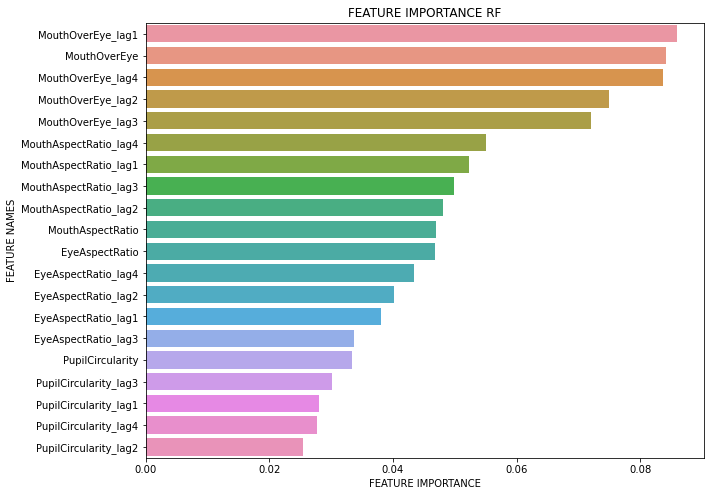

In [89]:
# Plotting Feature Importance graph
plt.figure(figsize=(10,8))

sns.barplot(x=feature_imp['importance'], y=feature_imp['features'])

plt.title('FEATURE IMPORTANCE RF')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')

### Gradient Boosting Machine

- GBM model performed with the below performance on the testing dataset:
- Accuracy: 91%
- Precision: 90%
- Recall: 92%
- F1-Score: 91%
- AUC: 97.2%

In [188]:
# initializing the GBM model
gbm=GradientBoostingClassifier(random_state=16)

In [189]:
# Performing grid search to find the best hyper-parameters
param_grid_gbm = {'max_features': ['auto','sqrt'],
              'n_estimators': [20,50,100,200],
              'subsample':[0.6,0.8,0.9],
              'max_depth': [1,5,20,10,50,100],
              'min_samples_split':[25,50,100,200],
              'min_samples_leaf':[10,30,50,100]}

In [194]:
# Using cross validation and evaluation metric as Recall
grid_gbm= GridSearchCV(gbm, param_grid_gbm, cv=2, scoring='recall', n_jobs=-1, verbose=1)

In [195]:
# Fitting GBM model
gbm_model = grid_gbm.fit(X_train, y_train)

Fitting 2 folds for each of 2304 candidates, totalling 4608 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed: 32.2min
[Parallel(n_jobs=-1)]: Done 4608 out of 4608 | elapsed: 36.1min finished


In [196]:
# printing the best hyper-parameters
gbm_best_params = grid_gbm.best_params_
print(gbm_best_params)

{'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 30, 'min_samples_split': 100, 'n_estimators': 200, 'subsample': 0.8}


In [197]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(gbm_model.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1308
           1       0.90      0.92      0.91      1265

    accuracy                           0.91      2573
   macro avg       0.91      0.91      0.91      2573
weighted avg       0.91      0.91      0.91      2573



No Skill: ROC AUC=0.500
Model: ROC AUC=0.972


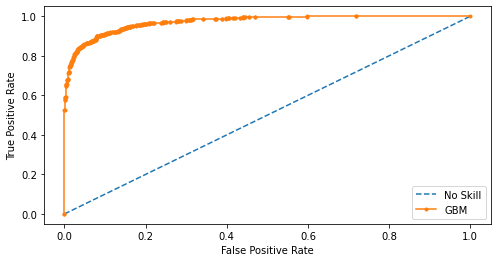

In [198]:
# printing AUC curve for GBM model
ROC_AUC_curve(model=gbm_model,model_name="GBM")

### Feature importance
- According to GBM model, the top 10 features that are most helpful in predicting the Drowsy state are:
- MouthOverEye
- MouthOverEye_lag4
- MouthOverEye_lag3
- MouthAspectRatio_lag2
- MouthOverEye_lag2
- EyeAspectRatio_lag3
- MouthAspectRatio
- MouthAspectRatio_lag4
- MouthOverEye_lag1
- MouthAspectRatio_lag1

In [199]:
# creating a new dataframe to store the features and their respective importance values
feature_imp = pd.DataFrame(gbm_model.best_estimator_.feature_importances_, index=X_train.columns,
columns=['importance']).sort_values('importance', ascending=False)
feature_imp['features'] = feature_imp.index
feature_imp

,importance,features
MouthOverEye,0.121044,MouthOverEye
MouthOverEye_lag4,0.102318,MouthOverEye_lag4
MouthOverEye_lag3,0.071439,MouthOverEye_lag3
MouthAspectRatio_lag2,0.058956,MouthAspectRatio_lag2
MouthOverEye_lag2,0.058647,MouthOverEye_lag2
MouthAspectRatio,0.054972,MouthAspectRatio
MouthAspectRatio_lag4,0.054747,MouthAspectRatio_lag4
MouthOverEye_lag1,0.053235,MouthOverEye_lag1
MouthAspectRatio_lag1,0.049164,MouthAspectRatio_lag1
EyeAspectRatio_lag1,0.041608,EyeAspectRatio_lag1


Text(0, 0.5, 'FEATURE NAMES')

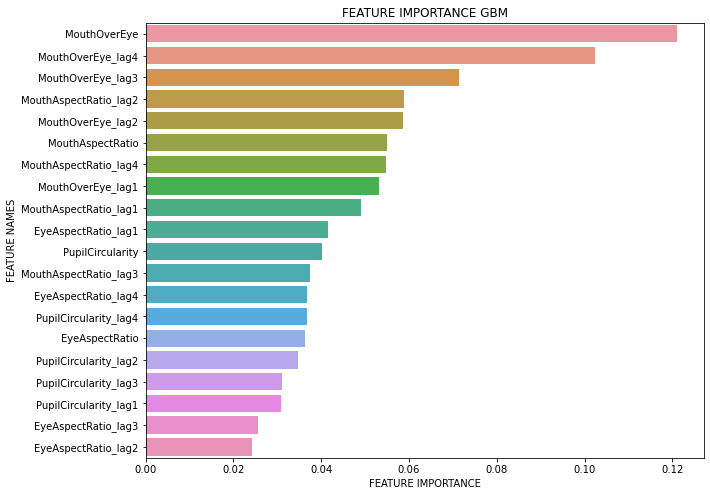

In [200]:
# Plotting Feature Importance graph
plt.figure(figsize=(10,8))

sns.barplot(x=feature_imp['importance'], y=feature_imp['features'])

plt.title('FEATURE IMPORTANCE GBM')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')

### Simple Feed Forward Neural Network

In [182]:
# Time Complexity function
class TimeComplexity(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

### Architecture1 - 1 hidden layer - d-2d, optimizer=SGD, activation=relu, epochs=5, batch_size=20

### Run1

In [105]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 17s 57ms/step - loss: 0.6203 - accuracy: 0.6743 - val_loss: 0.5727 - val_accuracy: 0.7120
Epoch 2/5
301/301 [==============================] - 17s 55ms/step - loss: 0.5603 - accuracy: 0.7148 - val_loss: 0.5532 - val_accuracy: 0.7252
Epoch 3/5
301/301 [==============================] - 18s 59ms/step - loss: 0.5456 - accuracy: 0.7285 - val_loss: 0.5413 - val_accuracy: 0.7276
Epoch 4/5
301/301 [==============================] - 18s 61ms/step - loss: 0.5350 - accuracy: 0.7340 - val_loss: 0.5318 - val_accuracy: 0.7334
Epoch 5/5
301/301 [==============================] - 19s 62ms/step - loss: 0.5268 - accuracy: 0.7371 - val_loss: 0.5243 - val_accuracy: 0.7326


In [106]:
# Calculating the final validation mse
bp_validation_error1 = history_bp.history['val_loss']
print('Final Validation Loss for Plain Backpropagation Model for 1st Run:', bp_validation_error1[-1] )

# Calculating the final validation accracy
bp_validation_acc1 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Plain Backpropagation Model for 1st Run:', bp_validation_acc1[-1] )


# Calculating the time complexity
bp_time_complexity1 = sum(time_bp)
print('Time complexity for Plain Backpropagation Model for 1st Run:', bp_time_complexity1,'seconds')

Final Validation Loss for Plain Backpropagation Model for 1st Run: 0.5243086218833923
Final Validation Accuracy for Plain Backpropagation Model for 1st Run: 0.7326078414916992
Time complexity for Plain Backpropagation Model for 1st Run: 89.78985332709271 seconds


### Run2

In [107]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 21s 70ms/step - loss: 0.5866 - accuracy: 0.7141 - val_loss: 0.5601 - val_accuracy: 0.7248
Epoch 2/5
301/301 [==============================] - 23s 78ms/step - loss: 0.5508 - accuracy: 0.7351 - val_loss: 0.5382 - val_accuracy: 0.7447
Epoch 3/5
301/301 [==============================] - 22s 72ms/step - loss: 0.5349 - accuracy: 0.7418 - val_loss: 0.5246 - val_accuracy: 0.7404
Epoch 4/5
301/301 [==============================] - 22s 72ms/step - loss: 0.5238 - accuracy: 0.7463 - val_loss: 0.5140 - val_accuracy: 0.7450
Epoch 5/5
301/301 [==============================] - 15s 50ms/step - loss: 0.5154 - accuracy: 0.7470 - val_loss: 0.5062 - val_accuracy: 0.7482


In [108]:
# Calculating the final validation mse
bp_validation_error2 = history_bp.history['val_loss']
print('Final Validation Loss for Plain Backpropagation Model for 2nd Run:', bp_validation_error2[-1] )

# Calculating the final validation accracy
bp_validation_acc2 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Plain Backpropagation Model for 2nd Run:', bp_validation_acc2[-1] )


# Calculating the time complexity
bp_time_complexity2 = sum(time_bp)
print('Time complexity for Plain Backpropagation Model for 2nd Run:', bp_time_complexity2,'seconds')

Final Validation Loss for Plain Backpropagation Model for 2nd Run: 0.5061734318733215
Final Validation Accuracy for Plain Backpropagation Model for 2nd Run: 0.7481539249420166
Time complexity for Plain Backpropagation Model for 2nd Run: 104.1138242649613 seconds


### Run3

In [109]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 19s 65ms/step - loss: 0.6022 - accuracy: 0.6830 - val_loss: 0.5599 - val_accuracy: 0.7361
Epoch 2/5
301/301 [==============================] - 19s 63ms/step - loss: 0.5544 - accuracy: 0.7426 - val_loss: 0.5428 - val_accuracy: 0.7466
Epoch 3/5
301/301 [==============================] - 11s 36ms/step - loss: 0.5408 - accuracy: 0.7493 - val_loss: 0.5315 - val_accuracy: 0.7517
Epoch 4/5
301/301 [==============================] - 16s 53ms/step - loss: 0.5313 - accuracy: 0.7533 - val_loss: 0.5232 - val_accuracy: 0.7583
Epoch 5/5
301/301 [==============================] - 17s 56ms/step - loss: 0.5241 - accuracy: 0.7510 - val_loss: 0.5170 - val_accuracy: 0.7528


In [110]:
# Calculating the final validation mse
bp_validation_error3 = history_bp.history['val_loss']
print('Final Validation Loss for Plain Backpropagation Model for 3rd Run:', bp_validation_error3[-1] )

# Calculating the final validation accracy
bp_validation_acc3 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Plain Backpropagation Model for 3rd Run:', bp_validation_acc3[-1] )


# Calculating the time complexity
bp_time_complexity3 = sum(time_bp)
print('Time complexity for Plain Backpropagation Model for 3rd Run:', bp_time_complexity3,'seconds')

Final Validation Loss for Plain Backpropagation Model for 3rd Run: 0.5169869661331177
Final Validation Accuracy for Plain Backpropagation Model for 3rd Run: 0.7528177499771118
Time complexity for Plain Backpropagation Model for 3rd Run: 83.13926736009307 seconds


### Run4

In [111]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 16s 53ms/step - loss: 0.5966 - accuracy: 0.7155 - val_loss: 0.5738 - val_accuracy: 0.7136
Epoch 2/5
301/301 [==============================] - 19s 64ms/step - loss: 0.5639 - accuracy: 0.7235 - val_loss: 0.5549 - val_accuracy: 0.7334
Epoch 3/5
301/301 [==============================] - 13s 43ms/step - loss: 0.5487 - accuracy: 0.7366 - val_loss: 0.5427 - val_accuracy: 0.7373
Epoch 4/5
301/301 [==============================] - 17s 57ms/step - loss: 0.5381 - accuracy: 0.7433 - val_loss: 0.5326 - val_accuracy: 0.7412
Epoch 5/5
301/301 [==============================] - 19s 62ms/step - loss: 0.5291 - accuracy: 0.7495 - val_loss: 0.5244 - val_accuracy: 0.7443


In [112]:
# Calculating the final validation mse
bp_validation_error4 = history_bp.history['val_loss']
print('Final Validation Loss for Plain Backpropagation Model for 4th Run:', bp_validation_error4[-1] )

# Calculating the final validation accracy
bp_validation_acc4 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Plain Backpropagation Model for 4th Run:', bp_validation_acc4[-1] )


# Calculating the time complexity
bp_time_complexity4 = sum(time_bp)
print('Time complexity for Plain Backpropagation Model for 4th Run:', bp_time_complexity4,'seconds')

Final Validation Loss for Plain Backpropagation Model for 4th Run: 0.5244277119636536
Final Validation Accuracy for Plain Backpropagation Model for 4th Run: 0.7442674040794373
Time complexity for Plain Backpropagation Model for 4th Run: 85.15878261392936 seconds


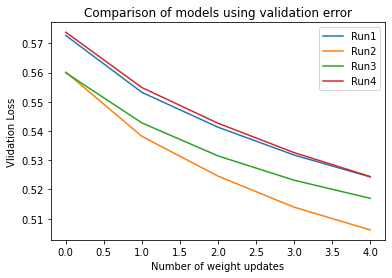

In [113]:
# Plotting validation loss of all the trials vs the Number of weight updates
plt.plot(bp_validation_error1)
plt.plot(bp_validation_error2)
plt.plot(bp_validation_error3)
plt.plot(bp_validation_error4)
plt.title('Comparison of models using validation error')
plt.ylabel('Vlidation Loss')
plt.xlabel('Number of weight updates')
plt.legend(['Run1', 'Run2', 'Run3', 'Run4'], loc='upper right')
plt.show()

In [114]:
# Storing the final validation for all models in a list
lowest_loss_obtained = [bp_validation_error1[-1],bp_validation_error2[-1],bp_validation_error3[-1],bp_validation_error4[-1]]

# Storing the time complexities for all models in a list
time_complexities = [bp_time_complexity1,bp_time_complexity2,bp_time_complexity3,bp_time_complexity4]

# Creating a list with all the model names
models = ['Run1', 'Run2', 'Run3', 'Run4']

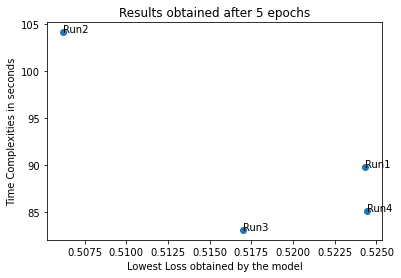

In [115]:
# Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation error
fig,ax = plt.subplots()
ax.scatter(lowest_loss_obtained, time_complexities)

plt.title('Results obtained after 5 epochs')
plt.ylabel('Time Complexities in seconds')
plt.xlabel('Lowest Loss obtained by the model')

for x,y in enumerate(models):
    ax.annotate(y, (lowest_loss_obtained[x], time_complexities[x]))    

In [116]:
architecture1_mean = statistics.mean(lowest_loss_obtained)
print('Architecture1 Validation Loss Mean: ', architecture1_mean)

Architecture1 Validation Loss Mean:  0.5179741829633713


In [117]:
architecture1_stddev = statistics.stdev(lowest_loss_obtained)
print('Architecture1 Validation Loss Std Dev: ', architecture1_stddev)

Architecture1 Validation Loss Std Dev:  0.008602431368479655


In [118]:
architecture1_time_mean = statistics.mean(time_complexities)
print('Architecture1 Time Complexity Mean: ', architecture1_time_mean)

Architecture1 Time Complexity Mean:  90.55043189151911


In [119]:
acc_list = [bp_validation_acc1[-1],bp_validation_acc2[-1],bp_validation_acc3[-1],bp_validation_acc4[-1]]
architecture1_acc_mean = statistics.mean(acc_list)
print('Architecture1 Validation Accuracy Mean: ', architecture1_acc_mean*100)

Architecture1 Validation Accuracy Mean:  74.44617301225662


### Architecture2 - 2 hidden layers - 1st hidden layer=40 nodes, 2nd hidden layer=20 nodes, epochs=5, batch_size=20, optimizer=adam, activation=tanh

### Run1

In [120]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(20, input_dim=40, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 23s 78ms/step - loss: 0.5470 - accuracy: 0.7291 - val_loss: 0.5218 - val_accuracy: 0.7435
Epoch 2/5
301/301 [==============================] - 21s 70ms/step - loss: 0.5014 - accuracy: 0.7511 - val_loss: 0.4884 - val_accuracy: 0.7505
Epoch 3/5
301/301 [==============================] - 20s 68ms/step - loss: 0.4695 - accuracy: 0.7711 - val_loss: 0.4567 - val_accuracy: 0.7730
Epoch 4/5
301/301 [==============================] - 19s 63ms/step - loss: 0.4440 - accuracy: 0.7938 - val_loss: 0.4409 - val_accuracy: 0.7742
Epoch 5/5
301/301 [==============================] - 19s 62ms/step - loss: 0.4248 - accuracy: 0.8096 - val_loss: 0.4192 - val_accuracy: 0.7952


In [121]:
# Calculating the final validation mse
bp_validation_error1 = history_bp.history['val_loss']
print('Final Validation MSE for Plain Backpropagation Model for 1st Run:', bp_validation_error1[-1] )

# Calculating the final validation accracy
bp_validation_acc1 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Plain Backpropagation Model for 1st Run:', bp_validation_acc1[-1] )


# Calculating the time complexity
bp_time_complexity1 = sum(time_bp)
print('Time complexity for Plain Backpropagation Model for 1st Run:', bp_time_complexity1,'seconds')

Final Validation MSE for Plain Backpropagation Model for 1st Run: 0.4192401170730591
Final Validation Accuracy for Plain Backpropagation Model for 1st Run: 0.7951807379722595
Time complexity for Plain Backpropagation Model for 1st Run: 103.98781503608916 seconds


### Run2

In [122]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(20, input_dim=40, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 18s 58ms/step - loss: 0.5470 - accuracy: 0.7271 - val_loss: 0.5174 - val_accuracy: 0.7408
Epoch 2/5
301/301 [==============================] - 25s 83ms/step - loss: 0.5087 - accuracy: 0.7485 - val_loss: 0.4939 - val_accuracy: 0.7419
Epoch 3/5
301/301 [==============================] - 20s 65ms/step - loss: 0.4851 - accuracy: 0.7630 - val_loss: 0.4658 - val_accuracy: 0.7680
Epoch 4/5
301/301 [==============================] - 22s 72ms/step - loss: 0.4587 - accuracy: 0.7794 - val_loss: 0.4455 - val_accuracy: 0.7757
Epoch 5/5
301/301 [==============================] - 17s 56ms/step - loss: 0.4345 - accuracy: 0.7996 - val_loss: 0.4192 - val_accuracy: 0.7983


In [123]:
# Calculating the final validation mse
bp_validation_error2 = history_bp.history['val_loss']
print('Final Validation Loss for Plain Backpropagation Model for 2nd Run:', bp_validation_error2[-1] )

# Calculating the final validation accracy
bp_validation_acc2 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Plain Backpropagation Model for 2nd Run:', bp_validation_acc2[-1] )


# Calculating the time complexity
bp_time_complexity2 = sum(time_bp)
print('Time complexity for Plain Backpropagation Model for 2nd Run:', bp_time_complexity2,'seconds')

Final Validation Loss for Plain Backpropagation Model for 2nd Run: 0.41917717456817627
Final Validation Accuracy for Plain Backpropagation Model for 2nd Run: 0.798289954662323
Time complexity for Plain Backpropagation Model for 2nd Run: 101.94750975910574 seconds


### Run3

In [124]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(20, input_dim=40, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 14s 48ms/step - loss: 0.5434 - accuracy: 0.7281 - val_loss: 0.5134 - val_accuracy: 0.7330
Epoch 2/5
301/301 [==============================] - 13s 43ms/step - loss: 0.4977 - accuracy: 0.7520 - val_loss: 0.4844 - val_accuracy: 0.7419
Epoch 3/5
301/301 [==============================] - 17s 57ms/step - loss: 0.4701 - accuracy: 0.7726 - val_loss: 0.4552 - val_accuracy: 0.7769
Epoch 4/5
301/301 [==============================] - 17s 55ms/step - loss: 0.4473 - accuracy: 0.7911 - val_loss: 0.4424 - val_accuracy: 0.7831
Epoch 5/5
301/301 [==============================] - 21s 68ms/step - loss: 0.4300 - accuracy: 0.8049 - val_loss: 0.4257 - val_accuracy: 0.7917


In [125]:
# Calculating the final validation mse
bp_validation_error3 = history_bp.history['val_loss']
print('Final Validation Loss for Plain Backpropagation Model for 3rd Run:', bp_validation_error3[-1] )

# Calculating the final validation accracy
bp_validation_acc3 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Plain Backpropagation Model for 3rd Run:', bp_validation_acc3[-1] )

# Calculating the time complexity
bp_time_complexity3 = sum(time_bp)
print('Time complexity for Plain Backpropagation Model for 3rd Run:', bp_time_complexity3,'seconds')

Final Validation Loss for Plain Backpropagation Model for 3rd Run: 0.42568835616111755
Final Validation Accuracy for Plain Backpropagation Model for 3rd Run: 0.7916828393936157
Time complexity for Plain Backpropagation Model for 3rd Run: 83.99284316704143 seconds


### Run4

In [126]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(20, input_dim=40, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 20s 67ms/step - loss: 0.5525 - accuracy: 0.7163 - val_loss: 0.5154 - val_accuracy: 0.7252
Epoch 2/5
301/301 [==============================] - 14s 48ms/step - loss: 0.4995 - accuracy: 0.7458 - val_loss: 0.4841 - val_accuracy: 0.7466
Epoch 3/5
301/301 [==============================] - 18s 59ms/step - loss: 0.4694 - accuracy: 0.7673 - val_loss: 0.4515 - val_accuracy: 0.7769
Epoch 4/5
301/301 [==============================] - 16s 54ms/step - loss: 0.4426 - accuracy: 0.7938 - val_loss: 0.4345 - val_accuracy: 0.7905
Epoch 5/5
301/301 [==============================] - 18s 58ms/step - loss: 0.4222 - accuracy: 0.8058 - val_loss: 0.4131 - val_accuracy: 0.8053


In [127]:
# Calculating the final validation mse
bp_validation_error4 = history_bp.history['val_loss']
print('Final Validation Loss for Plain Backpropagation Model for 4th Run:', bp_validation_error4[-1] )

# Calculating the final validation accracy
bp_validation_acc4 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Plain Backpropagation Model for 4th Run:', bp_validation_acc4[-1] )

# Calculating the time complexity
bp_time_complexity4 = sum(time_bp)
print('Time complexity for Plain Backpropagation Model for 4th Run:', bp_time_complexity4,'seconds')

Final Validation Loss for Plain Backpropagation Model for 4th Run: 0.41307592391967773
Final Validation Accuracy for Plain Backpropagation Model for 4th Run: 0.805285632610321
Time complexity for Plain Backpropagation Model for 4th Run: 87.75435161904898 seconds


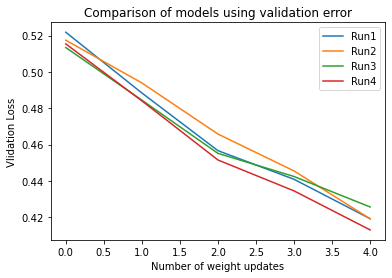

In [128]:
# Plotting validation loss of all the trials vs the Number of weight updates
plt.plot(bp_validation_error1)
plt.plot(bp_validation_error2)
plt.plot(bp_validation_error3)
plt.plot(bp_validation_error4)
plt.title('Comparison of models using validation error')
plt.ylabel('Vlidation Loss')
plt.xlabel('Number of weight updates')
plt.legend(['Run1', 'Run2', 'Run3', 'Run4'], loc='upper right')
plt.show()

In [129]:
# Storing the final validation for all models in a list
lowest_loss_obtained = [bp_validation_error1[-1],bp_validation_error2[-1],bp_validation_error3[-1],bp_validation_error4[-1]]

# Storing the time complexities for all models in a list
time_complexities = [bp_time_complexity1,bp_time_complexity2,bp_time_complexity3,bp_time_complexity4]

# Creating a list with all the model names
models = ['Run1', 'Run2', 'Run3', 'Run4']

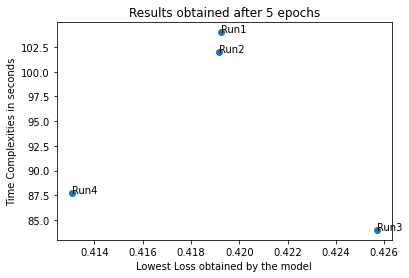

In [130]:
# Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation error
fig,ax = plt.subplots()
ax.scatter(lowest_loss_obtained, time_complexities)

plt.title('Results obtained after 5 epochs')
plt.ylabel('Time Complexities in seconds')
plt.xlabel('Lowest Loss obtained by the model')

for x,y in enumerate(models):
    ax.annotate(y, (lowest_loss_obtained[x], time_complexities[x]))    

In [131]:
architecture2_mean = statistics.mean(lowest_loss_obtained)
print('Architecture2 Validation Loss Mean: ', architecture2_mean)

Architecture2 Validation Loss Mean:  0.41929539293050766


In [132]:
architecture2_stddev = statistics.stdev(lowest_loss_obtained)
print('Architecture2 Validation Loss Std Dev: ', architecture2_stddev)

Architecture2 Validation Loss Std Dev:  0.005150042221387215


In [133]:
architecture2_time_mean = statistics.mean(time_complexities)
print('Architecture2 Time Complexity Mean: ', architecture2_time_mean)

Architecture2 Time Complexity Mean:  94.42062989532133


In [134]:
acc_list = [bp_validation_acc1[-1],bp_validation_acc2[-1],bp_validation_acc3[-1],bp_validation_acc4[-1]]
architecture2_acc_mean = statistics.mean(acc_list)
print('Architecture2 Validation Accuracy Mean: ', architecture2_acc_mean*100)

Architecture2 Validation Accuracy Mean:  79.76097911596298


### Architecture3 - 3 hidden layers - 1st hidden layer=40 nodes, 2nd hidden layer=20 nodes, 3rd hidden layer=10 nodes, epochs=5, batch_size=20, optimizer=adam, activation=relu

### Run1

In [135]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(20, input_dim=40, activation='relu'))
model_bp.add(Dense(10, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 23s 76ms/step - loss: 0.5649 - accuracy: 0.7228 - val_loss: 0.5133 - val_accuracy: 0.7392
Epoch 2/5
301/301 [==============================] - 16s 52ms/step - loss: 0.4810 - accuracy: 0.7616 - val_loss: 0.4508 - val_accuracy: 0.7637
Epoch 3/5
301/301 [==============================] - 19s 64ms/step - loss: 0.4242 - accuracy: 0.7971 - val_loss: 0.3983 - val_accuracy: 0.8146
Epoch 4/5
301/301 [==============================] - 17s 55ms/step - loss: 0.3794 - accuracy: 0.8259 - val_loss: 0.3638 - val_accuracy: 0.8255
Epoch 5/5
301/301 [==============================] - 20s 66ms/step - loss: 0.3500 - accuracy: 0.8357 - val_loss: 0.3381 - val_accuracy: 0.8414


In [136]:
# Calculating the final validation mse
bp_validation_error1 = history_bp.history['val_loss']
print('Final Validation MSE for Plain Backpropagation Model for 1st Run:', bp_validation_error1[-1] )

# Calculating the final validation accracy
bp_validation_acc1 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Plain Backpropagation Model for 1st Run:', bp_validation_acc1[-1] )


# Calculating the time complexity
bp_time_complexity1 = sum(time_bp)
print('Time complexity for Plain Backpropagation Model for 1st Run:', bp_time_complexity1,'seconds')

Final Validation MSE for Plain Backpropagation Model for 1st Run: 0.3380926847457886
Final Validation Accuracy for Plain Backpropagation Model for 1st Run: 0.8414302468299866
Time complexity for Plain Backpropagation Model for 1st Run: 95.55145381891634 seconds


### Run2

In [137]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(20, input_dim=40, activation='relu'))
model_bp.add(Dense(10, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 33s 109ms/step - loss: 0.5435 - accuracy: 0.7353 - val_loss: 0.4903 - val_accuracy: 0.7621
Epoch 2/5
301/301 [==============================] - 22s 72ms/step - loss: 0.4659 - accuracy: 0.7694 - val_loss: 0.4247 - val_accuracy: 0.7750
Epoch 3/5
301/301 [==============================] - 32s 107ms/step - loss: 0.4160 - accuracy: 0.7941 - val_loss: 0.3846 - val_accuracy: 0.8158
Epoch 4/5
301/301 [==============================] - 35s 115ms/step - loss: 0.3803 - accuracy: 0.8214 - val_loss: 0.3614 - val_accuracy: 0.8263
Epoch 5/5
301/301 [==============================] - 37s 123ms/step - loss: 0.3570 - accuracy: 0.8321 - val_loss: 0.3404 - val_accuracy: 0.8360


In [138]:
# Calculating the final validation mse
bp_validation_error2 = history_bp.history['val_loss']
print('Final Validation Loss for Plain Backpropagation Model for 2nd Run:', bp_validation_error2[-1] )

# Calculating the final validation accracy
bp_validation_acc2 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Plain Backpropagation Model for 2nd Run:', bp_validation_acc2[-1] )


# Calculating the time complexity
bp_time_complexity2 = sum(time_bp)
print('Time complexity for Plain Backpropagation Model for 2nd Run:', bp_time_complexity2,'seconds')

Final Validation Loss for Plain Backpropagation Model for 2nd Run: 0.34040936827659607
Final Validation Accuracy for Plain Backpropagation Model for 2nd Run: 0.8359891176223755
Time complexity for Plain Backpropagation Model for 2nd Run: 160.75014897307847 seconds


### Run3

In [139]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(20, input_dim=40, activation='relu'))
model_bp.add(Dense(10, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 27s 90ms/step - loss: 0.5526 - accuracy: 0.7193 - val_loss: 0.5007 - val_accuracy: 0.7532
Epoch 2/5
301/301 [==============================] - 34s 114ms/step - loss: 0.4738 - accuracy: 0.7698 - val_loss: 0.4415 - val_accuracy: 0.7785
Epoch 3/5
301/301 [==============================] - 28s 94ms/step - loss: 0.4265 - accuracy: 0.7863 - val_loss: 0.4060 - val_accuracy: 0.8076
Epoch 4/5
301/301 [==============================] - 34s 112ms/step - loss: 0.3917 - accuracy: 0.8158 - val_loss: 0.3801 - val_accuracy: 0.8142
Epoch 5/5
301/301 [==============================] - 31s 102ms/step - loss: 0.3675 - accuracy: 0.8266 - val_loss: 0.3579 - val_accuracy: 0.8259


In [140]:
# Calculating the final validation mse
bp_validation_error3 = history_bp.history['val_loss']
print('Final Validation Loss for Plain Backpropagation Model for 3rd Run:', bp_validation_error3[-1] )

# Calculating the final validation accracy
bp_validation_acc3 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Plain Backpropagation Model for 3rd Run:', bp_validation_acc3[-1] )

# Calculating the time complexity
bp_time_complexity3 = sum(time_bp)
print('Time complexity for Plain Backpropagation Model for 3rd Run:', bp_time_complexity3,'seconds')

Final Validation Loss for Plain Backpropagation Model for 3rd Run: 0.3578769862651825
Final Validation Accuracy for Plain Backpropagation Model for 3rd Run: 0.8258841633796692
Time complexity for Plain Backpropagation Model for 3rd Run: 155.7853969251737 seconds


### Run4

In [141]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(20, input_dim=40, activation='relu'))
model_bp.add(Dense(10, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 32s 108ms/step - loss: 0.5566 - accuracy: 0.7265 - val_loss: 0.5089 - val_accuracy: 0.7462
Epoch 2/5
301/301 [==============================] - 37s 122ms/step - loss: 0.4746 - accuracy: 0.7688 - val_loss: 0.4402 - val_accuracy: 0.7676
Epoch 3/5
301/301 [==============================] - 34s 112ms/step - loss: 0.4173 - accuracy: 0.7989 - val_loss: 0.4021 - val_accuracy: 0.8065
Epoch 4/5
301/301 [==============================] - 36s 119ms/step - loss: 0.3778 - accuracy: 0.8208 - val_loss: 0.3697 - val_accuracy: 0.8162
Epoch 5/5
301/301 [==============================] - 22s 74ms/step - loss: 0.3521 - accuracy: 0.8344 - val_loss: 0.3499 - val_accuracy: 0.8337


In [142]:
# Calculating the final validation mse
bp_validation_error4 = history_bp.history['val_loss']
print('Final Validation Loss for Plain Backpropagation Model for 4th Run:', bp_validation_error4[-1] )

# Calculating the final validation accracy
bp_validation_acc4 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Plain Backpropagation Model for 4th Run:', bp_validation_acc4[-1] )

# Calculating the time complexity
bp_time_complexity4 = sum(time_bp)
print('Time complexity for Plain Backpropagation Model for 4th Run:', bp_time_complexity4,'seconds')

Final Validation Loss for Plain Backpropagation Model for 4th Run: 0.34990963339805603
Final Validation Accuracy for Plain Backpropagation Model for 4th Run: 0.8336572051048279
Time complexity for Plain Backpropagation Model for 4th Run: 162.70116954902187 seconds


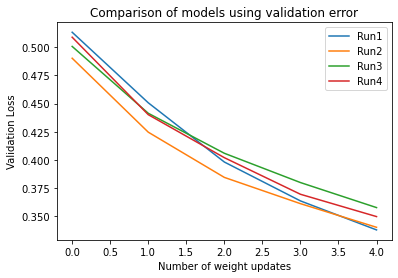

In [143]:
# Plotting validation loss of all the trials vs the Number of weight updates
plt.plot(bp_validation_error1)
plt.plot(bp_validation_error2)
plt.plot(bp_validation_error3)
plt.plot(bp_validation_error4)
plt.title('Comparison of models using validation error')
plt.ylabel('Validation Loss')
plt.xlabel('Number of weight updates')
plt.legend(['Run1', 'Run2', 'Run3', 'Run4'], loc='upper right')
plt.show()

In [144]:
# Storing the final validation for all models in a list
lowest_loss_obtained = [bp_validation_error1[-1],bp_validation_error2[-1],bp_validation_error3[-1],bp_validation_error4[-1]]

# Storing the time complexities for all models in a list
time_complexities = [bp_time_complexity1,bp_time_complexity2,bp_time_complexity3,bp_time_complexity4]

# Creating a list with all the model names
models = ['Run1', 'Run2', 'Run3', 'Run4']

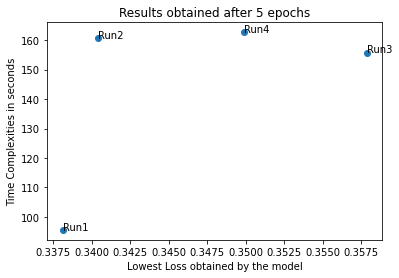

In [145]:
# Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation error
fig,ax = plt.subplots()
ax.scatter(lowest_loss_obtained, time_complexities)

plt.title('Results obtained after 5 epochs')
plt.ylabel('Time Complexities in seconds')
plt.xlabel('Lowest Loss obtained by the model')

for x,y in enumerate(models):
    ax.annotate(y, (lowest_loss_obtained[x], time_complexities[x]))    

In [146]:
architecture3_mean = statistics.mean(lowest_loss_obtained)
print('Architecture3 Validation Loss Mean: ', architecture3_mean)

Architecture3 Validation Loss Mean:  0.3465721681714058


In [147]:
architecture3_stddev = statistics.stdev(lowest_loss_obtained)
print('Architecture3 Validation Loss Std Dev: ', architecture3_stddev)

Architecture3 Validation Loss Std Dev:  0.009107127757627804


In [148]:
architecture3_time_mean = statistics.mean(time_complexities)
print('Architecture3 Time Complexity Mean: ', architecture3_time_mean)

Architecture3 Time Complexity Mean:  143.6970423165476


In [149]:
acc_list = [bp_validation_acc1[-1],bp_validation_acc2[-1],bp_validation_acc3[-1],bp_validation_acc4[-1]]
architecture3_acc_mean = statistics.mean(acc_list)
print('Architecture3 Validation Accuracy Mean: ', architecture3_acc_mean*100)

Architecture3 Validation Accuracy Mean:  83.42401832342148


In [150]:
# Creating a summary table for the model names, lowest MSE and their time complexities
model_summary = pd.DataFrame({"Model":["Plain Backpropagation Architecture1","Plain Backpropagation Architecture2",
                                       "Plain Backpropagation Architecture3"], "Mean Validation loss after 4 trials":[architecture1_mean,architecture2_mean,architecture3_mean],
                              "Mean Standard deviation after 4 trials":[architecture1_stddev,architecture2_stddev,architecture3_stddev],
                            "Mean Time Complexity in seconds after 4 trials":[architecture1_time_mean,architecture2_time_mean,architecture3_time_mean],
                              "Mean Validation Accuracy after 4 trials":[architecture1_acc_mean,architecture2_acc_mean,architecture3_acc_mean]
                                               })

In [151]:
model_summary

,Model,Mean Validation loss after 4 trials,Mean Standard deviation after 4 trials,Mean Time Complexity in seconds after 4 trials,Mean Validation Accuracy after 4 trials
0,Plain Backpropagation Architecture1,0.517974,0.008602,90.550432,0.744462
1,Plain Backpropagation Architecture2,0.419295,0.005150,94.420630,0.797610
2,Plain Backpropagation Architecture3,0.346572,0.009107,143.697042,0.834240


### Using Best Model - Plain Backpropagation Architecture3 - with - epochs=20

In [152]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(20, input_dim=40, activation='relu'))
model_bp.add(Dense(10, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=20, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/20
301/301 [==============================] - 31s 105ms/step - loss: 0.5578 - accuracy: 0.7236 - val_loss: 0.5110 - val_accuracy: 0.7509
Epoch 2/20
301/301 [==============================] - 23s 77ms/step - loss: 0.4728 - accuracy: 0.7718 - val_loss: 0.4311 - val_accuracy: 0.7808
Epoch 3/20
301/301 [==============================] - 15s 51ms/step - loss: 0.4213 - accuracy: 0.7908 - val_loss: 0.3999 - val_accuracy: 0.8099
Epoch 4/20
301/301 [==============================] - 37s 124ms/step - loss: 0.3913 - accuracy: 0.8126 - val_loss: 0.3787 - val_accuracy: 0.8208
Epoch 5/20
301/301 [==============================] - 28s 94ms/step - loss: 0.3719 - accuracy: 0.8244 - val_loss: 0.3598 - val_accuracy: 0.8290
Epoch 6/20
301/301 [==============================] - 32s 107ms/step - loss: 0.3569 - accuracy: 0.8306 - val_loss: 0.3505 - val_accuracy: 0.8340
Epoch 7/20
301/301 [==============================] - 13s 42ms/step - loss: 0.3395 - accuracy: 0.8426 - val_loss: 0.3383 - val_accura

In [153]:
# Calculating the final validation loss
bp_validation_error_best = history_bp.history['val_loss']
print('Final Validation Loss for Best Plain Backpropagation Model:', bp_validation_error_best[-1] )

# Calculating the final validation accracy
bp_validation_acc_best = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Best Plain Backpropagation Model:', bp_validation_acc_best[-1] )


# Calculating the time complexity
bp_time_complexity_best = sum(time_bp)
print('Time complexity for Best Plain Backpropagation Model:', bp_time_complexity_best,'seconds')

Final Validation Loss for Best Plain Backpropagation Model: 0.28222548961639404
Final Validation Accuracy for Best Plain Backpropagation Model: 0.8694131374359131
Time complexity for Best Plain Backpropagation Model: 408.45448852994014 seconds


In [154]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(y_true=y_test,y_pred=(model_bp.predict(X_test)>0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1282
           1       0.90      0.84      0.87      1291

    accuracy                           0.87      2573
   macro avg       0.87      0.87      0.87      2573
weighted avg       0.87      0.87      0.87      2573



#### Reshaping the X_train and X_test arrays from 2-dim to 3-dim as the RNN, LSTM, GRU and CNN models require the input shape for the training data as 3-dim. The dimensions will be: (observations, features, TimeSteps)

In [183]:
# check shape for X_train
X_train.shape

(6003, 20)

In [184]:
# check shape for X_test
X_test.shape

(2573, 20)

In [185]:
# Converting the dataframe to n-dimensional array to feed into the models
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [186]:
# Reshaping X_train
X_train = np.arange(120060).reshape(6003,20,1)

In [187]:
# Reshaping X_test
X_test = np.arange(51460).reshape(2573,20,1)

### Recurrent Neural Network

- Initially we have set the seed so that model performance does not vary with each run
- Here, we have setup a RNN model that uses backpropagation through time
- We have used the activation function as 'relu' for the SimpleRNN layer. We have used a single RNN unit and input shape is [features,TimeSteps] i.e. [20,1]
- We have used the loss function as 'BCE' as this is a binary classification problem and optimizer as 'adam'
- Hyperparameters used for training:
    - epochs = 10
    - batch_size = 10
- RNN model performed with the below performance on the testing dataset:
- Accuracy: 50%

### Architecture1 - 1 RNN layer , optimizer=SGD, activation=tanh, epochs=5, batch_size=20

### Run1

In [44]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(SimpleRNN(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 41s 135ms/step - loss: 0.6935 - accuracy: 0.4949 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 23s 78ms/step - loss: 0.6933 - accuracy: 0.4978 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 3/5
301/301 [==============================] - 52s 174ms/step - loss: 0.6932 - accuracy: 0.4946 - val_loss: 0.6931 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 49s 161ms/step - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 5/5
301/301 [==============================] - 52s 174ms/step - loss: 0.6933 - accuracy: 0.4978 - val_loss: 0.6932 - val_accuracy: 0.4983


In [45]:
# Calculating the final validation mse
bp_validation_error1 = history_bp.history['val_loss']
print('Final Validation Loss for RNN Model for 1st Run:', bp_validation_error1[-1] )

# Calculating the final validation accracy
bp_validation_acc1 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for RNN Model for 1st Run:', bp_validation_acc1[-1] )


# Calculating the time complexity
bp_time_complexity1 = sum(time_bp)
print('Time complexity for RNN Model for 1st Run:', bp_time_complexity1,'seconds')

Final Validation Loss for RNN Model for 1st Run: 0.6931656002998352
Final Validation Accuracy for RNN Model for 1st Run: 0.4982510805130005
Time complexity for RNN Model for 1st Run: 220.41624079388566 seconds


### Run2

In [46]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(SimpleRNN(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 74s 247ms/step - loss: 0.8071 - accuracy: 0.5007 - val_loss: 0.7139 - val_accuracy: 0.4983
Epoch 2/5
301/301 [==============================] - 52s 171ms/step - loss: 0.6998 - accuracy: 0.5007 - val_loss: 0.6947 - val_accuracy: 0.4983
Epoch 3/5
301/301 [==============================] - 63s 211ms/step - loss: 0.6936 - accuracy: 0.5007 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 4/5
301/301 [==============================] - 47s 156ms/step - loss: 0.6932 - accuracy: 0.4954 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 5/5
301/301 [==============================] - 22s 73ms/step - loss: 0.6933 - accuracy: 0.5001 - val_loss: 0.6932 - val_accuracy: 0.4983


In [47]:
# Calculating the final validation mse
bp_validation_error2 = history_bp.history['val_loss']
print('Final Validation Loss for RNN Model for 2nd Run:', bp_validation_error2[-1] )

# Calculating the final validation accracy
bp_validation_acc2 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for RNN Model for 2nd Run:', bp_validation_acc2[-1] )


# Calculating the time complexity
bp_time_complexity2 = sum(time_bp)
print('Time complexity for RNN Model for 2nd Run:', bp_time_complexity2,'seconds')

Final Validation Loss for RNN Model for 2nd Run: 0.6931701898574829
Final Validation Accuracy for RNN Model for 2nd Run: 0.4982510805130005
Time complexity for RNN Model for 2nd Run: 261.1437633810565 seconds


### Run3

In [48]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(SimpleRNN(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 56s 187ms/step - loss: 0.7916 - accuracy: 0.4993 - val_loss: 0.7106 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 49s 163ms/step - loss: 0.6989 - accuracy: 0.4993 - val_loss: 0.6936 - val_accuracy: 0.5017
Epoch 3/5
301/301 [==============================] - 19s 62ms/step - loss: 0.6935 - accuracy: 0.4993 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 32s 105ms/step - loss: 0.6932 - accuracy: 0.5004 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 5/5
301/301 [==============================] - 61s 204ms/step - loss: 0.6933 - accuracy: 0.4928 - val_loss: 0.6932 - val_accuracy: 0.4983


In [49]:
# Calculating the final validation mse
bp_validation_error3 = history_bp.history['val_loss']
print('Final Validation Loss for RNN Model for 3rd Run:', bp_validation_error3[-1] )

# Calculating the final validation accracy
bp_validation_acc3 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for RNN Model for 3rd Run:', bp_validation_acc3[-1] )


# Calculating the time complexity
bp_time_complexity3 = sum(time_bp)
print('Time complexity for RNN Model for 3rd Run:', bp_time_complexity3,'seconds')

Final Validation Loss for RNN Model for 3rd Run: 0.6931630373001099
Final Validation Accuracy for RNN Model for 3rd Run: 0.4982510805130005
Time complexity for RNN Model for 3rd Run: 219.2048435190227 seconds


### Run4

In [50]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(SimpleRNN(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 71s 235ms/step - loss: 0.6940 - accuracy: 0.4993 - val_loss: 0.6933 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 56s 185ms/step - loss: 0.6933 - accuracy: 0.4974 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 3/5
301/301 [==============================] - 35s 117ms/step - loss: 0.6932 - accuracy: 0.4943 - val_loss: 0.6931 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 69s 228ms/step - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 5/5
301/301 [==============================] - 61s 203ms/step - loss: 0.6933 - accuracy: 0.4978 - val_loss: 0.6932 - val_accuracy: 0.4983


In [51]:
# Calculating the final validation mse
bp_validation_error4 = history_bp.history['val_loss']
print('Final Validation Loss for RNN Model for 4th Run:', bp_validation_error4[-1] )

# Calculating the final validation accracy
bp_validation_acc4 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for RNN Model for 4th Run:', bp_validation_acc4[-1] )


# Calculating the time complexity
bp_time_complexity4 = sum(time_bp)
print('Time complexity for RNN Model for 4th Run:', bp_time_complexity4,'seconds')

Final Validation Loss for RNN Model for 4th Run: 0.6931662559509277
Final Validation Accuracy for RNN Model for 4th Run: 0.4982510805130005
Time complexity for RNN Model for 4th Run: 294.19702133385 seconds


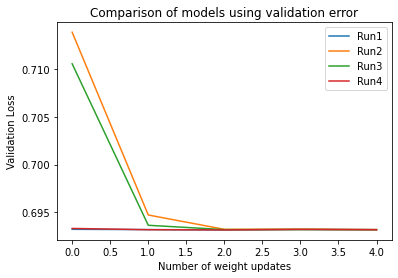

In [52]:
# Plotting validation loss of all the trials vs the Number of weight updates
plt.plot(bp_validation_error1)
plt.plot(bp_validation_error2)
plt.plot(bp_validation_error3)
plt.plot(bp_validation_error4)
plt.title('Comparison of models using validation error')
plt.ylabel('Validation Loss')
plt.xlabel('Number of weight updates')
plt.legend(['Run1', 'Run2', 'Run3', 'Run4'], loc='upper right')
plt.show()

In [53]:
# Storing the final validation for all models in a list
lowest_loss_obtained = [bp_validation_error1[-1],bp_validation_error2[-1],bp_validation_error3[-1],bp_validation_error4[-1]]

# Storing the time complexities for all models in a list
time_complexities = [bp_time_complexity1,bp_time_complexity2,bp_time_complexity3,bp_time_complexity4]

# Creating a list with all the model names
models = ['Run1', 'Run2', 'Run3', 'Run4']

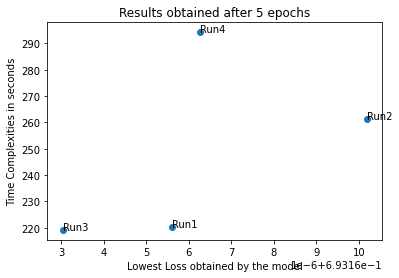

In [54]:
# Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation error
fig,ax = plt.subplots()
ax.scatter(lowest_loss_obtained, time_complexities)

plt.title('Results obtained after 5 epochs')
plt.ylabel('Time Complexities in seconds')
plt.xlabel('Lowest Loss obtained by the model')

for x,y in enumerate(models):
    ax.annotate(y, (lowest_loss_obtained[x], time_complexities[x]))    

In [55]:
architecture1_mean = statistics.mean(lowest_loss_obtained)
print('Architecture1 Validation Loss Mean: ', architecture1_mean)

Architecture1 Validation Loss Mean:  0.6931662708520889


In [56]:
architecture1_stddev = statistics.stdev(lowest_loss_obtained)
print('Architecture1 Validation Loss Std Dev: ', architecture1_stddev)

Architecture1 Validation Loss Std Dev:  2.958846850207718e-06


In [57]:
architecture1_time_mean = statistics.mean(time_complexities)
print('Architecture1 Time Complexity Mean: ', architecture1_time_mean)

Architecture1 Time Complexity Mean:  248.7404672569537


In [58]:
acc_list = [bp_validation_acc1[-1],bp_validation_acc2[-1],bp_validation_acc3[-1],bp_validation_acc4[-1]]
architecture1_acc_mean = statistics.mean(acc_list)
print('Architecture1 Validation Accuracy Mean: ', architecture1_acc_mean*100)

Architecture1 Validation Accuracy Mean:  49.82510805130005


### Architecture2 - 1 RNN layer, 1 hidden layer=40 nodes, epochs=5, batch_size=20, optimizer=adam, activation=relu

### Run1

In [59]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(SimpleRNN(units=1, input_shape=[20,1], activation='relu'))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 57s 189ms/step - loss: 0.6931 - accuracy: 0.5049 - val_loss: 0.6933 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 66s 220ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6933 - val_accuracy: 0.4975
Epoch 3/5
301/301 [==============================] - 51s 169ms/step - loss: 0.6931 - accuracy: 0.4979 - val_loss: 0.6934 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 73s 243ms/step - loss: 0.6931 - accuracy: 0.5001 - val_loss: 0.6936 - val_accuracy: 0.4979
Epoch 5/5
301/301 [==============================] - 52s 172ms/step - loss: 0.6931 - accuracy: 0.4989 - val_loss: 0.6937 - val_accuracy: 0.4979


In [60]:
# Calculating the final validation mse
bp_validation_error1 = history_bp.history['val_loss']
print('Final Validation loss for RNN Model for 1st Run:', bp_validation_error1[-1] )

# Calculating the final validation accracy
bp_validation_acc1 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for RNN Model for 1st Run:', bp_validation_acc1[-1] )


# Calculating the time complexity
bp_time_complexity1 = sum(time_bp)
print('Time complexity for RNN Model for 1st Run:', bp_time_complexity1,'seconds')

Final Validation loss for RNN Model for 1st Run: 0.6936673521995544
Final Validation Accuracy for RNN Model for 1st Run: 0.49786242842674255
Time complexity for RNN Model for 1st Run: 302.3616301099537 seconds


### Run2

In [61]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(SimpleRNN(units=1, input_shape=[20,1], activation='relu'))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 94s 314ms/step - loss: 309.6922 - accuracy: 0.5039 - val_loss: 15.2282 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 116s 385ms/step - loss: 80.0827 - accuracy: 0.4983 - val_loss: 88.0211 - val_accuracy: 0.4983
Epoch 3/5
301/301 [==============================] - 84s 279ms/step - loss: 53.8213 - accuracy: 0.5022 - val_loss: 11.4883 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 72s 240ms/step - loss: 39.0172 - accuracy: 0.4924 - val_loss: 14.9159 - val_accuracy: 0.4983
Epoch 5/5
301/301 [==============================] - 73s 243ms/step - loss: 20.5173 - accuracy: 0.5062 - val_loss: 2.9502 - val_accuracy: 0.4983


In [62]:
# Calculating the final validation mse
bp_validation_error2 = history_bp.history['val_loss']
print('Final Validation Loss for RNN Model for 2nd Run:', bp_validation_error2[-1] )

# Calculating the final validation accracy
bp_validation_acc2 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for RNN Model for 2nd Run:', bp_validation_acc2[-1] )


# Calculating the time complexity
bp_time_complexity2 = sum(time_bp)
print('Time complexity for RNN Model for 2nd Run:', bp_time_complexity2,'seconds')

Final Validation Loss for RNN Model for 2nd Run: 2.950223445892334
Final Validation Accuracy for RNN Model for 2nd Run: 0.4982510805130005
Time complexity for RNN Model for 2nd Run: 443.9145553630078 seconds


### Run3

In [63]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(SimpleRNN(units=1, input_shape=[20,1], activation='relu'))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 104s 347ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6931 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 98s 327ms/step - loss: 0.6932 - accuracy: 0.4941 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 3/5
301/301 [==============================] - 67s 223ms/step - loss: 0.6932 - accuracy: 0.4978 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 4/5
301/301 [==============================] - 103s 342ms/step - loss: 0.6932 - accuracy: 0.4968 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 5/5
301/301 [==============================] - 73s 241ms/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6932 - val_accuracy: 0.4983


In [64]:
# Calculating the final validation mse
bp_validation_error3 = history_bp.history['val_loss']
print('Final Validation Loss for RNN Model for 3rd Run:', bp_validation_error3[-1] )

# Calculating the final validation accracy
bp_validation_acc3 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for RNN Model for 3rd Run:', bp_validation_acc3[-1] )

# Calculating the time complexity
bp_time_complexity3 = sum(time_bp)
print('Time complexity for RNN Model for 3rd Run:', bp_time_complexity3,'seconds')

Final Validation Loss for RNN Model for 3rd Run: 0.693160891532898
Final Validation Accuracy for RNN Model for 3rd Run: 0.4982510805130005
Time complexity for RNN Model for 3rd Run: 448.98006818187423 seconds


### Run4

In [65]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(SimpleRNN(units=1, input_shape=[20,1], activation='relu'))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 58s 193ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6931 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 71s 236ms/step - loss: 0.6932 - accuracy: 0.4941 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 3/5
301/301 [==============================] - 99s 329ms/step - loss: 0.6932 - accuracy: 0.4978 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 4/5
301/301 [==============================] - 77s 255ms/step - loss: 0.6932 - accuracy: 0.4968 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 5/5
301/301 [==============================] - 98s 324ms/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6932 - val_accuracy: 0.4983


In [66]:
# Calculating the final validation mse
bp_validation_error4 = history_bp.history['val_loss']
print('Final Validation Loss for RNN Model for 4th Run:', bp_validation_error4[-1] )

# Calculating the final validation accracy
bp_validation_acc4 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for RNN Model for 4th Run:', bp_validation_acc4[-1] )

# Calculating the time complexity
bp_time_complexity4 = sum(time_bp)
print('Time complexity for RNN Model for 4th Run:', bp_time_complexity4,'seconds')

Final Validation Loss for RNN Model for 4th Run: 0.693160891532898
Final Validation Accuracy for RNN Model for 4th Run: 0.4982510805130005
Time complexity for RNN Model for 4th Run: 405.7492425489472 seconds


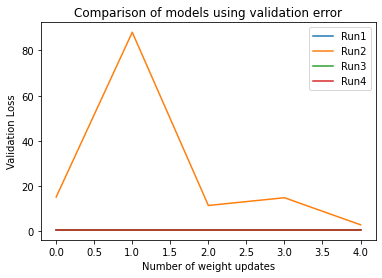

In [67]:
# Plotting validation loss of all the trials vs the Number of weight updates
plt.plot(bp_validation_error1)
plt.plot(bp_validation_error2)
plt.plot(bp_validation_error3)
plt.plot(bp_validation_error4)
plt.title('Comparison of models using validation error')
plt.ylabel('Validation Loss')
plt.xlabel('Number of weight updates')
plt.legend(['Run1', 'Run2', 'Run3', 'Run4'], loc='upper right')
plt.show()

In [68]:
# Storing the final validation for all models in a list
lowest_loss_obtained = [bp_validation_error1[-1],bp_validation_error2[-1],bp_validation_error3[-1],bp_validation_error4[-1]]

# Storing the time complexities for all models in a list
time_complexities = [bp_time_complexity1,bp_time_complexity2,bp_time_complexity3,bp_time_complexity4]

# Creating a list with all the model names
models = ['Run1', 'Run2', 'Run3', 'Run4']

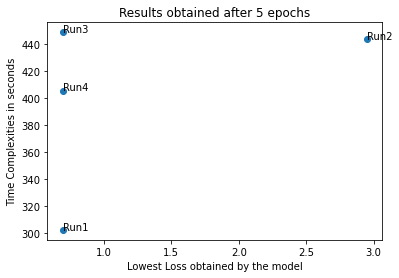

In [69]:
# Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation error
fig,ax = plt.subplots()
ax.scatter(lowest_loss_obtained, time_complexities)

plt.title('Results obtained after 5 epochs')
plt.ylabel('Time Complexities in seconds')
plt.xlabel('Lowest Loss obtained by the model')

for x,y in enumerate(models):
    ax.annotate(y, (lowest_loss_obtained[x], time_complexities[x]))    

In [70]:
architecture2_mean = statistics.mean(lowest_loss_obtained)
print('Architecture2 Validation Loss Mean: ', architecture2_mean)

Architecture2 Validation Loss Mean:  1.257553145289421


In [71]:
architecture2_stddev = statistics.stdev(lowest_loss_obtained)
print('Architecture2 Validation Loss Std Dev: ', architecture2_stddev)

Architecture2 Validation Loss Std Dev:  1.1284468923247972


In [72]:
architecture2_time_mean = statistics.mean(time_complexities)
print('Architecture2 Time Complexity Mean: ', architecture2_time_mean)

Architecture2 Time Complexity Mean:  400.25137405094574


In [73]:
acc_list = [bp_validation_acc1[-1],bp_validation_acc2[-1],bp_validation_acc3[-1],bp_validation_acc4[-1]]
architecture2_acc_mean = statistics.mean(acc_list)
print('Architecture2 Validation Accuracy Mean: ', architecture2_acc_mean*100)

Architecture2 Validation Accuracy Mean:  49.8153917491436


### Architecture3 - 1st RNN layer,  2nd hidden layer=40 nodes, 3rd hidden layer=20 nodes, epochs=5, batch_size=20, optimizer=adam, activation=relu

### Run1

In [74]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(SimpleRNN(units=1, input_shape=[20,1], activation='relu'))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(20, input_dim=40, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 70s 233ms/step - loss: 0.6938 - accuracy: 0.4994 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 2/5
301/301 [==============================] - 129s 429ms/step - loss: 0.6933 - accuracy: 0.5029 - val_loss: 0.6932 - val_accuracy: 0.4979
Epoch 3/5
301/301 [==============================] - 128s 425ms/step - loss: 0.6932 - accuracy: 0.5012 - val_loss: 0.6933 - val_accuracy: 0.4975
Epoch 4/5
301/301 [==============================] - 105s 348ms/step - loss: 0.6931 - accuracy: 0.4984 - val_loss: 0.6935 - val_accuracy: 0.4975
Epoch 5/5
301/301 [==============================] - 86s 287ms/step - loss: 0.6931 - accuracy: 0.4976 - val_loss: 0.6936 - val_accuracy: 0.4975


In [75]:
# Calculating the final validation mse
bp_validation_error1 = history_bp.history['val_loss']
print('Final Validation Loss for RNN Model for 1st Run:', bp_validation_error1[-1] )

# Calculating the final validation accracy
bp_validation_acc1 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for RNN Model for 1st Run:', bp_validation_acc1[-1] )


# Calculating the time complexity
bp_time_complexity1 = sum(time_bp)
print('Time complexity for RNN Model for 1st Run:', bp_time_complexity1,'seconds')

Final Validation Loss for RNN Model for 1st Run: 0.6936237215995789
Final Validation Accuracy for RNN Model for 1st Run: 0.4974737763404846
Time complexity for RNN Model for 1st Run: 521.9111788368318 seconds


### Run2

In [76]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(SimpleRNN(units=1, input_shape=[20,1], activation='relu'))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(20, input_dim=40, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 57s 190ms/step - loss: 0.6976 - accuracy: 0.5054 - val_loss: 0.6949 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 70s 232ms/step - loss: 0.6930 - accuracy: 0.4986 - val_loss: 0.6948 - val_accuracy: 0.4975
Epoch 3/5
301/301 [==============================] - 96s 318ms/step - loss: 0.6930 - accuracy: 0.4979 - val_loss: 0.6947 - val_accuracy: 0.4975
Epoch 4/5
301/301 [==============================] - 91s 304ms/step - loss: 0.6930 - accuracy: 0.4944 - val_loss: 0.6945 - val_accuracy: 0.4975
Epoch 5/5
301/301 [==============================] - 56s 188ms/step - loss: 0.6930 - accuracy: 0.5014 - val_loss: 0.6944 - val_accuracy: 0.4975


In [77]:
# Calculating the final validation mse
bp_validation_error2 = history_bp.history['val_loss']
print('Final Validation Loss for RNN Model for 2nd Run:', bp_validation_error2[-1] )

# Calculating the final validation accracy
bp_validation_acc2 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for RNN Model for 2nd Run:', bp_validation_acc2[-1] )


# Calculating the time complexity
bp_time_complexity2 = sum(time_bp)
print('Time complexity for RNN Model for 2nd Run:', bp_time_complexity2,'seconds')

Final Validation Loss for RNN Model for 2nd Run: 0.6943898797035217
Final Validation Accuracy for RNN Model for 2nd Run: 0.4974737763404846
Time complexity for RNN Model for 2nd Run: 374.35137372184545 seconds


### Run3

In [78]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(SimpleRNN(units=1, input_shape=[20,1], activation='relu'))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(20, input_dim=40, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 76s 254ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6931 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 50s 166ms/step - loss: 0.6932 - accuracy: 0.4941 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 3/5
301/301 [==============================] - 44s 147ms/step - loss: 0.6932 - accuracy: 0.4978 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 4/5
301/301 [==============================] - 31s 104ms/step - loss: 0.6932 - accuracy: 0.4968 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 5/5
301/301 [==============================] - 58s 194ms/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6932 - val_accuracy: 0.4983


In [79]:
# Calculating the final validation mse
bp_validation_error3 = history_bp.history['val_loss']
print('Final Validation Loss for RNN Model for 3rd Run:', bp_validation_error3[-1] )

# Calculating the final validation accracy
bp_validation_acc3 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for RNN Model for 3rd Run:', bp_validation_acc3[-1] )

# Calculating the time complexity
bp_time_complexity3 = sum(time_bp)
print('Time complexity for RNN Model for 3rd Run:', bp_time_complexity3,'seconds')

Final Validation Loss for RNN Model for 3rd Run: 0.693160891532898
Final Validation Accuracy for RNN Model for 3rd Run: 0.4982510805130005
Time complexity for RNN Model for 3rd Run: 263.4217010419816 seconds


### Run4

In [80]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(SimpleRNN(units=1, input_shape=[20,1], activation='relu'))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(20, input_dim=40, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 73s 243ms/step - loss: 0.6946 - accuracy: 0.5064 - val_loss: 0.6939 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 68s 227ms/step - loss: 0.6930 - accuracy: 0.4969 - val_loss: 0.6939 - val_accuracy: 0.4975
Epoch 3/5
301/301 [==============================] - 79s 262ms/step - loss: 0.6930 - accuracy: 0.4983 - val_loss: 0.6940 - val_accuracy: 0.4975
Epoch 4/5
301/301 [==============================] - 79s 264ms/step - loss: 0.6930 - accuracy: 0.4961 - val_loss: 0.6942 - val_accuracy: 0.4975
Epoch 5/5
301/301 [==============================] - 74s 245ms/step - loss: 0.6930 - accuracy: 0.5014 - val_loss: 0.6941 - val_accuracy: 0.4975


In [81]:
# Calculating the final validation mse
bp_validation_error4 = history_bp.history['val_loss']
print('Final Validation Loss for RNN Model for 4th Run:', bp_validation_error4[-1] )

# Calculating the final validation accracy
bp_validation_acc4 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for RNN Model for 4th Run:', bp_validation_acc4[-1] )

# Calculating the time complexity
bp_time_complexity4 = sum(time_bp)
print('Time complexity for RNN Model for 4th Run:', bp_time_complexity4,'seconds')

Final Validation Loss for RNN Model for 4th Run: 0.6941468119621277
Final Validation Accuracy for RNN Model for 4th Run: 0.4974737763404846
Time complexity for RNN Model for 4th Run: 377.51334598998073 seconds


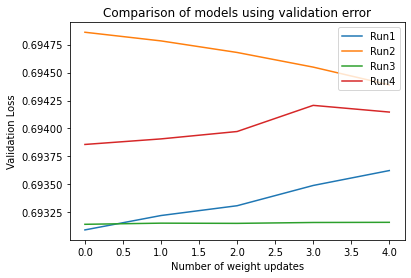

In [82]:
# Plotting validation loss of all the trials vs the Number of weight updates
plt.plot(bp_validation_error1)
plt.plot(bp_validation_error2)
plt.plot(bp_validation_error3)
plt.plot(bp_validation_error4)
plt.title('Comparison of models using validation error')
plt.ylabel('Validation Loss')
plt.xlabel('Number of weight updates')
plt.legend(['Run1', 'Run2', 'Run3', 'Run4'], loc='upper right')
plt.show()

In [83]:
# Storing the final validation for all models in a list
lowest_loss_obtained = [bp_validation_error1[-1],bp_validation_error2[-1],bp_validation_error3[-1],bp_validation_error4[-1]]

# Storing the time complexities for all models in a list
time_complexities = [bp_time_complexity1,bp_time_complexity2,bp_time_complexity3,bp_time_complexity4]

# Creating a list with all the model names
models = ['Run1', 'Run2', 'Run3', 'Run4']

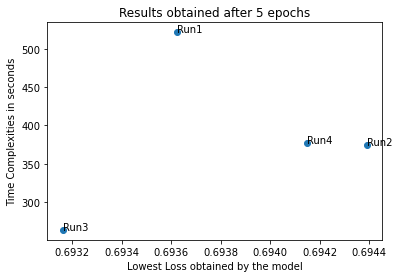

In [84]:
# Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation error
fig,ax = plt.subplots()
ax.scatter(lowest_loss_obtained, time_complexities)

plt.title('Results obtained after 5 epochs')
plt.ylabel('Time Complexities in seconds')
plt.xlabel('Lowest Loss obtained by the model')

for x,y in enumerate(models):
    ax.annotate(y, (lowest_loss_obtained[x], time_complexities[x]))    

In [85]:
architecture3_mean = statistics.mean(lowest_loss_obtained)
print('Architecture3 Validation Loss Mean: ', architecture3_mean)

Architecture3 Validation Loss Mean:  0.6938303261995316


In [86]:
architecture3_stddev = statistics.stdev(lowest_loss_obtained)
print('Architecture3 Validation Loss Std Dev: ', architecture3_stddev)

Architecture3 Validation Loss Std Dev:  0.0005489661784864943


In [87]:
architecture3_time_mean = statistics.mean(time_complexities)
print('Architecture3 Time Complexity Mean: ', architecture3_time_mean)

Architecture3 Time Complexity Mean:  384.2993998976599


In [88]:
acc_list = [bp_validation_acc1[-1],bp_validation_acc2[-1],bp_validation_acc3[-1],bp_validation_acc4[-1]]
architecture3_acc_mean = statistics.mean(acc_list)
print('Architecture3 Validation Accuracy Mean: ', architecture3_acc_mean*100)

Architecture3 Validation Accuracy Mean:  49.76681023836136


In [89]:
# Creating a summary table for the model names, lowest MSE and their time complexities
model_summary = pd.DataFrame({"Model":["RNN Architecture1","RNN Architecture2",
                                       "RNN Architecture3"], "Mean Validation loss after 4 trials":[architecture1_mean,architecture2_mean,architecture3_mean],
                              "Mean Standard deviation after 4 trials":[architecture1_stddev,architecture2_stddev,architecture3_stddev],
                            "Mean Time Complexity in seconds after 4 trials":[architecture1_time_mean,architecture2_time_mean,architecture3_time_mean],
                              "Mean Validation Accuracy after 4 trials":[architecture1_acc_mean,architecture2_acc_mean,architecture3_acc_mean]
                                               })

In [90]:
model_summary

,Model,Mean Validation loss after 4 trials,Mean Standard deviation after 4 trials,Mean Time Complexity in seconds after 4 trials,Mean Validation Accuracy after 4 trials
0,RNN Architecture1,0.693166,0.000003,248.740467,0.498251
1,RNN Architecture2,1.257553,1.128447,400.251374,0.498154
2,RNN Architecture3,0.693830,0.000549,384.299400,0.497668


Instructions for updating:
Please use `model.predict()` instead.
No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.499


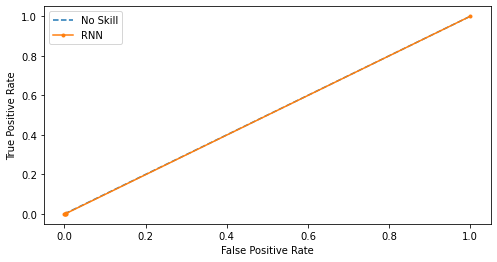

In [93]:
ROC_AUC_curve_upgraded(model=model_bp,model_name="RNN")

### Using Best Model - RNN Architecture1 - with - epochs=20

In [94]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(SimpleRNN(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=20, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/20
301/301 [==============================] - 60s 199ms/step - loss: 0.7157 - accuracy: 0.4993 - val_loss: 0.6968 - val_accuracy: 0.5017
Epoch 2/20
301/301 [==============================] - 49s 162ms/step - loss: 0.6944 - accuracy: 0.4993 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 3/20
301/301 [==============================] - 52s 172ms/step - loss: 0.6933 - accuracy: 0.4919 - val_loss: 0.6931 - val_accuracy: 0.5017
Epoch 4/20
301/301 [==============================] - 51s 170ms/step - loss: 0.6932 - accuracy: 0.4991 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 5/20
301/301 [==============================] - 49s 164ms/step - loss: 0.6933 - accuracy: 0.4954 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 6/20
301/301 [==============================] - 53s 176ms/step - loss: 0.6932 - accuracy: 0.5039 - val_loss: 0.6931 - val_accuracy: 0.5017
Epoch 7/20
301/301 [==============================] - 50s 166ms/step - loss: 0.6932 - accuracy: 0.4969 - val_loss: 0.6932 - val_ac

In [95]:
# Calculating the final validation loss
bp_validation_error_best = history_bp.history['val_loss']
print('Final Validation Loss for RNN Model:', bp_validation_error_best[-1] )

# Calculating the final validation accracy
bp_validation_acc_best = history_bp.history['val_accuracy']
print('Final Validation Accuracy for RNN Model:', bp_validation_acc_best[-1] )


# Calculating the time complexity
bp_time_complexity_best = sum(time_bp)
print('Time complexity for RNN Model:', bp_time_complexity_best,'seconds')

Final Validation Loss for RNN Model: 0.6931449174880981
Final Validation Accuracy for RNN Model: 0.5017489194869995
Time complexity for RNN Model: 1047.949325280264 seconds


In [96]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(y_true=y_test,y_pred=(model_bp.predict(X_test)>0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1282
           1       0.50      1.00      0.67      1291

    accuracy                           0.50      2573
   macro avg       0.25      0.50      0.33      2573
weighted avg       0.25      0.50      0.34      2573



/home/ssingh56/anaconda3/envs/production/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.500


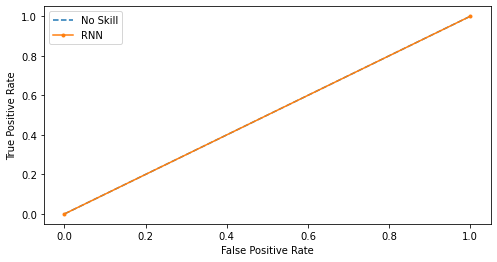

In [97]:
ROC_AUC_curve_upgraded(model=model_bp,model_name="RNN")

### LSTM

### Architecture1 - 1 LSTM layer, epochs=5, batch_size=20, optimizer=SGD, activation=tanh

### Run1

In [98]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(LSTM(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 58s 194ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6931 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 68s 225ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 3/5
301/301 [==============================] - 67s 222ms/step - loss: 0.6932 - accuracy: 0.4988 - val_loss: 0.6931 - val_accuracy: 0.4983
Epoch 4/5
301/301 [==============================] - 57s 191ms/step - loss: 0.6932 - accuracy: 0.4948 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 5/5
301/301 [==============================] - 54s 181ms/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6932 - val_accuracy: 0.4983


In [99]:
# Calculating the final validation mse
bp_validation_error1 = history_bp.history['val_loss']
print('Final Validation Loss for LSTM Model for 1st Run:', bp_validation_error1[-1] )

# Calculating the final validation accracy
bp_validation_acc1 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for LSTM Model for 1st Run:', bp_validation_acc1[-1] )


# Calculating the time complexity
bp_time_complexity1 = sum(time_bp)
print('Time complexity for LSTM Model for 1st Run:', bp_time_complexity1,'seconds')

Final Validation Loss for LSTM Model for 1st Run: 0.6931622624397278
Final Validation Accuracy for LSTM Model for 1st Run: 0.4982510805130005
Time complexity for LSTM Model for 1st Run: 309.27989893301856 seconds


### Run2

In [100]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(LSTM(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 73s 244ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6931 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 69s 230ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 3/5
301/301 [==============================] - 84s 278ms/step - loss: 0.6932 - accuracy: 0.4988 - val_loss: 0.6931 - val_accuracy: 0.4983
Epoch 4/5
301/301 [==============================] - 100s 332ms/step - loss: 0.6932 - accuracy: 0.4948 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 5/5
301/301 [==============================] - 110s 365ms/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6932 - val_accuracy: 0.4983


In [101]:
# Calculating the final validation mse
bp_validation_error2 = history_bp.history['val_loss']
print('Final Validation Loss for LSTM Model for 2nd Run:', bp_validation_error2[-1] )

# Calculating the final validation accracy
bp_validation_acc2 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for LSTM Model for 2nd Run:', bp_validation_acc2[-1] )


# Calculating the time complexity
bp_time_complexity2 = sum(time_bp)
print('Time complexity for LSTM Model for 2nd Run:', bp_time_complexity2,'seconds')

Final Validation Loss for LSTM Model for 2nd Run: 0.6931622624397278
Final Validation Accuracy for LSTM Model for 2nd Run: 0.4982510805130005
Time complexity for LSTM Model for 2nd Run: 441.3629750000546 seconds


### Run3

In [102]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(LSTM(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 105s 348ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6931 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 78s 259ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 3/5
301/301 [==============================] - 69s 229ms/step - loss: 0.6932 - accuracy: 0.4988 - val_loss: 0.6931 - val_accuracy: 0.4983
Epoch 4/5
301/301 [==============================] - 101s 334ms/step - loss: 0.6932 - accuracy: 0.4948 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 5/5
301/301 [==============================] - 54s 178ms/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6932 - val_accuracy: 0.4983


In [103]:
# Calculating the final validation mse
bp_validation_error3 = history_bp.history['val_loss']
print('Final Validation Loss for LSTM Model for 3rd Run:', bp_validation_error3[-1] )

# Calculating the final validation accracy
bp_validation_acc3 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for LSTM Model for 3rd Run:', bp_validation_acc3[-1] )


# Calculating the time complexity
bp_time_complexity3 = sum(time_bp)
print('Time complexity for LSTM Model for 3rd Run:', bp_time_complexity3,'seconds')

Final Validation Loss for LSTM Model for 3rd Run: 0.6931622624397278
Final Validation Accuracy for LSTM Model for 3rd Run: 0.4982510805130005
Time complexity for LSTM Model for 3rd Run: 413.61287379811984 seconds


### Run4

In [104]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(LSTM(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 81s 268ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6931 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 96s 318ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 3/5
301/301 [==============================] - 103s 342ms/step - loss: 0.6932 - accuracy: 0.4988 - val_loss: 0.6931 - val_accuracy: 0.4983
Epoch 4/5
301/301 [==============================] - 102s 337ms/step - loss: 0.6932 - accuracy: 0.4948 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 5/5
301/301 [==============================] - 63s 210ms/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6932 - val_accuracy: 0.4983


In [105]:
# Calculating the final validation mse
bp_validation_error4 = history_bp.history['val_loss']
print('Final Validation Loss for LSTM Model for 4th Run:', bp_validation_error4[-1] )

# Calculating the final validation accracy
bp_validation_acc4 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for LSTM Model for 4th Run:', bp_validation_acc4[-1] )


# Calculating the time complexity
bp_time_complexity4 = sum(time_bp)
print('Time complexity for LSTM Model for 4th Run:', bp_time_complexity4,'seconds')

Final Validation Loss for LSTM Model for 4th Run: 0.6931622624397278
Final Validation Accuracy for LSTM Model for 4th Run: 0.4982510805130005
Time complexity for LSTM Model for 4th Run: 452.0281150881201 seconds


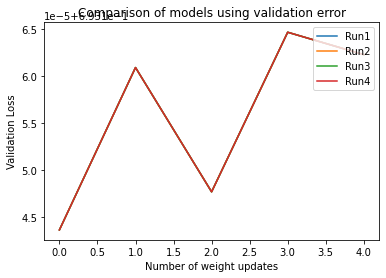

In [106]:
# Plotting validation loss of all the trials vs the Number of weight updates
plt.plot(bp_validation_error1)
plt.plot(bp_validation_error2)
plt.plot(bp_validation_error3)
plt.plot(bp_validation_error4)
plt.title('Comparison of models using validation error')
plt.ylabel('Validation Loss')
plt.xlabel('Number of weight updates')
plt.legend(['Run1', 'Run2', 'Run3', 'Run4'], loc='upper right')
plt.show()

In [107]:
# Storing the final validation for all models in a list
lowest_loss_obtained = [bp_validation_error1[-1],bp_validation_error2[-1],bp_validation_error3[-1],bp_validation_error4[-1]]

# Storing the time complexities for all models in a list
time_complexities = [bp_time_complexity1,bp_time_complexity2,bp_time_complexity3,bp_time_complexity4]

# Creating a list with all the model names
models = ['Run1', 'Run2', 'Run3', 'Run4']

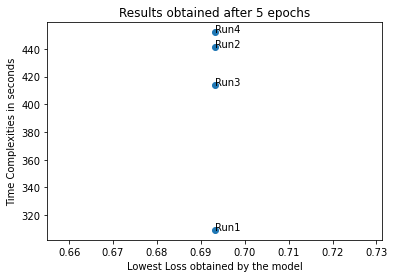

In [108]:
# Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation error
fig,ax = plt.subplots()
ax.scatter(lowest_loss_obtained, time_complexities)

plt.title('Results obtained after 5 epochs')
plt.ylabel('Time Complexities in seconds')
plt.xlabel('Lowest Loss obtained by the model')

for x,y in enumerate(models):
    ax.annotate(y, (lowest_loss_obtained[x], time_complexities[x]))    

In [109]:
architecture1_mean = statistics.mean(lowest_loss_obtained)
print('Architecture1 Validation Loss Mean: ', architecture1_mean)

Architecture1 Validation Loss Mean:  0.6931622624397278


In [110]:
architecture1_stddev = statistics.stdev(lowest_loss_obtained)
print('Architecture1 Validation Loss Std Dev: ', architecture1_stddev)

Architecture1 Validation Loss Std Dev:  0.0


In [111]:
architecture1_time_mean = statistics.mean(time_complexities)
print('Architecture1 Time Complexity Mean: ', architecture1_time_mean)

Architecture1 Time Complexity Mean:  404.07096570482827


In [112]:
acc_list = [bp_validation_acc1[-1],bp_validation_acc2[-1],bp_validation_acc3[-1],bp_validation_acc4[-1]]
architecture1_acc_mean = statistics.mean(acc_list)
print('Architecture1 Validation Accuracy Mean: ', architecture1_acc_mean*100)

Architecture1 Validation Accuracy Mean:  49.82510805130005


### Architecture2 - 1 LSTM layer, 1 hidden layer=40 nodes, epochs=5, batch_size=20, optimizer=adam, activation=tanh

### Run1

In [113]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(LSTM(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 102s 340ms/step - loss: 0.6931 - accuracy: 0.5072 - val_loss: 0.6940 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 82s 271ms/step - loss: 0.6934 - accuracy: 0.5051 - val_loss: 0.6933 - val_accuracy: 0.4983
Epoch 3/5
301/301 [==============================] - 53s 175ms/step - loss: 0.6933 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 47s 156ms/step - loss: 0.6933 - accuracy: 0.5007 - val_loss: 0.6933 - val_accuracy: 0.4983
Epoch 5/5
301/301 [==============================] - 45s 151ms/step - loss: 0.6933 - accuracy: 0.4918 - val_loss: 0.6932 - val_accuracy: 0.4983


In [114]:
# Calculating the final validation mse
bp_validation_error1 = history_bp.history['val_loss']
print('Final Validation loss for LSTM Model for 1st Run:', bp_validation_error1[-1] )

# Calculating the final validation accracy
bp_validation_acc1 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for LSTM Model for 1st Run:', bp_validation_acc1[-1] )


# Calculating the time complexity
bp_time_complexity1 = sum(time_bp)
print('Time complexity for LSTM Model for 1st Run:', bp_time_complexity1,'seconds')

Final Validation loss for LSTM Model for 1st Run: 0.6931567788124084
Final Validation Accuracy for LSTM Model for 1st Run: 0.4982510805130005
Time complexity for LSTM Model for 1st Run: 337.8804932750063 seconds


### Run2

In [115]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(LSTM(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 65s 217ms/step - loss: 0.6931 - accuracy: 0.5112 - val_loss: 0.6959 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 62s 205ms/step - loss: 0.6938 - accuracy: 0.4981 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 3/5
301/301 [==============================] - 54s 179ms/step - loss: 0.6936 - accuracy: 0.4923 - val_loss: 0.6936 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 55s 183ms/step - loss: 0.6937 - accuracy: 0.5047 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 5/5
301/301 [==============================] - 58s 193ms/step - loss: 0.6938 - accuracy: 0.4859 - val_loss: 0.6931 - val_accuracy: 0.5017


In [116]:
# Calculating the final validation mse
bp_validation_error2 = history_bp.history['val_loss']
print('Final Validation Loss for LSTM Model for 2nd Run:', bp_validation_error2[-1] )

# Calculating the final validation accracy
bp_validation_acc2 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for LSTM Model for 2nd Run:', bp_validation_acc2[-1] )


# Calculating the time complexity
bp_time_complexity2 = sum(time_bp)
print('Time complexity for LSTM Model for 2nd Run:', bp_time_complexity2,'seconds')

Final Validation Loss for LSTM Model for 2nd Run: 0.6931455731391907
Final Validation Accuracy for LSTM Model for 2nd Run: 0.5017489194869995
Time complexity for LSTM Model for 2nd Run: 299.29214882617816 seconds


### Run3

In [117]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(LSTM(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 61s 203ms/step - loss: 0.6931 - accuracy: 0.5076 - val_loss: 0.6941 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 54s 179ms/step - loss: 0.6934 - accuracy: 0.5037 - val_loss: 0.6934 - val_accuracy: 0.4983
Epoch 3/5
301/301 [==============================] - 60s 201ms/step - loss: 0.6934 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 55s 183ms/step - loss: 0.6933 - accuracy: 0.5004 - val_loss: 0.6933 - val_accuracy: 0.4983
Epoch 5/5
301/301 [==============================] - 65s 214ms/step - loss: 0.6934 - accuracy: 0.4904 - val_loss: 0.6932 - val_accuracy: 0.4983


In [118]:
# Calculating the final validation mse
bp_validation_error3 = history_bp.history['val_loss']
print('Final Validation Loss for LSTM Model for 3rd Run:', bp_validation_error3[-1] )

# Calculating the final validation accracy
bp_validation_acc3 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for LSTM Model for 3rd Run:', bp_validation_acc3[-1] )

# Calculating the time complexity
bp_time_complexity3 = sum(time_bp)
print('Time complexity for LSTM Model for 3rd Run:', bp_time_complexity3,'seconds')

Final Validation Loss for LSTM Model for 3rd Run: 0.6931553483009338
Final Validation Accuracy for LSTM Model for 3rd Run: 0.4982510805130005
Time complexity for LSTM Model for 3rd Run: 300.32327344606165 seconds


### Run4

In [119]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(LSTM(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 65s 215ms/step - loss: 0.6931 - accuracy: 0.5067 - val_loss: 0.6942 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 51s 170ms/step - loss: 0.6938 - accuracy: 0.5019 - val_loss: 0.6931 - val_accuracy: 0.5014
Epoch 3/5
301/301 [==============================] - 62s 205ms/step - loss: 0.6937 - accuracy: 0.4916 - val_loss: 0.6937 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 68s 227ms/step - loss: 0.6937 - accuracy: 0.5057 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 5/5
301/301 [==============================] - 47s 156ms/step - loss: 0.6938 - accuracy: 0.4856 - val_loss: 0.6931 - val_accuracy: 0.5017


In [120]:
# Calculating the final validation mse
bp_validation_error4 = history_bp.history['val_loss']
print('Final Validation Loss for LSTM Model for 4th Run:', bp_validation_error4[-1] )

# Calculating the final validation accracy
bp_validation_acc4 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for LSTM Model for 4th Run:', bp_validation_acc4[-1] )

# Calculating the time complexity
bp_time_complexity4 = sum(time_bp)
print('Time complexity for LSTM Model for 4th Run:', bp_time_complexity4,'seconds')

Final Validation Loss for LSTM Model for 4th Run: 0.6931432485580444
Final Validation Accuracy for LSTM Model for 4th Run: 0.5017489194869995
Time complexity for LSTM Model for 4th Run: 297.63014356116764 seconds


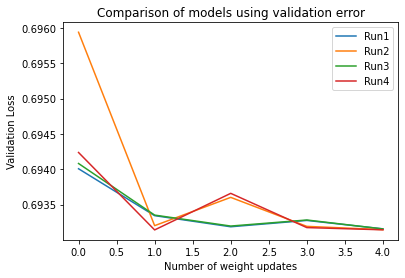

In [121]:
# Plotting validation loss of all the trials vs the Number of weight updates
plt.plot(bp_validation_error1)
plt.plot(bp_validation_error2)
plt.plot(bp_validation_error3)
plt.plot(bp_validation_error4)
plt.title('Comparison of models using validation error')
plt.ylabel('Validation Loss')
plt.xlabel('Number of weight updates')
plt.legend(['Run1', 'Run2', 'Run3', 'Run4'], loc='upper right')
plt.show()

In [122]:
# Storing the final validation for all models in a list
lowest_loss_obtained = [bp_validation_error1[-1],bp_validation_error2[-1],bp_validation_error3[-1],bp_validation_error4[-1]]

# Storing the time complexities for all models in a list
time_complexities = [bp_time_complexity1,bp_time_complexity2,bp_time_complexity3,bp_time_complexity4]

# Creating a list with all the model names
models = ['Run1', 'Run2', 'Run3', 'Run4']

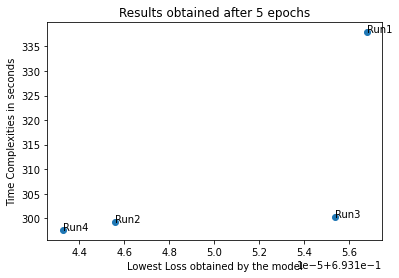

In [123]:
# Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation error
fig,ax = plt.subplots()
ax.scatter(lowest_loss_obtained, time_complexities)

plt.title('Results obtained after 5 epochs')
plt.ylabel('Time Complexities in seconds')
plt.xlabel('Lowest Loss obtained by the model')

for x,y in enumerate(models):
    ax.annotate(y, (lowest_loss_obtained[x], time_complexities[x]))    

In [124]:
architecture2_mean = statistics.mean(lowest_loss_obtained)
print('Architecture2 Validation Loss Mean: ', architecture2_mean)

Architecture2 Validation Loss Mean:  0.6931502372026443


In [125]:
architecture2_stddev = statistics.stdev(lowest_loss_obtained)
print('Architecture2 Validation Loss Std Dev: ', architecture2_stddev)

Architecture2 Validation Loss Std Dev:  6.819350537854202e-06


In [126]:
architecture2_time_mean = statistics.mean(time_complexities)
print('Architecture2 Time Complexity Mean: ', architecture2_time_mean)

Architecture2 Time Complexity Mean:  308.78151477710344


In [127]:
acc_list = [bp_validation_acc1[-1],bp_validation_acc2[-1],bp_validation_acc3[-1],bp_validation_acc4[-1]]
architecture2_acc_mean = statistics.mean(acc_list)
print('Architecture2 Validation Accuracy Mean: ', architecture2_acc_mean*100)

Architecture2 Validation Accuracy Mean:  50.0


### Architecture3 - 1st LSTM layer,  2nd hidden layer=40 nodes, 3rd hidden layer=20 nodes, epochs=5, batch_size=20, optimizer=adam, activation=tanh

### Run1

In [128]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(LSTM(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(20, input_dim=40, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 57s 189ms/step - loss: 0.6931 - accuracy: 0.5072 - val_loss: 0.6943 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 48s 160ms/step - loss: 0.6934 - accuracy: 0.5041 - val_loss: 0.6933 - val_accuracy: 0.4983
Epoch 3/5
301/301 [==============================] - 52s 171ms/step - loss: 0.6933 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 54s 178ms/step - loss: 0.6933 - accuracy: 0.5014 - val_loss: 0.6933 - val_accuracy: 0.4983
Epoch 5/5
301/301 [==============================] - 56s 187ms/step - loss: 0.6933 - accuracy: 0.4918 - val_loss: 0.6932 - val_accuracy: 0.4983


In [129]:
# Calculating the final validation mse
bp_validation_error1 = history_bp.history['val_loss']
print('Final Validation Loss for LSTM Model for 1st Run:', bp_validation_error1[-1] )

# Calculating the final validation accracy
bp_validation_acc1 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for LSTM Model for 1st Run:', bp_validation_acc1[-1] )


# Calculating the time complexity
bp_time_complexity1 = sum(time_bp)
print('Time complexity for LSTM Model for 1st Run:', bp_time_complexity1,'seconds')

Final Validation Loss for LSTM Model for 1st Run: 0.6931566596031189
Final Validation Accuracy for LSTM Model for 1st Run: 0.4982510805130005
Time complexity for LSTM Model for 1st Run: 271.0236233799951 seconds


### Run2

In [130]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(LSTM(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(20, input_dim=40, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 61s 204ms/step - loss: 0.6931 - accuracy: 0.5042 - val_loss: 0.6944 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 56s 187ms/step - loss: 0.6934 - accuracy: 0.5034 - val_loss: 0.6933 - val_accuracy: 0.4983
Epoch 3/5
301/301 [==============================] - 61s 204ms/step - loss: 0.6933 - accuracy: 0.4999 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 52s 172ms/step - loss: 0.6933 - accuracy: 0.5009 - val_loss: 0.6933 - val_accuracy: 0.4983
Epoch 5/5
301/301 [==============================] - 60s 199ms/step - loss: 0.6934 - accuracy: 0.4921 - val_loss: 0.6932 - val_accuracy: 0.4971


In [131]:
# Calculating the final validation mse
bp_validation_error2 = history_bp.history['val_loss']
print('Final Validation Loss for LSTM Model for 2nd Run:', bp_validation_error2[-1] )

# Calculating the final validation accracy
bp_validation_acc2 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for LSTM Model for 2nd Run:', bp_validation_acc2[-1] )


# Calculating the time complexity
bp_time_complexity2 = sum(time_bp)
print('Time complexity for LSTM Model for 2nd Run:', bp_time_complexity2,'seconds')

Final Validation Loss for LSTM Model for 2nd Run: 0.6931614875793457
Final Validation Accuracy for LSTM Model for 2nd Run: 0.4970851242542267
Time complexity for LSTM Model for 2nd Run: 295.98346680996474 seconds


### Run3

In [188]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(LSTM(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(20, input_dim=40, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 55s 181ms/step - loss: 0.6931 - accuracy: 0.5079 - val_loss: 0.6947 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 61s 202ms/step - loss: 0.6934 - accuracy: 0.5031 - val_loss: 0.6933 - val_accuracy: 0.4983
Epoch 3/5
301/301 [==============================] - 58s 193ms/step - loss: 0.6933 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 61s 202ms/step - loss: 0.6933 - accuracy: 0.5014 - val_loss: 0.6933 - val_accuracy: 0.4983
Epoch 5/5
301/301 [==============================] - 58s 192ms/step - loss: 0.6933 - accuracy: 0.4921 - val_loss: 0.6932 - val_accuracy: 0.4983


In [189]:
# Calculating the final validation mse
bp_validation_error3 = history_bp.history['val_loss']
print('Final Validation Loss for LSTM Model for 3rd Run:', bp_validation_error3[-1] )

# Calculating the final validation accracy
bp_validation_acc3 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for LSTM Model for 3rd Run:', bp_validation_acc3[-1] )

# Calculating the time complexity
bp_time_complexity3 = sum(time_bp)
print('Time complexity for LSTM Model for 3rd Run:', bp_time_complexity3,'seconds')

Final Validation Loss for LSTM Model for 3rd Run: 0.693157434463501
Final Validation Accuracy for LSTM Model for 3rd Run: 0.4982510805130005
Time complexity for LSTM Model for 3rd Run: 297.2361271341797 seconds


### Run4

In [190]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(LSTM(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(20, input_dim=40, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 74s 246ms/step - loss: 0.6931 - accuracy: 0.5042 - val_loss: 0.6944 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 81s 270ms/step - loss: 0.6934 - accuracy: 0.5041 - val_loss: 0.6933 - val_accuracy: 0.4983
Epoch 3/5
301/301 [==============================] - 79s 261ms/step - loss: 0.6933 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 83s 276ms/step - loss: 0.6933 - accuracy: 0.5014 - val_loss: 0.6933 - val_accuracy: 0.4983
Epoch 5/5
301/301 [==============================] - 98s 325ms/step - loss: 0.6933 - accuracy: 0.4951 - val_loss: 0.6932 - val_accuracy: 0.4983


In [191]:
# Calculating the final validation mse
bp_validation_error4 = history_bp.history['val_loss']
print('Final Validation Loss for LSTM Model for 4th Run:', bp_validation_error4[-1] )

# Calculating the final validation accracy
bp_validation_acc4 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for LSTM Model for 4th Run:', bp_validation_acc4[-1] )

# Calculating the time complexity
bp_time_complexity4 = sum(time_bp)
print('Time complexity for LSTM Model for 4th Run:', bp_time_complexity4,'seconds')

Final Validation Loss for LSTM Model for 4th Run: 0.693157434463501
Final Validation Accuracy for LSTM Model for 4th Run: 0.4982510805130005
Time complexity for LSTM Model for 4th Run: 420.1400869949721 seconds


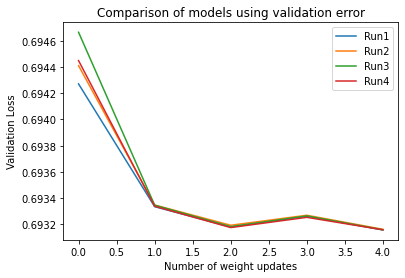

In [192]:
# Plotting validation loss of all the trials vs the Number of weight updates
plt.plot(bp_validation_error1)
plt.plot(bp_validation_error2)
plt.plot(bp_validation_error3)
plt.plot(bp_validation_error4)
plt.title('Comparison of models using validation error')
plt.ylabel('Validation Loss')
plt.xlabel('Number of weight updates')
plt.legend(['Run1', 'Run2', 'Run3', 'Run4'], loc='upper right')
plt.show()

In [193]:
# Storing the final validation for all models in a list
lowest_loss_obtained = [bp_validation_error1[-1],bp_validation_error2[-1],bp_validation_error3[-1],bp_validation_error4[-1]]

# Storing the time complexities for all models in a list
time_complexities = [bp_time_complexity1,bp_time_complexity2,bp_time_complexity3,bp_time_complexity4]

# Creating a list with all the model names
models = ['Run1', 'Run2', 'Run3', 'Run4']

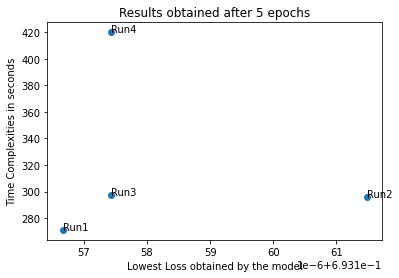

In [194]:
# Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation error
fig,ax = plt.subplots()
ax.scatter(lowest_loss_obtained, time_complexities)

plt.title('Results obtained after 5 epochs')
plt.ylabel('Time Complexities in seconds')
plt.xlabel('Lowest Loss obtained by the model')

for x,y in enumerate(models):
    ax.annotate(y, (lowest_loss_obtained[x], time_complexities[x]))    

In [195]:
architecture3_mean = statistics.mean(lowest_loss_obtained)
print('Architecture3 Validation Loss Mean: ', architecture3_mean)

Architecture3 Validation Loss Mean:  0.6931582540273666


In [196]:
architecture3_stddev = statistics.stdev(lowest_loss_obtained)
print('Architecture3 Validation Loss Std Dev: ', architecture3_stddev)

Architecture3 Validation Loss Std Dev:  2.1864291240054656e-06


In [197]:
architecture3_time_mean = statistics.mean(time_complexities)
print('Architecture3 Time Complexity Mean: ', architecture3_time_mean)

Architecture3 Time Complexity Mean:  321.0958260797779


In [198]:
acc_list = [bp_validation_acc1[-1],bp_validation_acc2[-1],bp_validation_acc3[-1],bp_validation_acc4[-1]]
architecture3_acc_mean = statistics.mean(acc_list)
print('Architecture3 Validation Accuracy Mean: ', architecture3_acc_mean*100)

Architecture3 Validation Accuracy Mean:  49.795959144830704


In [199]:
# Creating a summary table for the model names, lowest MSE and their time complexities
model_summary = pd.DataFrame({"Model":["LSTM Architecture1","LSTM Architecture2",
                                       "LSTM Architecture3"], "Mean Validation loss after 4 trials":[architecture1_mean,architecture2_mean,architecture3_mean],
                              "Mean Standard deviation after 4 trials":[architecture1_stddev,architecture2_stddev,architecture3_stddev],
                            "Mean Time Complexity in seconds after 4 trials":[architecture1_time_mean,architecture2_time_mean,architecture3_time_mean],
                              "Mean Validation Accuracy after 4 trials":[architecture1_acc_mean,architecture2_acc_mean,architecture3_acc_mean]
                                               })

In [200]:
model_summary

,Model,Mean Validation loss after 4 trials,Mean Standard deviation after 4 trials,Mean Time Complexity in seconds after 4 trials,Mean Validation Accuracy after 4 trials
0,LSTM Architecture1,0.693162,0.000000,404.070966,0.498251
1,LSTM Architecture2,0.693150,0.000007,308.781515,0.500000
2,LSTM Architecture3,0.693158,0.000002,321.095826,0.497960


No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.500


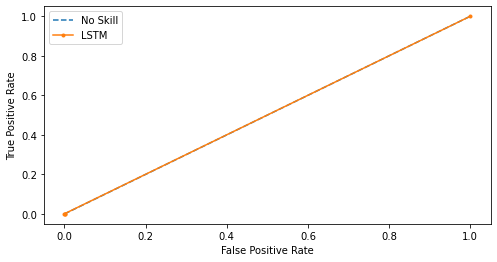

In [201]:
ROC_AUC_curve_upgraded(model=model_bp,model_name="LSTM")

### Using Best Model - LSTM Architecture1 - with - epochs=20

In [215]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(LSTM(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=20, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/20
376/376 [==============================] - 77s 205ms/step - loss: 0.7372 - accuracy: 0.5000 - val_loss: 0.7011 - val_accuracy: 0.5000
Epoch 2/20
376/376 [==============================] - 65s 174ms/step - loss: 0.6957 - accuracy: 0.5000 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 3/20
376/376 [==============================] - 65s 173ms/step - loss: 0.6934 - accuracy: 0.4999 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/20
376/376 [==============================] - 62s 165ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/20
376/376 [==============================] - 58s 154ms/step - loss: 0.6932 - accuracy: 0.4931 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/20
376/376 [==============================] - 58s 153ms/step - loss: 0.6932 - accuracy: 0.4925 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/20
376/376 [==============================] - 58s 155ms/step - loss: 0.6932 - accuracy: 0.4923 - val_loss: 0.6932 - val_ac

In [216]:
# Calculating the final validation loss
bp_validation_error_best = history_bp.history['val_loss']
print('Final Validation Loss for Best LSTM Model:', bp_validation_error_best[-1] )

# Calculating the final validation accracy
bp_validation_acc_best = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Best LSTM Model:', bp_validation_acc_best[-1] )


# Calculating the time complexity
bp_time_complexity_best = sum(time_bp)
print('Time complexity for Best LSTM Model:', bp_time_complexity_best,'seconds')

Final Validation Loss for Best LSTM Model: 0.6931639909744263
Final Validation Accuracy for Best LSTM Model: 0.5
Time complexity for Best LSTM Model: 1340.7730651039165 seconds


In [217]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(y_true=y_test,y_pred=(model_bp.predict(X_test)>0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       536
           1       0.50      1.00      0.67       536

    accuracy                           0.50      1072
   macro avg       0.25      0.50      0.33      1072
weighted avg       0.25      0.50      0.33      1072



/home/ssingh56/anaconda3/envs/production/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Gated Recurrent Unit

- Initially we have set the seed so that model performance does not vary with each run
- Here, we have setup a GRU model
- We have used the activation function as 'relu' for the GRU layer. We have used a single GRU unit and input shape is [features, TimeSteps] i.e. [20,1]
- We have used the loss function as 'BCE' and optimizer as 'adam'
- Hyperparameters used for training:
    - epochs = 5
    - batch_size = 20


- GRU model performed with the below performance on the testing dataset:
- Accuracy: 50%

### Architecture1 - 1 GRU layer , optimizer=SGD, activation=tanh, epochs=5, batch_size=20

### Run1

In [202]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(GRU(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 155s 514ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6931 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 147s 487ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6932 - val_accuracy: 0.4979
Epoch 3/5
301/301 [==============================] - 143s 475ms/step - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.4979
Epoch 4/5
301/301 [==============================] - 131s 434ms/step - loss: 0.6932 - accuracy: 0.4949 - val_loss: 0.6932 - val_accuracy: 0.4979
Epoch 5/5
301/301 [==============================] - 106s 351ms/step - loss: 0.6932 - accuracy: 0.4986 - val_loss: 0.6932 - val_accuracy: 0.4979


In [203]:
# Calculating the final validation mse
bp_validation_error1 = history_bp.history['val_loss']
print('Final Validation Loss for GRU Model for 1st Run:', bp_validation_error1[-1] )

# Calculating the final validation accracy
bp_validation_acc1 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for GRU Model for 1st Run:', bp_validation_acc1[-1] )


# Calculating the time complexity
bp_time_complexity1 = sum(time_bp)
print('Time complexity for GRU Model for 1st Run:', bp_time_complexity1,'seconds')

Final Validation Loss for GRU Model for 1st Run: 0.693164587020874
Final Validation Accuracy for GRU Model for 1st Run: 0.49786242842674255
Time complexity for GRU Model for 1st Run: 688.1744270459749 seconds


### Run2

In [204]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(GRU(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 150s 500ms/step - loss: 0.6940 - accuracy: 0.4993 - val_loss: 0.6933 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 149s 496ms/step - loss: 0.6933 - accuracy: 0.4954 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 3/5
301/301 [==============================] - 129s 429ms/step - loss: 0.6932 - accuracy: 0.4929 - val_loss: 0.6931 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 132s 439ms/step - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 5/5
301/301 [==============================] - 147s 488ms/step - loss: 0.6933 - accuracy: 0.4978 - val_loss: 0.6932 - val_accuracy: 0.4983


In [205]:
# Calculating the final validation mse
bp_validation_error2 = history_bp.history['val_loss']
print('Final Validation Loss for GRU Model for 2nd Run:', bp_validation_error2[-1] )

# Calculating the final validation accracy
bp_validation_acc2 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for GRU Model for 2nd Run:', bp_validation_acc2[-1] )


# Calculating the time complexity
bp_time_complexity2 = sum(time_bp)
print('Time complexity for GRU Model for 2nd Run:', bp_time_complexity2,'seconds')

Final Validation Loss for GRU Model for 2nd Run: 0.6931663155555725
Final Validation Accuracy for GRU Model for 2nd Run: 0.4982510805130005
Time complexity for GRU Model for 2nd Run: 716.1061299510766 seconds


### Run3

In [206]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(GRU(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 159s 529ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6931 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 128s 424ms/step - loss: 0.6932 - accuracy: 0.4979 - val_loss: 0.6931 - val_accuracy: 0.4983
Epoch 3/5
301/301 [==============================] - 148s 492ms/step - loss: 0.6932 - accuracy: 0.4978 - val_loss: 0.6931 - val_accuracy: 0.4983
Epoch 4/5
301/301 [==============================] - 107s 355ms/step - loss: 0.6932 - accuracy: 0.4946 - val_loss: 0.6931 - val_accuracy: 0.4983
Epoch 5/5
301/301 [==============================] - 72s 239ms/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6931 - val_accuracy: 0.4983


In [207]:
# Calculating the final validation mse
bp_validation_error3 = history_bp.history['val_loss']
print('Final Validation Loss for GRU Model for 3rd Run:', bp_validation_error3[-1] )

# Calculating the final validation accracy
bp_validation_acc3 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for GRU Model for 3rd Run:', bp_validation_acc3[-1] )


# Calculating the time complexity
bp_time_complexity3 = sum(time_bp)
print('Time complexity for GRU Model for 3rd Run:', bp_time_complexity3,'seconds')

Final Validation Loss for GRU Model for 3rd Run: 0.6931102871894836
Final Validation Accuracy for GRU Model for 3rd Run: 0.4982510805130005
Time complexity for GRU Model for 3rd Run: 621.9464274720522 seconds


### Run4

In [208]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(GRU(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 149s 496ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6931 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 166s 553ms/step - loss: 0.6932 - accuracy: 0.4979 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 3/5
301/301 [==============================] - 123s 407ms/step - loss: 0.6932 - accuracy: 0.4988 - val_loss: 0.6931 - val_accuracy: 0.4983
Epoch 4/5
301/301 [==============================] - 159s 527ms/step - loss: 0.6932 - accuracy: 0.4946 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 5/5
301/301 [==============================] - 148s 492ms/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6932 - val_accuracy: 0.4983


In [209]:
# Calculating the final validation mse
bp_validation_error4 = history_bp.history['val_loss']
print('Final Validation Loss for GRU Model for 4th Run:', bp_validation_error4[-1] )

# Calculating the final validation accracy
bp_validation_acc4 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for GRU Model for 4th Run:', bp_validation_acc4[-1] )


# Calculating the time complexity
bp_time_complexity4 = sum(time_bp)
print('Time complexity for GRU Model for 4th Run:', bp_time_complexity4,'seconds')

Final Validation Loss for GRU Model for 4th Run: 0.6931518912315369
Final Validation Accuracy for GRU Model for 4th Run: 0.4982510805130005
Time complexity for GRU Model for 4th Run: 753.262786176987 seconds


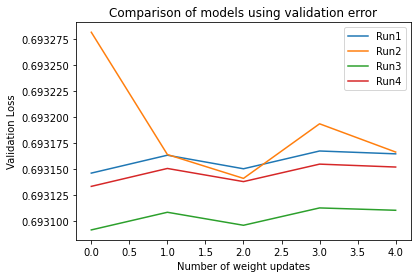

In [210]:
# Plotting validation loss of all the trials vs the Number of weight updates
plt.plot(bp_validation_error1)
plt.plot(bp_validation_error2)
plt.plot(bp_validation_error3)
plt.plot(bp_validation_error4)
plt.title('Comparison of models using validation error')
plt.ylabel('Validation Loss')
plt.xlabel('Number of weight updates')
plt.legend(['Run1', 'Run2', 'Run3', 'Run4'], loc='upper right')
plt.show()

In [211]:
# Storing the final validation for all models in a list
lowest_loss_obtained = [bp_validation_error1[-1],bp_validation_error2[-1],bp_validation_error3[-1],bp_validation_error4[-1]]

# Storing the time complexities for all models in a list
time_complexities = [bp_time_complexity1,bp_time_complexity2,bp_time_complexity3,bp_time_complexity4]

# Creating a list with all the model names
models = ['Run1', 'Run2', 'Run3', 'Run4']

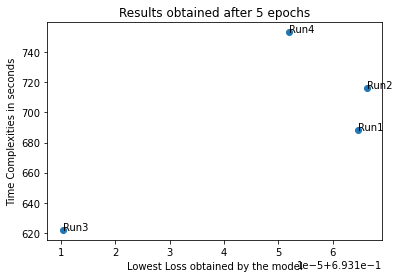

In [212]:
# Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation error
fig,ax = plt.subplots()
ax.scatter(lowest_loss_obtained, time_complexities)

plt.title('Results obtained after 5 epochs')
plt.ylabel('Time Complexities in seconds')
plt.xlabel('Lowest Loss obtained by the model')

for x,y in enumerate(models):
    ax.annotate(y, (lowest_loss_obtained[x], time_complexities[x]))    

In [213]:
architecture1_mean = statistics.mean(lowest_loss_obtained)
print('Architecture1 Validation Loss Mean: ', architecture1_mean)

Architecture1 Validation Loss Mean:  0.6931482702493668


In [214]:
architecture1_stddev = statistics.stdev(lowest_loss_obtained)
print('Architecture1 Validation Loss Std Dev: ', architecture1_stddev)

Architecture1 Validation Loss Std Dev:  2.6125941504184553e-05


In [215]:
architecture1_time_mean = statistics.mean(time_complexities)
print('Architecture1 Time Complexity Mean: ', architecture1_time_mean)

Architecture1 Time Complexity Mean:  694.8724426615227


In [216]:
acc_list = [bp_validation_acc1[-1],bp_validation_acc2[-1],bp_validation_acc3[-1],bp_validation_acc4[-1]]
architecture1_acc_mean = statistics.mean(acc_list)
print('Architecture1 Validation Accuracy Mean: ', architecture1_acc_mean*100)

Architecture1 Validation Accuracy Mean:  49.8153917491436


### Architecture2 - 1 GRU layer, 1 hidden layer=40 nodes, epochs=5, batch_size=20, optimizer=adam, activation=tanh

### Run1

In [217]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(GRU(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 166s 551ms/step - loss: 0.6949 - accuracy: 0.5019 - val_loss: 0.6961 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 125s 415ms/step - loss: 0.6938 - accuracy: 0.4968 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 3/5
301/301 [==============================] - 129s 428ms/step - loss: 0.6937 - accuracy: 0.4926 - val_loss: 0.6937 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 162s 537ms/step - loss: 0.6938 - accuracy: 0.5057 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 5/5
301/301 [==============================] - 133s 440ms/step - loss: 0.6938 - accuracy: 0.4859 - val_loss: 0.6931 - val_accuracy: 0.5017


In [218]:
# Calculating the final validation mse
bp_validation_error1 = history_bp.history['val_loss']
print('Final Validation loss for GRU Model for 1st Run:', bp_validation_error1[-1] )

# Calculating the final validation accracy
bp_validation_acc1 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for GRU Model for 1st Run:', bp_validation_acc1[-1] )


# Calculating the time complexity
bp_time_complexity1 = sum(time_bp)
print('Time complexity for GRU Model for 1st Run:', bp_time_complexity1,'seconds')

Final Validation loss for GRU Model for 1st Run: 0.6931427717208862
Final Validation Accuracy for GRU Model for 1st Run: 0.5017489194869995
Time complexity for GRU Model for 1st Run: 722.7353974310681 seconds


### Run2

In [219]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(GRU(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 154s 513ms/step - loss: 0.6931 - accuracy: 0.5079 - val_loss: 0.6942 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 129s 428ms/step - loss: 0.6934 - accuracy: 0.5031 - val_loss: 0.6934 - val_accuracy: 0.4979
Epoch 3/5
301/301 [==============================] - 170s 566ms/step - loss: 0.6934 - accuracy: 0.4994 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 145s 481ms/step - loss: 0.6933 - accuracy: 0.4993 - val_loss: 0.6933 - val_accuracy: 0.4979
Epoch 5/5
301/301 [==============================] - 173s 574ms/step - loss: 0.6934 - accuracy: 0.4896 - val_loss: 0.6932 - val_accuracy: 0.4979


In [220]:
# Calculating the final validation mse
bp_validation_error2 = history_bp.history['val_loss']
print('Final Validation Loss for GRU Model for 2nd Run:', bp_validation_error2[-1] )

# Calculating the final validation accracy
bp_validation_acc2 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for GRU Model for 2nd Run:', bp_validation_acc2[-1] )


# Calculating the time complexity
bp_time_complexity2 = sum(time_bp)
print('Time complexity for GRU Model for 2nd Run:', bp_time_complexity2,'seconds')

Final Validation Loss for GRU Model for 2nd Run: 0.693192720413208
Final Validation Accuracy for GRU Model for 2nd Run: 0.49786242842674255
Time complexity for GRU Model for 2nd Run: 779.5309656849131 seconds


### Run3

In [221]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(GRU(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 201s 668ms/step - loss: 0.6931 - accuracy: 0.5082 - val_loss: 0.6940 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 142s 473ms/step - loss: 0.6933 - accuracy: 0.5052 - val_loss: 0.6934 - val_accuracy: 0.4983
Epoch 3/5
301/301 [==============================] - 128s 424ms/step - loss: 0.6933 - accuracy: 0.5001 - val_loss: 0.6933 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 172s 571ms/step - loss: 0.6944 - accuracy: 0.5001 - val_loss: 0.6936 - val_accuracy: 0.4983
Epoch 5/5
301/301 [==============================] - 137s 456ms/step - loss: 0.6941 - accuracy: 0.4903 - val_loss: 0.6931 - val_accuracy: 0.5017


In [222]:
# Calculating the final validation mse
bp_validation_error3 = history_bp.history['val_loss']
print('Final Validation Loss for GRU Model for 3rd Run:', bp_validation_error3[-1] )

# Calculating the final validation accracy
bp_validation_acc3 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for GRU Model for 3rd Run:', bp_validation_acc3[-1] )

# Calculating the time complexity
bp_time_complexity3 = sum(time_bp)
print('Time complexity for GRU Model for 3rd Run:', bp_time_complexity3,'seconds')

Final Validation Loss for GRU Model for 3rd Run: 0.6931411623954773
Final Validation Accuracy for GRU Model for 3rd Run: 0.5017489194869995
Time complexity for GRU Model for 3rd Run: 788.7430767489132 seconds


### Run4

In [223]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(GRU(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 180s 597ms/step - loss: 0.6931 - accuracy: 0.5086 - val_loss: 0.6941 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 159s 527ms/step - loss: 0.6934 - accuracy: 0.5034 - val_loss: 0.6934 - val_accuracy: 0.4979
Epoch 3/5
301/301 [==============================] - 153s 508ms/step - loss: 0.6934 - accuracy: 0.4991 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 136s 452ms/step - loss: 0.6933 - accuracy: 0.4983 - val_loss: 0.6933 - val_accuracy: 0.4979
Epoch 5/5
301/301 [==============================] - 96s 319ms/step - loss: 0.6934 - accuracy: 0.4899 - val_loss: 0.6932 - val_accuracy: 0.4983


In [224]:
# Calculating the final validation mse
bp_validation_error4 = history_bp.history['val_loss']
print('Final Validation Loss for GRU Model for 4th Run:', bp_validation_error4[-1] )

# Calculating the final validation accracy
bp_validation_acc4 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for GRU Model for 4th Run:', bp_validation_acc4[-1] )

# Calculating the time complexity
bp_time_complexity4 = sum(time_bp)
print('Time complexity for GRU Model for 4th Run:', bp_time_complexity4,'seconds')

Final Validation Loss for GRU Model for 4th Run: 0.6932286024093628
Final Validation Accuracy for GRU Model for 4th Run: 0.4982510805130005
Time complexity for GRU Model for 4th Run: 731.4720015919302 seconds


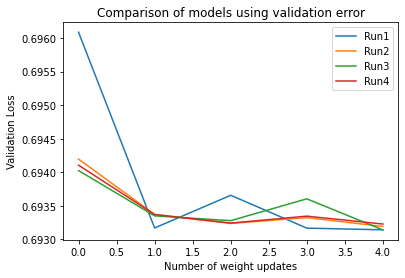

In [225]:
# Plotting validation loss of all the trials vs the Number of weight updates
plt.plot(bp_validation_error1)
plt.plot(bp_validation_error2)
plt.plot(bp_validation_error3)
plt.plot(bp_validation_error4)
plt.title('Comparison of models using validation error')
plt.ylabel('Validation Loss')
plt.xlabel('Number of weight updates')
plt.legend(['Run1', 'Run2', 'Run3', 'Run4'], loc='upper right')
plt.show()

In [226]:
# Storing the final validation for all models in a list
lowest_loss_obtained = [bp_validation_error1[-1],bp_validation_error2[-1],bp_validation_error3[-1],bp_validation_error4[-1]]

# Storing the time complexities for all models in a list
time_complexities = [bp_time_complexity1,bp_time_complexity2,bp_time_complexity3,bp_time_complexity4]

# Creating a list with all the model names
models = ['Run1', 'Run2', 'Run3', 'Run4']

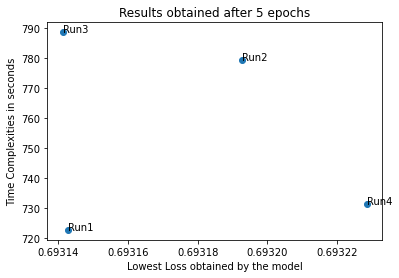

In [227]:
# Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation error
fig,ax = plt.subplots()
ax.scatter(lowest_loss_obtained, time_complexities)

plt.title('Results obtained after 5 epochs')
plt.ylabel('Time Complexities in seconds')
plt.xlabel('Lowest Loss obtained by the model')

for x,y in enumerate(models):
    ax.annotate(y, (lowest_loss_obtained[x], time_complexities[x]))    

In [228]:
architecture2_mean = statistics.mean(lowest_loss_obtained)
print('Architecture2 Validation Loss Mean: ', architecture2_mean)

Architecture2 Validation Loss Mean:  0.6931763142347336


In [229]:
architecture2_stddev = statistics.stdev(lowest_loss_obtained)
print('Architecture2 Validation Loss Std Dev: ', architecture2_stddev)

Architecture2 Validation Loss Std Dev:  4.228462264420794e-05


In [230]:
architecture2_time_mean = statistics.mean(time_complexities)
print('Architecture2 Time Complexity Mean: ', architecture2_time_mean)

Architecture2 Time Complexity Mean:  755.6203603642061


In [231]:
acc_list = [bp_validation_acc1[-1],bp_validation_acc2[-1],bp_validation_acc3[-1],bp_validation_acc4[-1]]
architecture2_acc_mean = statistics.mean(acc_list)
print('Architecture2 Validation Accuracy Mean: ', architecture2_acc_mean*100)

Architecture2 Validation Accuracy Mean:  49.99028369784355


### Architecture3 - 1st GRU layer,  2nd hidden layer=40 nodes, 3rd hidden layer=20 nodes, epochs=5, batch_size=20, optimizer=adam, activation=tanh

### Run1

In [232]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(GRU(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(20, input_dim=40, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 120s 398ms/step - loss: 0.6938 - accuracy: 0.5049 - val_loss: 0.6975 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 128s 425ms/step - loss: 0.6943 - accuracy: 0.5022 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 3/5
301/301 [==============================] - 116s 384ms/step - loss: 0.6942 - accuracy: 0.4906 - val_loss: 0.6937 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 110s 364ms/step - loss: 0.6942 - accuracy: 0.4959 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 5/5
301/301 [==============================] - 122s 405ms/step - loss: 0.6942 - accuracy: 0.4889 - val_loss: 0.6932 - val_accuracy: 0.5017


In [233]:
# Calculating the final validation mse
bp_validation_error1 = history_bp.history['val_loss']
print('Final Validation Loss for GRU Model for 1st Run:', bp_validation_error1[-1] )

# Calculating the final validation accracy
bp_validation_acc1 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for GRU Model for 1st Run:', bp_validation_acc1[-1] )


# Calculating the time complexity
bp_time_complexity1 = sum(time_bp)
print('Time complexity for GRU Model for 1st Run:', bp_time_complexity1,'seconds')

Final Validation Loss for GRU Model for 1st Run: 0.6931529641151428
Final Validation Accuracy for GRU Model for 1st Run: 0.5017489194869995
Time complexity for GRU Model for 1st Run: 602.97787749907 seconds


### Run2

In [234]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(GRU(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(20, input_dim=40, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 162s 539ms/step - loss: 0.6931 - accuracy: 0.5086 - val_loss: 0.6946 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 149s 496ms/step - loss: 0.6934 - accuracy: 0.5034 - val_loss: 0.6934 - val_accuracy: 0.4979
Epoch 3/5
301/301 [==============================] - 134s 444ms/step - loss: 0.6933 - accuracy: 0.4991 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 176s 584ms/step - loss: 0.6933 - accuracy: 0.5009 - val_loss: 0.6933 - val_accuracy: 0.4979
Epoch 5/5
301/301 [==============================] - 159s 528ms/step - loss: 0.6934 - accuracy: 0.4943 - val_loss: 0.6932 - val_accuracy: 0.4979


In [235]:
# Calculating the final validation mse
bp_validation_error2 = history_bp.history['val_loss']
print('Final Validation Loss for GRU Model for 2nd Run:', bp_validation_error2[-1] )

# Calculating the final validation accracy
bp_validation_acc2 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for GRU Model for 2nd Run:', bp_validation_acc2[-1] )


# Calculating the time complexity
bp_time_complexity2 = sum(time_bp)
print('Time complexity for GRU Model for 2nd Run:', bp_time_complexity2,'seconds')

Final Validation Loss for GRU Model for 2nd Run: 0.6931726336479187
Final Validation Accuracy for GRU Model for 2nd Run: 0.49786242842674255
Time complexity for GRU Model for 2nd Run: 788.8296979651786 seconds


### Run3

In [236]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(GRU(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(20, input_dim=40, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 176s 583ms/step - loss: 0.6941 - accuracy: 0.5019 - val_loss: 0.6966 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 119s 394ms/step - loss: 0.6945 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5017
Epoch 3/5
301/301 [==============================] - 156s 518ms/step - loss: 0.6948 - accuracy: 0.4923 - val_loss: 0.6935 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 99s 328ms/step - loss: 0.6945 - accuracy: 0.4916 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 5/5
301/301 [==============================] - 84s 279ms/step - loss: 0.6947 - accuracy: 0.4879 - val_loss: 0.6933 - val_accuracy: 0.5017


In [237]:
# Calculating the final validation mse
bp_validation_error3 = history_bp.history['val_loss']
print('Final Validation Loss for GRU Model for 3rd Run:', bp_validation_error3[-1] )

# Calculating the final validation accracy
bp_validation_acc3 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for GRU Model for 3rd Run:', bp_validation_acc3[-1] )

# Calculating the time complexity
bp_time_complexity3 = sum(time_bp)
print('Time complexity for GRU Model for 3rd Run:', bp_time_complexity3,'seconds')

Final Validation Loss for GRU Model for 3rd Run: 0.6932556629180908
Final Validation Accuracy for GRU Model for 3rd Run: 0.5017489194869995
Time complexity for GRU Model for 3rd Run: 640.9325441363035 seconds


### Run4

In [238]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(GRU(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(40, input_dim=20, activation='tanh'))
model_bp.add(Dense(20, input_dim=40, activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 164s 544ms/step - loss: 0.6943 - accuracy: 0.5019 - val_loss: 0.6960 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 133s 442ms/step - loss: 0.6946 - accuracy: 0.5012 - val_loss: 0.6931 - val_accuracy: 0.5017
Epoch 3/5
301/301 [==============================] - 144s 479ms/step - loss: 0.6950 - accuracy: 0.4919 - val_loss: 0.6934 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 146s 486ms/step - loss: 0.6946 - accuracy: 0.4906 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 5/5
301/301 [==============================] - 165s 549ms/step - loss: 0.6949 - accuracy: 0.4859 - val_loss: 0.6933 - val_accuracy: 0.5017


In [239]:
# Calculating the final validation mse
bp_validation_error4 = history_bp.history['val_loss']
print('Final Validation Loss for GRU Model for 4th Run:', bp_validation_error4[-1] )

# Calculating the final validation accracy
bp_validation_acc4 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for GRU Model for 4th Run:', bp_validation_acc4[-1] )

# Calculating the time complexity
bp_time_complexity4 = sum(time_bp)
print('Time complexity for GRU Model for 4th Run:', bp_time_complexity4,'seconds')

Final Validation Loss for GRU Model for 4th Run: 0.6933316588401794
Final Validation Accuracy for GRU Model for 4th Run: 0.5017489194869995
Time complexity for GRU Model for 4th Run: 761.3209689288633 seconds


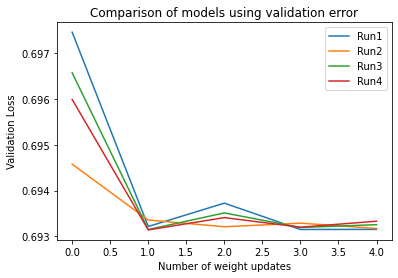

In [240]:
# Plotting validation loss of all the trials vs the Number of weight updates
plt.plot(bp_validation_error1)
plt.plot(bp_validation_error2)
plt.plot(bp_validation_error3)
plt.plot(bp_validation_error4)
plt.title('Comparison of models using validation error')
plt.ylabel('Validation Loss')
plt.xlabel('Number of weight updates')
plt.legend(['Run1', 'Run2', 'Run3', 'Run4'], loc='upper right')
plt.show()

In [241]:
# Storing the final validation for all models in a list
lowest_loss_obtained = [bp_validation_error1[-1],bp_validation_error2[-1],bp_validation_error3[-1],bp_validation_error4[-1]]

# Storing the time complexities for all models in a list
time_complexities = [bp_time_complexity1,bp_time_complexity2,bp_time_complexity3,bp_time_complexity4]

# Creating a list with all the model names
models = ['Run1', 'Run2', 'Run3', 'Run4']

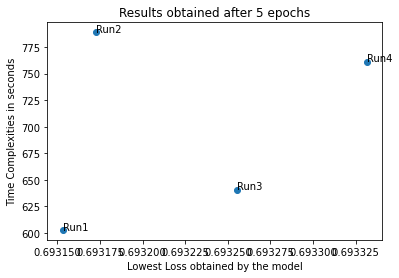

In [242]:
# Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation error
fig,ax = plt.subplots()
ax.scatter(lowest_loss_obtained, time_complexities)

plt.title('Results obtained after 5 epochs')
plt.ylabel('Time Complexities in seconds')
plt.xlabel('Lowest Loss obtained by the model')

for x,y in enumerate(models):
    ax.annotate(y, (lowest_loss_obtained[x], time_complexities[x]))    

In [243]:
architecture3_mean = statistics.mean(lowest_loss_obtained)
print('Architecture3 Validation Loss Mean: ', architecture3_mean)

Architecture3 Validation Loss Mean:  0.693228229880333


In [244]:
architecture3_stddev = statistics.stdev(lowest_loss_obtained)
print('Architecture3 Validation Loss Std Dev: ', architecture3_stddev)

Architecture3 Validation Loss Std Dev:  8.206907205491987e-05


In [245]:
architecture3_time_mean = statistics.mean(time_complexities)
print('Architecture3 Time Complexity Mean: ', architecture3_time_mean)

Architecture3 Time Complexity Mean:  698.5152721323539


In [246]:
acc_list = [bp_validation_acc1[-1],bp_validation_acc2[-1],bp_validation_acc3[-1],bp_validation_acc4[-1]]
architecture3_acc_mean = statistics.mean(acc_list)
print('Architecture3 Validation Accuracy Mean: ', architecture3_acc_mean*100)

Architecture3 Validation Accuracy Mean:  50.07772967219353


In [247]:
# Creating a summary table for the model names, lowest MSE and their time complexities
model_summary = pd.DataFrame({"Model":["GRU Architecture1","GRU Architecture2",
                                       "GRU Architecture3"], "Mean Validation loss after 4 trials":[architecture1_mean,architecture2_mean,architecture3_mean],
                              "Mean Standard deviation after 4 trials":[architecture1_stddev,architecture2_stddev,architecture3_stddev],
                            "Mean Time Complexity in seconds after 4 trials":[architecture1_time_mean,architecture2_time_mean,architecture3_time_mean],
                              "Mean Validation Accuracy after 4 trials":[architecture1_acc_mean,architecture2_acc_mean,architecture3_acc_mean]
                                               })

In [248]:
model_summary

,Model,Mean Validation loss after 4 trials,Mean Standard deviation after 4 trials,Mean Time Complexity in seconds after 4 trials,Mean Validation Accuracy after 4 trials
0,GRU Architecture1,0.693148,0.000026,694.872443,0.498154
1,GRU Architecture2,0.693176,0.000042,755.620360,0.499903
2,GRU Architecture3,0.693228,0.000082,698.515272,0.500777


No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.500


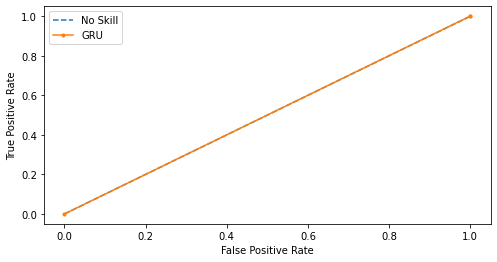

In [249]:
ROC_AUC_curve_upgraded(model=model_bp,model_name="GRU")

### Using Best Model - GRU Architecture1 - with - epochs=20

In [250]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(GRU(units=1, input_shape=[20,1], activation='tanh'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=20, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/20
301/301 [==============================] - 158s 524ms/step - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 2/20
301/301 [==============================] - 150s 499ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6932 - val_accuracy: 0.4979
Epoch 3/20
301/301 [==============================] - 174s 579ms/step - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.4983
Epoch 4/20
301/301 [==============================] - 169s 562ms/step - loss: 0.6932 - accuracy: 0.4949 - val_loss: 0.6932 - val_accuracy: 0.4979
Epoch 5/20
301/301 [==============================] - 120s 398ms/step - loss: 0.6932 - accuracy: 0.4986 - val_loss: 0.6932 - val_accuracy: 0.4979
Epoch 6/20
301/301 [==============================] - 142s 472ms/step - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 7/20
301/301 [==============================] - 149s 494ms/step - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6932 -

In [251]:
# Calculating the final validation loss
bp_validation_error_best = history_bp.history['val_loss']
print('Final Validation Loss for Best GRU Model:', bp_validation_error_best[-1] )

# Calculating the final validation accracy
bp_validation_acc_best = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Best GRU Model:', bp_validation_acc_best[-1] )


# Calculating the time complexity
bp_time_complexity_best = sum(time_bp)
print('Time complexity for Best GRU Model:', bp_time_complexity_best,'seconds')

Final Validation Loss for Best GRU Model: 0.6931979656219482
Final Validation Accuracy for Best GRU Model: 0.5017489194869995
Time complexity for Best GRU Model: 2765.809483957826 seconds


In [252]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(y_true=y_test,y_pred=(model_bp.predict(X_test)>0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1282
           1       0.50      1.00      0.67      1291

    accuracy                           0.50      2573
   macro avg       0.25      0.50      0.33      2573
weighted avg       0.25      0.50      0.34      2573



/home/ssingh56/anaconda3/envs/production/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Convolutional Neural Network

- Initially we have set the seed so that model performance does not vary with each run
- Here, we have setup a CNN model
- We have used the activation function as 'relu' for the CNN layer. We have used a 64 filters and 3 kernels and input shape is [features, TimeSteps] i.e. [20,1]
- First conv layer is followed by a flattening layer, followed by 2 hidden layers and a dropout layer
- We have used the loss function as 'BCE' and optimizer as 'adam'
- Hyperparameters used for training:
       - epochs = 5
       - batch_size = 20


- CNN model performed with the below performance on the testing dataset:
- Accuracy: 50%

### Architecture1 - 1 CNN layer , optimizer=SGD, activation=relu, epochs=5, batch_size=20

### Run1

In [253]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (20,1)))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 21s 69ms/step - loss: 7.6956 - accuracy: 0.5007 - val_loss: 7.7395 - val_accuracy: 0.4983
Epoch 2/5
301/301 [==============================] - 16s 55ms/step - loss: 7.7000 - accuracy: 0.5007 - val_loss: 7.7395 - val_accuracy: 0.4983
Epoch 3/5
301/301 [==============================] - 20s 65ms/step - loss: 7.7000 - accuracy: 0.5007 - val_loss: 7.7395 - val_accuracy: 0.4983
Epoch 4/5
301/301 [==============================] - 15s 51ms/step - loss: 7.7000 - accuracy: 0.5007 - val_loss: 7.7395 - val_accuracy: 0.4983
Epoch 5/5
301/301 [==============================] - 14s 46ms/step - loss: 7.7000 - accuracy: 0.5007 - val_loss: 7.7395 - val_accuracy: 0.4983


In [254]:
# Calculating the final validation mse
bp_validation_error1 = history_bp.history['val_loss']
print('Final Validation Loss for CNN Model for 1st Run:', bp_validation_error1[-1] )

# Calculating the final validation accracy
bp_validation_acc1 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for CNN Model for 1st Run:', bp_validation_acc1[-1] )


# Calculating the time complexity
bp_time_complexity1 = sum(time_bp)
print('Time complexity for CNN Model for 1st Run:', bp_time_complexity1,'seconds')

Final Validation Loss for CNN Model for 1st Run: 7.73945951461792
Final Validation Accuracy for CNN Model for 1st Run: 0.4982510805130005
Time complexity for CNN Model for 1st Run: 87.21902791596949 seconds


### Run2

In [255]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (20,1)))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 20s 68ms/step - loss: 7.5090 - accuracy: 0.5082 - val_loss: 7.5926 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 15s 48ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5926 - val_accuracy: 0.5017
Epoch 3/5
301/301 [==============================] - 12s 39ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5927 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 13s 44ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5927 - val_accuracy: 0.5017
Epoch 5/5
301/301 [==============================] - 17s 56ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5927 - val_accuracy: 0.5017


In [256]:
# Calculating the final validation mse
bp_validation_error2 = history_bp.history['val_loss']
print('Final Validation Loss for CNN Model for 2nd Run:', bp_validation_error2[-1] )

# Calculating the final validation accracy
bp_validation_acc2 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for CNN Model for 2nd Run:', bp_validation_acc2[-1] )


# Calculating the time complexity
bp_time_complexity2 = sum(time_bp)
print('Time complexity for CNN Model for 2nd Run:', bp_time_complexity2,'seconds')

Final Validation Loss for CNN Model for 2nd Run: 7.592710018157959
Final Validation Accuracy for CNN Model for 2nd Run: 0.5017489194869995
Time complexity for CNN Model for 2nd Run: 78.39333836792503 seconds


### Run3

In [257]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (20,1)))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 19s 64ms/step - loss: 7.6393 - accuracy: 0.4989 - val_loss: 7.5924 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 17s 57ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5925 - val_accuracy: 0.5017
Epoch 3/5
301/301 [==============================] - 12s 39ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5925 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 16s 53ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5925 - val_accuracy: 0.5017
Epoch 5/5
301/301 [==============================] - 9s 31ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5926 - val_accuracy: 0.5017


In [258]:
# Calculating the final validation mse
bp_validation_error3 = history_bp.history['val_loss']
print('Final Validation Loss for CNN Model for 3rd Run:', bp_validation_error3[-1] )

# Calculating the final validation accracy
bp_validation_acc3 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for CNN Model for 3rd Run:', bp_validation_acc3[-1] )


# Calculating the time complexity
bp_time_complexity3 = sum(time_bp)
print('Time complexity for CNN Model for 3rd Run:', bp_time_complexity3,'seconds')

Final Validation Loss for CNN Model for 3rd Run: 7.5925612449646
Final Validation Accuracy for CNN Model for 3rd Run: 0.5017489194869995
Time complexity for CNN Model for 3rd Run: 74.89914507314097 seconds


### Run4

In [259]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (20,1)))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 17s 55ms/step - loss: 7.5624 - accuracy: 0.5046 - val_loss: 7.5932 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 17s 56ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5932 - val_accuracy: 0.5017
Epoch 3/5
301/301 [==============================] - 18s 59ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5932 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 15s 50ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5932 - val_accuracy: 0.5017
Epoch 5/5
301/301 [==============================] - 10s 35ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5932 - val_accuracy: 0.5017


In [260]:
# Calculating the final validation mse
bp_validation_error4 = history_bp.history['val_loss']
print('Final Validation Loss for CNN Model for 4th Run:', bp_validation_error4[-1] )

# Calculating the final validation accracy
bp_validation_acc4 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for CNN Model for 4th Run:', bp_validation_acc4[-1] )


# Calculating the time complexity
bp_time_complexity4 = sum(time_bp)
print('Time complexity for CNN Model for 4th Run:', bp_time_complexity4,'seconds')

Final Validation Loss for CNN Model for 4th Run: 7.593183517456055
Final Validation Accuracy for CNN Model for 4th Run: 0.5017489194869995
Time complexity for CNN Model for 4th Run: 77.95494604611304 seconds


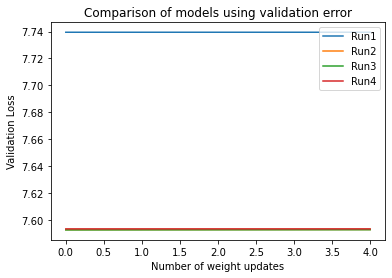

In [261]:
# Plotting validation loss of all the trials vs the Number of weight updates
plt.plot(bp_validation_error1)
plt.plot(bp_validation_error2)
plt.plot(bp_validation_error3)
plt.plot(bp_validation_error4)
plt.title('Comparison of models using validation error')
plt.ylabel('Validation Loss')
plt.xlabel('Number of weight updates')
plt.legend(['Run1', 'Run2', 'Run3', 'Run4'], loc='upper right')
plt.show()

In [262]:
# Storing the final validation for all models in a list
lowest_loss_obtained = [bp_validation_error1[-1],bp_validation_error2[-1],bp_validation_error3[-1],bp_validation_error4[-1]]

# Storing the time complexities for all models in a list
time_complexities = [bp_time_complexity1,bp_time_complexity2,bp_time_complexity3,bp_time_complexity4]

# Creating a list with all the model names
models = ['Run1', 'Run2', 'Run3', 'Run4']

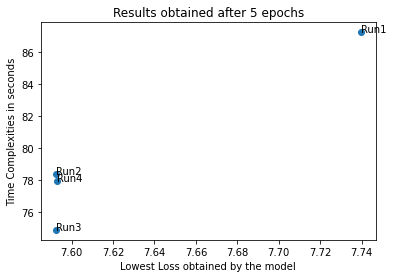

In [263]:
# Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation error
fig,ax = plt.subplots()
ax.scatter(lowest_loss_obtained, time_complexities)

plt.title('Results obtained after 5 epochs')
plt.ylabel('Time Complexities in seconds')
plt.xlabel('Lowest Loss obtained by the model')

for x,y in enumerate(models):
    ax.annotate(y, (lowest_loss_obtained[x], time_complexities[x]))    

In [264]:
architecture1_mean = statistics.mean(lowest_loss_obtained)
print('Architecture1 Validation Loss Mean: ', architecture1_mean)

Architecture1 Validation Loss Mean:  7.629478573799133


In [265]:
architecture1_stddev = statistics.stdev(lowest_loss_obtained)
print('Architecture1 Validation Loss Std Dev: ', architecture1_stddev)

Architecture1 Validation Loss Std Dev:  0.07332110726238823


In [266]:
architecture1_time_mean = statistics.mean(time_complexities)
print('Architecture1 Time Complexity Mean: ', architecture1_time_mean)

Architecture1 Time Complexity Mean:  79.61661435078713


In [267]:
acc_list = [bp_validation_acc1[-1],bp_validation_acc2[-1],bp_validation_acc3[-1],bp_validation_acc4[-1]]
architecture1_acc_mean = statistics.mean(acc_list)
print('Architecture1 Validation Accuracy Mean: ', architecture1_acc_mean*100)

Architecture1 Validation Accuracy Mean:  50.087445974349976


### Architecture2 - 1 CNN layer, 1 hidden layer=40 nodes, epochs=5, batch_size=20, optimizer=adam, activation=relu

### Run1

In [268]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (20,1)))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 22s 75ms/step - loss: 7.8384 - accuracy: 0.4898 - val_loss: 7.7323 - val_accuracy: 0.4983
Epoch 2/5
301/301 [==============================] - 27s 91ms/step - loss: 7.7339 - accuracy: 0.4956 - val_loss: 7.5926 - val_accuracy: 0.5017
Epoch 3/5
301/301 [==============================] - 21s 69ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5933 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 31s 102ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5936 - val_accuracy: 0.5017
Epoch 5/5
301/301 [==============================] - 26s 85ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5938 - val_accuracy: 0.5017


In [269]:
# Calculating the final validation mse
bp_validation_error1 = history_bp.history['val_loss']
print('Final Validation loss for CNN Model for 1st Run:', bp_validation_error1[-1] )

# Calculating the final validation accracy
bp_validation_acc1 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for CNN Model for 1st Run:', bp_validation_acc1[-1] )


# Calculating the time complexity
bp_time_complexity1 = sum(time_bp)
print('Time complexity for CNN Model for 1st Run:', bp_time_complexity1,'seconds')

Final Validation loss for CNN Model for 1st Run: 7.593807697296143
Final Validation Accuracy for CNN Model for 1st Run: 0.5017489194869995
Time complexity for CNN Model for 1st Run: 128.91608576802537 seconds


### Run2

In [270]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (20,1)))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 23s 78ms/step - loss: 7.4435 - accuracy: 0.5136 - val_loss: 7.5930 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 21s 69ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5934 - val_accuracy: 0.5017
Epoch 3/5
301/301 [==============================] - 20s 66ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5943 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 13s 44ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5949 - val_accuracy: 0.5017
Epoch 5/5
301/301 [==============================] - 21s 71ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5953 - val_accuracy: 0.5017


In [271]:
# Calculating the final validation mse
bp_validation_error2 = history_bp.history['val_loss']
print('Final Validation Loss for CNN Model for 2nd Run:', bp_validation_error2[-1] )

# Calculating the final validation accracy
bp_validation_acc2 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for CNN Model for 2nd Run:', bp_validation_acc2[-1] )


# Calculating the time complexity
bp_time_complexity2 = sum(time_bp)
print('Time complexity for CNN Model for 2nd Run:', bp_time_complexity2,'seconds')

Final Validation Loss for CNN Model for 2nd Run: 7.595292568206787
Final Validation Accuracy for CNN Model for 2nd Run: 0.5017489194869995
Time complexity for CNN Model for 2nd Run: 100.47596269426867 seconds


### Run3

In [272]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (20,1)))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 25s 82ms/step - loss: 7.6392 - accuracy: 0.4989 - val_loss: 7.5920 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 27s 89ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5932 - val_accuracy: 0.5017
Epoch 3/5
301/301 [==============================] - 19s 62ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5935 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 24s 78ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5940 - val_accuracy: 0.5017
Epoch 5/5
301/301 [==============================] - 24s 80ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5944 - val_accuracy: 0.5017


In [273]:
# Calculating the final validation mse
bp_validation_error3 = history_bp.history['val_loss']
print('Final Validation Loss for CNN Model for 3rd Run:', bp_validation_error3[-1] )

# Calculating the final validation accracy
bp_validation_acc3 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for CNN Model for 3rd Run:', bp_validation_acc3[-1] )

# Calculating the time complexity
bp_time_complexity3 = sum(time_bp)
print('Time complexity for CNN Model for 3rd Run:', bp_time_complexity3,'seconds')

Final Validation Loss for CNN Model for 3rd Run: 7.594433307647705
Final Validation Accuracy for CNN Model for 3rd Run: 0.5017489194869995
Time complexity for CNN Model for 3rd Run: 119.37909651000518 seconds


### Run4

In [274]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (20,1)))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 23s 77ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5946 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 29s 97ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5956 - val_accuracy: 0.5017
Epoch 3/5
301/301 [==============================] - 23s 76ms/step - loss: 7.6360 - accuracy: 0.4993 - val_loss: 7.5963 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 26s 86ms/step - loss: 7.6360 - accuracy: 0.4993 - val_loss: 7.5966 - val_accuracy: 0.5017
Epoch 5/5
301/301 [==============================] - 25s 83ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5968 - val_accuracy: 0.5017


In [275]:
# Calculating the final validation mse
bp_validation_error4 = history_bp.history['val_loss']
print('Final Validation Loss for CNN Model for 4th Run:', bp_validation_error4[-1] )

# Calculating the final validation accracy
bp_validation_acc4 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for CNN Model for 4th Run:', bp_validation_acc4[-1] )

# Calculating the time complexity
bp_time_complexity4 = sum(time_bp)
print('Time complexity for CNN Model for 4th Run:', bp_time_complexity4,'seconds')

Final Validation Loss for CNN Model for 4th Run: 7.596827507019043
Final Validation Accuracy for CNN Model for 4th Run: 0.5017489194869995
Time complexity for CNN Model for 4th Run: 128.13055393705145 seconds


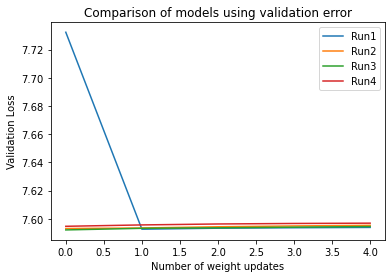

In [276]:
# Plotting validation loss of all the trials vs the Number of weight updates
plt.plot(bp_validation_error1)
plt.plot(bp_validation_error2)
plt.plot(bp_validation_error3)
plt.plot(bp_validation_error4)
plt.title('Comparison of models using validation error')
plt.ylabel('Validation Loss')
plt.xlabel('Number of weight updates')
plt.legend(['Run1', 'Run2', 'Run3', 'Run4'], loc='upper right')
plt.show()

In [277]:
# Storing the final validation for all models in a list
lowest_loss_obtained = [bp_validation_error1[-1],bp_validation_error2[-1],bp_validation_error3[-1],bp_validation_error4[-1]]

# Storing the time complexities for all models in a list
time_complexities = [bp_time_complexity1,bp_time_complexity2,bp_time_complexity3,bp_time_complexity4]

# Creating a list with all the model names
models = ['Run1', 'Run2', 'Run3', 'Run4']

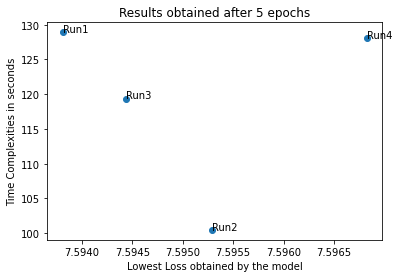

In [278]:
# Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation error
fig,ax = plt.subplots()
ax.scatter(lowest_loss_obtained, time_complexities)

plt.title('Results obtained after 5 epochs')
plt.ylabel('Time Complexities in seconds')
plt.xlabel('Lowest Loss obtained by the model')

for x,y in enumerate(models):
    ax.annotate(y, (lowest_loss_obtained[x], time_complexities[x]))    

In [279]:
architecture2_mean = statistics.mean(lowest_loss_obtained)
print('Architecture2 Validation Loss Mean: ', architecture2_mean)

Architecture2 Validation Loss Mean:  7.595090270042419


In [280]:
architecture2_stddev = statistics.stdev(lowest_loss_obtained)
print('Architecture2 Validation Loss Std Dev: ', architecture2_stddev)

Architecture2 Validation Loss Std Dev:  0.0013083716721960913


In [281]:
architecture2_time_mean = statistics.mean(time_complexities)
print('Architecture2 Time Complexity Mean: ', architecture2_time_mean)

Architecture2 Time Complexity Mean:  119.22542472733767


In [282]:
acc_list = [bp_validation_acc1[-1],bp_validation_acc2[-1],bp_validation_acc3[-1],bp_validation_acc4[-1]]
architecture2_acc_mean = statistics.mean(acc_list)
print('Architecture2 Validation Accuracy Mean: ', architecture2_acc_mean*100)

Architecture2 Validation Accuracy Mean:  50.17489194869995


### Architecture3 - 1st CNN layer,  2nd hidden layer=40 nodes, 3rd hidden layer=20 nodes, epochs=5, batch_size=20, optimizer=adam, activation=relu

### Run1

In [283]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (20,1)))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(20, input_dim=40, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 31s 101ms/step - loss: 7.6002 - accuracy: 0.5012 - val_loss: 7.5932 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 26s 86ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5935 - val_accuracy: 0.5017
Epoch 3/5
301/301 [==============================] - 26s 88ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5940 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 32s 105ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5948 - val_accuracy: 0.5017
Epoch 5/5
301/301 [==============================] - 33s 110ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5955 - val_accuracy: 0.5017


In [284]:
# Calculating the final validation mse
bp_validation_error1 = history_bp.history['val_loss']
print('Final Validation Loss for CNN Model for 1st Run:', bp_validation_error1[-1] )

# Calculating the final validation accracy
bp_validation_acc1 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for CNN Model for 1st Run:', bp_validation_acc1[-1] )


# Calculating the time complexity
bp_time_complexity1 = sum(time_bp)
print('Time complexity for CNN Model for 1st Run:', bp_time_complexity1,'seconds')

Final Validation Loss for CNN Model for 1st Run: 7.595495700836182
Final Validation Accuracy for CNN Model for 1st Run: 0.5017489194869995
Time complexity for CNN Model for 1st Run: 149.95415571297053 seconds


### Run2

In [285]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (20,1)))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(20, input_dim=40, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 31s 104ms/step - loss: 7.6757 - accuracy: 0.5016 - val_loss: 7.5822 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 20s 65ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5931 - val_accuracy: 0.5017
Epoch 3/5
301/301 [==============================] - 20s 66ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5934 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 31s 103ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5937 - val_accuracy: 0.5017
Epoch 5/5
301/301 [==============================] - 26s 87ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5943 - val_accuracy: 0.5017


In [286]:
# Calculating the final validation mse
bp_validation_error2 = history_bp.history['val_loss']
print('Final Validation Loss for CNN Model for 2nd Run:', bp_validation_error2[-1] )

# Calculating the final validation accracy
bp_validation_acc2 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for CNN Model for 2nd Run:', bp_validation_acc2[-1] )


# Calculating the time complexity
bp_time_complexity2 = sum(time_bp)
print('Time complexity for CNN Model for 2nd Run:', bp_time_complexity2,'seconds')

Final Validation Loss for CNN Model for 2nd Run: 7.5943145751953125
Final Validation Accuracy for CNN Model for 2nd Run: 0.5017489194869995
Time complexity for CNN Model for 2nd Run: 130.34204783907626 seconds


### Run3

In [287]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (20,1)))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(20, input_dim=40, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 30s 99ms/step - loss: 7.4544 - accuracy: 0.5142 - val_loss: 7.5870 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 32s 106ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5927 - val_accuracy: 0.5017
Epoch 3/5
301/301 [==============================] - 37s 122ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5935 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 19s 64ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5941 - val_accuracy: 0.5017
Epoch 5/5
301/301 [==============================] - 35s 115ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5947 - val_accuracy: 0.5017


In [288]:
# Calculating the final validation mse
bp_validation_error3 = history_bp.history['val_loss']
print('Final Validation Loss for CNN Model for 3rd Run:', bp_validation_error3[-1] )

# Calculating the final validation accracy
bp_validation_acc3 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for CNN Model for 3rd Run:', bp_validation_acc3[-1] )

# Calculating the time complexity
bp_time_complexity3 = sum(time_bp)
print('Time complexity for CNN Model for 3rd Run:', bp_time_complexity3,'seconds')

Final Validation Loss for CNN Model for 3rd Run: 7.594735145568848
Final Validation Accuracy for CNN Model for 3rd Run: 0.5017489194869995
Time complexity for CNN Model for 3rd Run: 154.08608515607193 seconds


### Run4

In [289]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (20,1)))
model_bp.add(Dense(40, input_dim=20, activation='relu'))
model_bp.add(Dense(20, input_dim=40, activation='relu'))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=5, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/5
301/301 [==============================] - 34s 114ms/step - loss: 7.8111 - accuracy: 0.4906 - val_loss: 7.5807 - val_accuracy: 0.5017
Epoch 2/5
301/301 [==============================] - 28s 93ms/step - loss: 7.6435 - accuracy: 0.4986 - val_loss: 7.5909 - val_accuracy: 0.5017
Epoch 3/5
301/301 [==============================] - 27s 90ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5931 - val_accuracy: 0.5017
Epoch 4/5
301/301 [==============================] - 21s 69ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5932 - val_accuracy: 0.5017
Epoch 5/5
301/301 [==============================] - 23s 76ms/step - loss: 7.6361 - accuracy: 0.4993 - val_loss: 7.5933 - val_accuracy: 0.5017


In [290]:
# Calculating the final validation mse
bp_validation_error4 = history_bp.history['val_loss']
print('Final Validation Loss for CNN Model for 4th Run:', bp_validation_error4[-1] )

# Calculating the final validation accracy
bp_validation_acc4 = history_bp.history['val_accuracy']
print('Final Validation Accuracy for CNN Model for 4th Run:', bp_validation_acc4[-1] )

# Calculating the time complexity
bp_time_complexity4 = sum(time_bp)
print('Time complexity for CNN Model for 4th Run:', bp_time_complexity4,'seconds')

Final Validation Loss for CNN Model for 4th Run: 7.59329891204834
Final Validation Accuracy for CNN Model for 4th Run: 0.5017489194869995
Time complexity for CNN Model for 4th Run: 135.5300042470917 seconds


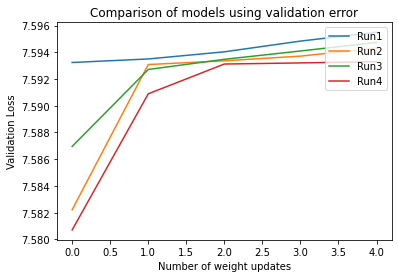

In [291]:
# Plotting validation loss of all the trials vs the Number of weight updates
plt.plot(bp_validation_error1)
plt.plot(bp_validation_error2)
plt.plot(bp_validation_error3)
plt.plot(bp_validation_error4)
plt.title('Comparison of models using validation error')
plt.ylabel('Validation Loss')
plt.xlabel('Number of weight updates')
plt.legend(['Run1', 'Run2', 'Run3', 'Run4'], loc='upper right')
plt.show()

In [292]:
# Storing the final validation for all models in a list
lowest_loss_obtained = [bp_validation_error1[-1],bp_validation_error2[-1],bp_validation_error3[-1],bp_validation_error4[-1]]

# Storing the time complexities for all models in a list
time_complexities = [bp_time_complexity1,bp_time_complexity2,bp_time_complexity3,bp_time_complexity4]

# Creating a list with all the model names
models = ['Run1', 'Run2', 'Run3', 'Run4']

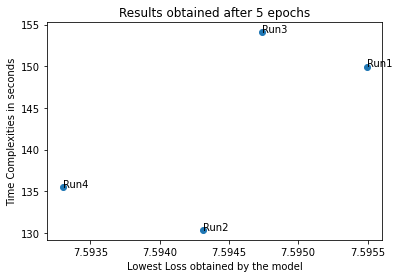

In [293]:
# Plotting a scatter plot to show the time complexity for each model along with their respective lowest validation error
fig,ax = plt.subplots()
ax.scatter(lowest_loss_obtained, time_complexities)

plt.title('Results obtained after 5 epochs')
plt.ylabel('Time Complexities in seconds')
plt.xlabel('Lowest Loss obtained by the model')

for x,y in enumerate(models):
    ax.annotate(y, (lowest_loss_obtained[x], time_complexities[x]))    

In [294]:
architecture3_mean = statistics.mean(lowest_loss_obtained)
print('Architecture3 Validation Loss Mean: ', architecture3_mean)

Architecture3 Validation Loss Mean:  7.59446108341217


In [295]:
architecture3_stddev = statistics.stdev(lowest_loss_obtained)
print('Architecture3 Validation Loss Std Dev: ', architecture3_stddev)

Architecture3 Validation Loss Std Dev:  0.0009160877353006644


In [296]:
architecture3_time_mean = statistics.mean(time_complexities)
print('Architecture3 Time Complexity Mean: ', architecture3_time_mean)

Architecture3 Time Complexity Mean:  142.4780732388026


In [297]:
acc_list = [bp_validation_acc1[-1],bp_validation_acc2[-1],bp_validation_acc3[-1],bp_validation_acc4[-1]]
architecture3_acc_mean = statistics.mean(acc_list)
print('Architecture3 Validation Accuracy Mean: ', architecture3_acc_mean*100)

Architecture3 Validation Accuracy Mean:  50.17489194869995


In [298]:
# Creating a summary table for the model names, lowest MSE and their time complexities
model_summary = pd.DataFrame({"Model":["CNN Architecture1","CNN Architecture2",
                                       "CNN Architecture3"], "Mean Validation loss after 4 trials":[architecture1_mean,architecture2_mean,architecture3_mean],
                              "Mean Standard deviation after 4 trials":[architecture1_stddev,architecture2_stddev,architecture3_stddev],
                            "Mean Time Complexity in seconds after 4 trials":[architecture1_time_mean,architecture2_time_mean,architecture3_time_mean],
                              "Mean Validation Accuracy after 4 trials":[architecture1_acc_mean,architecture2_acc_mean,architecture3_acc_mean]
                                               })

In [299]:
model_summary

,Model,Mean Validation loss after 4 trials,Mean Standard deviation after 4 trials,Mean Time Complexity in seconds after 4 trials,Mean Validation Accuracy after 4 trials
0,CNN Architecture1,7.629479,0.073321,79.616614,0.500874
1,CNN Architecture2,7.595090,0.001308,119.225425,0.501749
2,CNN Architecture3,7.594461,0.000916,142.478073,0.501749


### Using Best Model - CNN Architecture1 - with - epochs=20

In [300]:
# Set the seed
# np.random.seed(12345)
# tf.random.set_seed(12345)

# Invoking time complexity function
tc_bp = TimeComplexity()

# Invoking history function
history=History()

# Building Plain backpropagation model
model_bp = Sequential()
model_bp.add(Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (20,1)))
model_bp.add(Dense(1, activation='sigmoid'))

# Compiling the model
model_bp.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting the model
history_bp = model_bp.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=20, batch_size=20, callbacks=[tc_bp,history])

# Calculating the time taken for each epoch
time_bp=tc_bp.logs

Epoch 1/20
301/301 [==============================] - 16s 52ms/step - loss: 7.4612 - accuracy: 0.5122 - val_loss: 7.5914 - val_accuracy: 0.5017
Epoch 2/20
301/301 [==============================] - 16s 52ms/step - loss: 7.6360 - accuracy: 0.4993 - val_loss: 7.5891 - val_accuracy: 0.5017
Epoch 3/20
301/301 [==============================] - 18s 59ms/step - loss: 7.6519 - accuracy: 0.5031 - val_loss: 7.7395 - val_accuracy: 0.4983
Epoch 4/20
301/301 [==============================] - 14s 48ms/step - loss: 7.6997 - accuracy: 0.5007 - val_loss: 7.7395 - val_accuracy: 0.4983
Epoch 5/20
301/301 [==============================] - 8s 27ms/step - loss: 7.6996 - accuracy: 0.5007 - val_loss: 7.7395 - val_accuracy: 0.4983
Epoch 6/20
301/301 [==============================] - 14s 48ms/step - loss: 7.6996 - accuracy: 0.5007 - val_loss: 7.7395 - val_accuracy: 0.4983
Epoch 7/20
301/301 [==============================] - 12s 42ms/step - loss: 7.6996 - accuracy: 0.5007 - val_loss: 7.7395 - val_accuracy: 

In [ ]:
# Calculating the final validation loss
bp_validation_error_best = history_bp.history['val_loss']
print('Final Validation Loss for Best CNN Model:', bp_validation_error_best[-1] )

# Calculating the final validation accracy
bp_validation_acc_best = history_bp.history['val_accuracy']
print('Final Validation Accuracy for Best CNN Model:', bp_validation_acc_best[-1] )


# Calculating the time complexity
bp_time_complexity_best = sum(time_bp)
print('Time complexity for Best CNN Model:', bp_time_complexity_best,'seconds')

In [ ]:
# Printing classification report for predictions made by model on validation dataset
print(classification_report(y_true=y_test,y_pred=(model_bp.predict(X_test)>0.5).astype(int)))

## Conclusion & Comparison of the above two approaches

- Below, I have presented two summary tables for all the ML models that have been implemented

- The first table represents the Model name, Recall, AUC and Accuracy scores for all the models implemented and evaluated after performing the Participant wise train- test shuffle

- The second table represents the Model name, Recall, AUC and Accuracy scores for all the models implemented and evaluated after performing the Random train- test shuffle

- We can conclude that the models implemented using the Random train-test shuffle performed better in comparison to the models implemented using the Participant wise train-test shuffle

- This could be due to the fact that the participant wise shuffle allows the model to get trained on a set of participants and then the predictions are made on a participant whose features were not present in the training sample. Because of this reason our models trained on participant wise training data are not performing that well as they are unable to make good predictions on unseen participant features and the out of sample accuracy is not that good

- In contrast, the models trained using a random train-test shuffle are able to perform better as they are being trained and then tested on random participant's features leading to a higher evaluation score

- In conclusion, I have implemented an end-to-end system which takes videos as inputs, extracts image frames from the videos, extracts facial landmarks from the image frames and predicts the Alert and Drowsy state for each frame of both the Alert and Drowsy videos and generates a csv as an output containing the participant id, time frame in sec, all 20 features of each participants and the predicted binary output state - Alert (0) / Drowsy (1) for each frame

In [185]:
# Creating a summary table for the model names, their recall, auc, accuracy scores, time taken to run the model and their best hyper parameters
best_models_participantSplit = pd.DataFrame({"Algorithm":["LR","NBC","DT","ANN","KNN","LSVM","RF","GBM","RNN","LSTM","GRU","CNN" ], "Recall":[50,45,45,56,46,49,47,44,50,50,50,50],
                            "AUC":[53,43.4,44.2,'-','-','-',43.2,34.9,'-','-','-','-'], 'Accuracy':[49,44,43,43,43,48,46,41,50,50,50,50]
                            })

In [186]:
# printing summary table
print('Best Models achived after Participant wise train-test shuffle')
best_models_participantSplit.sort_values(by="Recall",ascending=False)

Best Models achived after Participant wise train-test shuffle


,Algorithm,Recall,AUC,Accuracy
3,ANN,56,-,43
0,LR,50,53,49
8,RNN,50,-,50
9,LSTM,50,-,50
10,GRU,50,-,50
11,CNN,50,-,50
5,LSVM,49,-,48
6,RF,47,43.2,46
4,KNN,46,-,43
1,NBC,45,43.4,44


In [205]:
# Creating a summary table for the model names, their recall, auc, accuracy scores, time taken to run the model and their best hyper parameters
best_models_randomSplit = pd.DataFrame({"Algorithm":["LR","NBC","DT","ANN","KNN","LSVM","RF","GBM","RNN","LSTM","GRU","CNN" ], "Recall":[71,70,73,71,86,74,89,92,50,50,50,50],
                            "AUC":[78.9,76.4,85.2,'-','-','-',94.9,97.2,'-','-','-','-'], 'Accuracy':[72,70,77,77,86,75,87,91,50,50,50,50]
                            })

In [206]:
# printing summary table
print('Best Models achived after Random train-test shuffle')
best_models_randomSplit.sort_values(by="Recall",ascending=False)

Best Models achived after Random train-test shuffle


,Algorithm,Recall,AUC,Accuracy
7,GBM,92,97.2,91
6,RF,89,94.9,87
4,KNN,86,-,86
5,LSVM,74,-,75
2,DT,73,85.2,77
0,LR,71,78.9,72
3,ANN,71,-,77
1,NBC,70,76.4,70
8,RNN,50,-,50
9,LSTM,50,-,50


## Scoring with best model for Participant wise train-test shuffle: Using ANN model

- Here, I have scored the 9th participant with the ANN model as it has the best Recall score after evaluating on Participant wise train-test shuffle

- Output of the scoring process is a csv containing the participant id, time frame in sec, all 20 features of the participant and the predicted binary output state - Alert (0) / Drowsy (1) for each frame

In [187]:
# storing pid and time frames in a new dataframe from the score_df
pid_time_score_df = score_df[['Participant', 'TimeSec']].copy()

In [188]:
# removing irrelevant columns from score_df
del score_df['Participant']
del score_df['TimeSec']

In [189]:
# using best model to make predictions
score_prediction_df = ann1.predict(score_df)

In [190]:
# creating a final df with all the columns and the Predicted state
final_predictions_participantSplit = pd.concat([pid_time_score_df,score_df],axis=1)

In [191]:
# adding predictions to the final df
final_predictions_participantSplit['PredictedState'] = score_prediction_df

In [193]:
# converting PredictedState to 0 and 1 based on 0.5 threshold as ANN models yields probability and not an integer
final_predictions_participantSplit['PredictedState'] = np.where(final_predictions_participantSplit['PredictedState'] > 0.5, 1,0)

In [197]:
# printing head of final predictions df
final_predictions_participantSplit.head()

,Participant,TimeSec,EyeAspectRatio,MouthAspectRatio,PupilCircularity,MouthOverEye,EyeAspectRatio_lag1,EyeAspectRatio_lag2,EyeAspectRatio_lag3,EyeAspectRatio_lag4,...,MouthAspectRatio_lag4,PupilCircularity_lag1,PupilCircularity_lag2,PupilCircularity_lag3,PupilCircularity_lag4,MouthOverEye_lag1,MouthOverEye_lag2,MouthOverEye_lag3,MouthOverEye_lag4,PredictedState
4,1.0,6.0,-0.076812,-0.565562,-0.242544,-0.364267,-0.365755,-0.114432,0.031555,-0.372069,...,-0.602473,-0.596023,-0.352277,0.060234,-0.309245,-0.197587,-0.341425,-0.398881,-0.170063,1
5,1.0,7.0,-0.124332,-0.569046,-0.066230,-0.333118,-0.077776,-0.365326,-0.115763,0.031963,...,-0.487203,-0.243373,-0.595467,-0.353624,0.060521,-0.363392,-0.197789,-0.340440,-0.399396,1
6,1.0,8.0,-0.374630,-0.451720,-0.099912,-0.089575,-0.125298,-0.077491,-0.366836,-0.115359,...,-0.572417,-0.067060,-0.243004,-0.596963,-0.353289,-0.332254,-0.363500,-0.196747,-0.340949,1
7,1.0,9.0,-0.218275,-0.475669,-0.341681,-0.219298,-0.375606,-0.124989,-0.078795,-0.366439,...,-0.646619,-0.100742,-0.066785,-0.244285,-0.596601,-0.088800,-0.332380,-0.362523,-0.197240,1
8,1.0,10.0,-0.319753,-0.416967,-0.527000,-0.113717,-0.219245,-0.375173,-0.126327,-0.078391,...,-0.565509,-0.342509,-0.100449,-0.067958,-0.243963,-0.218476,-0.089063,-0.331391,-0.363035,1


In [198]:
# converting the final predictions to a csv
final_predictions_participantSplit.to_csv("final_predictions_participantSplit.csv",index=False)

## Scoring with best model for Random train-test shuffle: Using GBM model

- Here, I have scored the 9th participant with the GBM model as it has the best Recall score after evaluating on Random train-test shuffle

- Output of the scoring process is a csv containing the participant id, time frame in sec, all 20 features of the participant and the predicted binary output state - Alert (0) / Drowsy (1) for each frame

In [181]:
# storing pid and time frames in a new dataframe from the score_df
pid_time_score_df = score_df[['Participant', 'TimeSec']].copy()

In [182]:
# removing irrelevant columns from score_df
del score_df['Participant']
del score_df['TimeSec']

In [201]:
# using best model to make predictions
score_prediction_df = gbm_model.predict(score_df)

In [184]:
# creating a final df with all the columns and the Predicted state
final_predictions_randomSplit = pd.concat([pid_time_score_df,score_df],axis=1)

In [202]:
# adding predictions to the final df
final_predictions_randomSplit['PredictedState'] = score_prediction_df

In [203]:
# printing head of final predictions df
final_predictions_randomSplit.head(10)

,Participant,TimeSec,EyeAspectRatio,MouthAspectRatio,PupilCircularity,MouthOverEye,EyeAspectRatio_lag1,EyeAspectRatio_lag2,EyeAspectRatio_lag3,EyeAspectRatio_lag4,...,MouthAspectRatio_lag4,PupilCircularity_lag1,PupilCircularity_lag2,PupilCircularity_lag3,PupilCircularity_lag4,MouthOverEye_lag1,MouthOverEye_lag2,MouthOverEye_lag3,MouthOverEye_lag4,PredictedState
4,1.0,6.0,-0.076812,-0.565562,-0.242544,-0.364267,-0.365755,-0.114432,0.031555,-0.372069,...,-0.602473,-0.596023,-0.352277,0.060234,-0.309245,-0.197587,-0.341425,-0.398881,-0.170063,1
5,1.0,7.0,-0.124332,-0.569046,-0.066230,-0.333118,-0.077776,-0.365326,-0.115763,0.031963,...,-0.487203,-0.243373,-0.595467,-0.353624,0.060521,-0.363392,-0.197789,-0.340440,-0.399396,1
6,1.0,8.0,-0.374630,-0.451720,-0.099912,-0.089575,-0.125298,-0.077491,-0.366836,-0.115359,...,-0.572417,-0.067060,-0.243004,-0.596963,-0.353289,-0.332254,-0.363500,-0.196747,-0.340949,1
7,1.0,9.0,-0.218275,-0.475669,-0.341681,-0.219298,-0.375606,-0.124989,-0.078795,-0.366439,...,-0.646619,-0.100742,-0.066785,-0.244285,-0.596601,-0.088800,-0.332380,-0.362523,-0.197240,1
8,1.0,10.0,-0.319753,-0.416967,-0.527000,-0.113717,-0.219245,-0.375173,-0.126327,-0.078391,...,-0.565509,-0.342509,-0.100449,-0.067958,-0.243963,-0.218476,-0.089063,-0.331391,-0.363035,1
9,1.0,11.0,-0.274273,-0.534341,-0.707478,-0.208018,-0.320728,-0.218889,-0.376689,-0.125924,...,-0.568991,-0.527827,-0.342087,-0.101643,-0.067656,-0.112933,-0.218666,-0.087978,-0.331899,1
10,1.0,12.0,-0.167579,-0.425428,-0.151893,-0.230759,-0.275246,-0.320321,-0.220294,-0.376292,...,-0.451708,-0.708304,-0.527308,-0.343428,-0.101337,-0.207199,-0.113182,-0.217632,-0.088460,1
11,1.0,13.0,-0.118136,-0.520016,-0.082188,-0.313076,-0.168547,-0.274862,-0.321799,-0.219893,...,-0.475648,-0.152723,-0.707689,-0.528761,-0.343095,-0.229933,-0.207395,-0.112107,-0.218128,1
12,1.0,14.0,-0.279589,-0.416917,-0.730366,-0.144062,-0.119102,-0.168216,-0.276307,-0.321401,...,-0.416967,-0.083018,-0.152402,-0.709252,-0.528407,-0.312220,-0.230116,-0.206357,-0.112591,1
13,1.0,15.0,-0.328523,-0.558096,-0.262174,-0.179809,-0.280562,-0.118796,-0.169585,-0.275908,...,-0.534299,-0.731192,-0.082734,-0.153627,-0.708878,-0.143267,-0.312357,-0.229087,-0.206852,1


In [204]:
# converting the final predictions to a csv
final_predictions_randomSplit.to_csv("final_predictions_randomSplit.csv",index=False)

## Further experiments I will be working on

- Some of the models like RNN, LSTM, GRU and CNN are not yielding an expected classification report. I will working on this and investigate how I can improve the performance of these 4 models by trying out different number of hidden layers and dropout layers and tweaking other hyperparameters like epochs, batch size, learning rate

- If time permits, I would be researching on some other facial features and landmarks that will help our models perform better on out of sample data

- In the future, I plan on creating an IOS/Android app for this system. I would be integrating this machine learning code and researching on how we can extend this to a mobile app. This app will be really useful for a lot of individuals and will help in reducing the number of accidents caused due to Drowsiness while Driving 